In [1]:
#%install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py
%load_ext autotime
import osmnx as ox, geopandas as gpd, pandas as pd, networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon, MultiPolygon
from IPython.display import Image
from descartes import PolygonPatch
from itertools import combinations, combinations_with_replacement
%matplotlib inline
ox.config(log_console=True, use_cache=True)
%config IPCompleter.greedy=True

import libpysal as lp

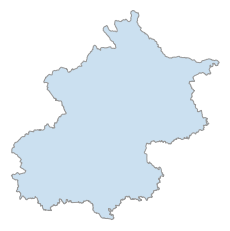

+proj=utm +zone=50 +ellps=WGS84 +datum=WGS84 +units=m +no_defs


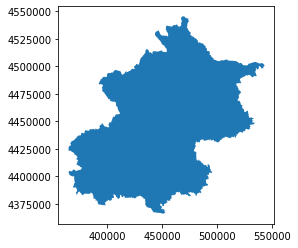

time: 412 ms


In [2]:
city = ox.gdf_from_place('Beijing, China')
city = ox.project_gdf(city)
fig, ax = ox.plot_shape(city, figsize=(4,4))
ox.save_gdf_shapefile(city)
crs = {'init': 'epsg:4326'}
#city = city.to_crs(crs)
print(city.crs)
city.plot()

In [7]:
Beijing = ox.gdf_from_place('Beijing, China')
Beijing = ox.projection.project_gdf(city)
Beijing.crs

'+proj=utm +zone=50 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'

time: 8 ms


In [8]:
circle = Point(116.4074, 39.9042)
circle = circle.to_crs(Beijing.crs)
circle.crs

AttributeError: 'Point' object has no attribute 'to_crs'

time: 12 ms


In [ ]:
#39.9042° N, 116.4074° E
circle = Point(116.4074, 39.9042).buffer(17*0.00899928)
c = gpd.GeoSeries(circle)
df1 = gpd.GeoDataFrame({'geometry': c, 'df1':[1]}, crs=crs)
city_union = gpd.overlay(df1, city, how='intersection')
city_union.plot()

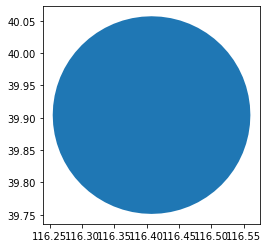

time: 279 ms


In [3]:
#39.9042° N, 116.4074° E
circle = Point(116.4074, 39.9042).buffer(17*0.00899928)
c = gpd.GeoSeries(circle)
df1 = gpd.GeoDataFrame({'geometry': c, 'df1':[1]}, crs=crs)
city_union = gpd.overlay(df1, city, how='intersection')
city_union.plot()

2158
data max index: 2157
number of NA prices: 0
average bedroom price 69.92390619821015
pointinpoly length: 2064
check contains: True
check if there are NAs: False


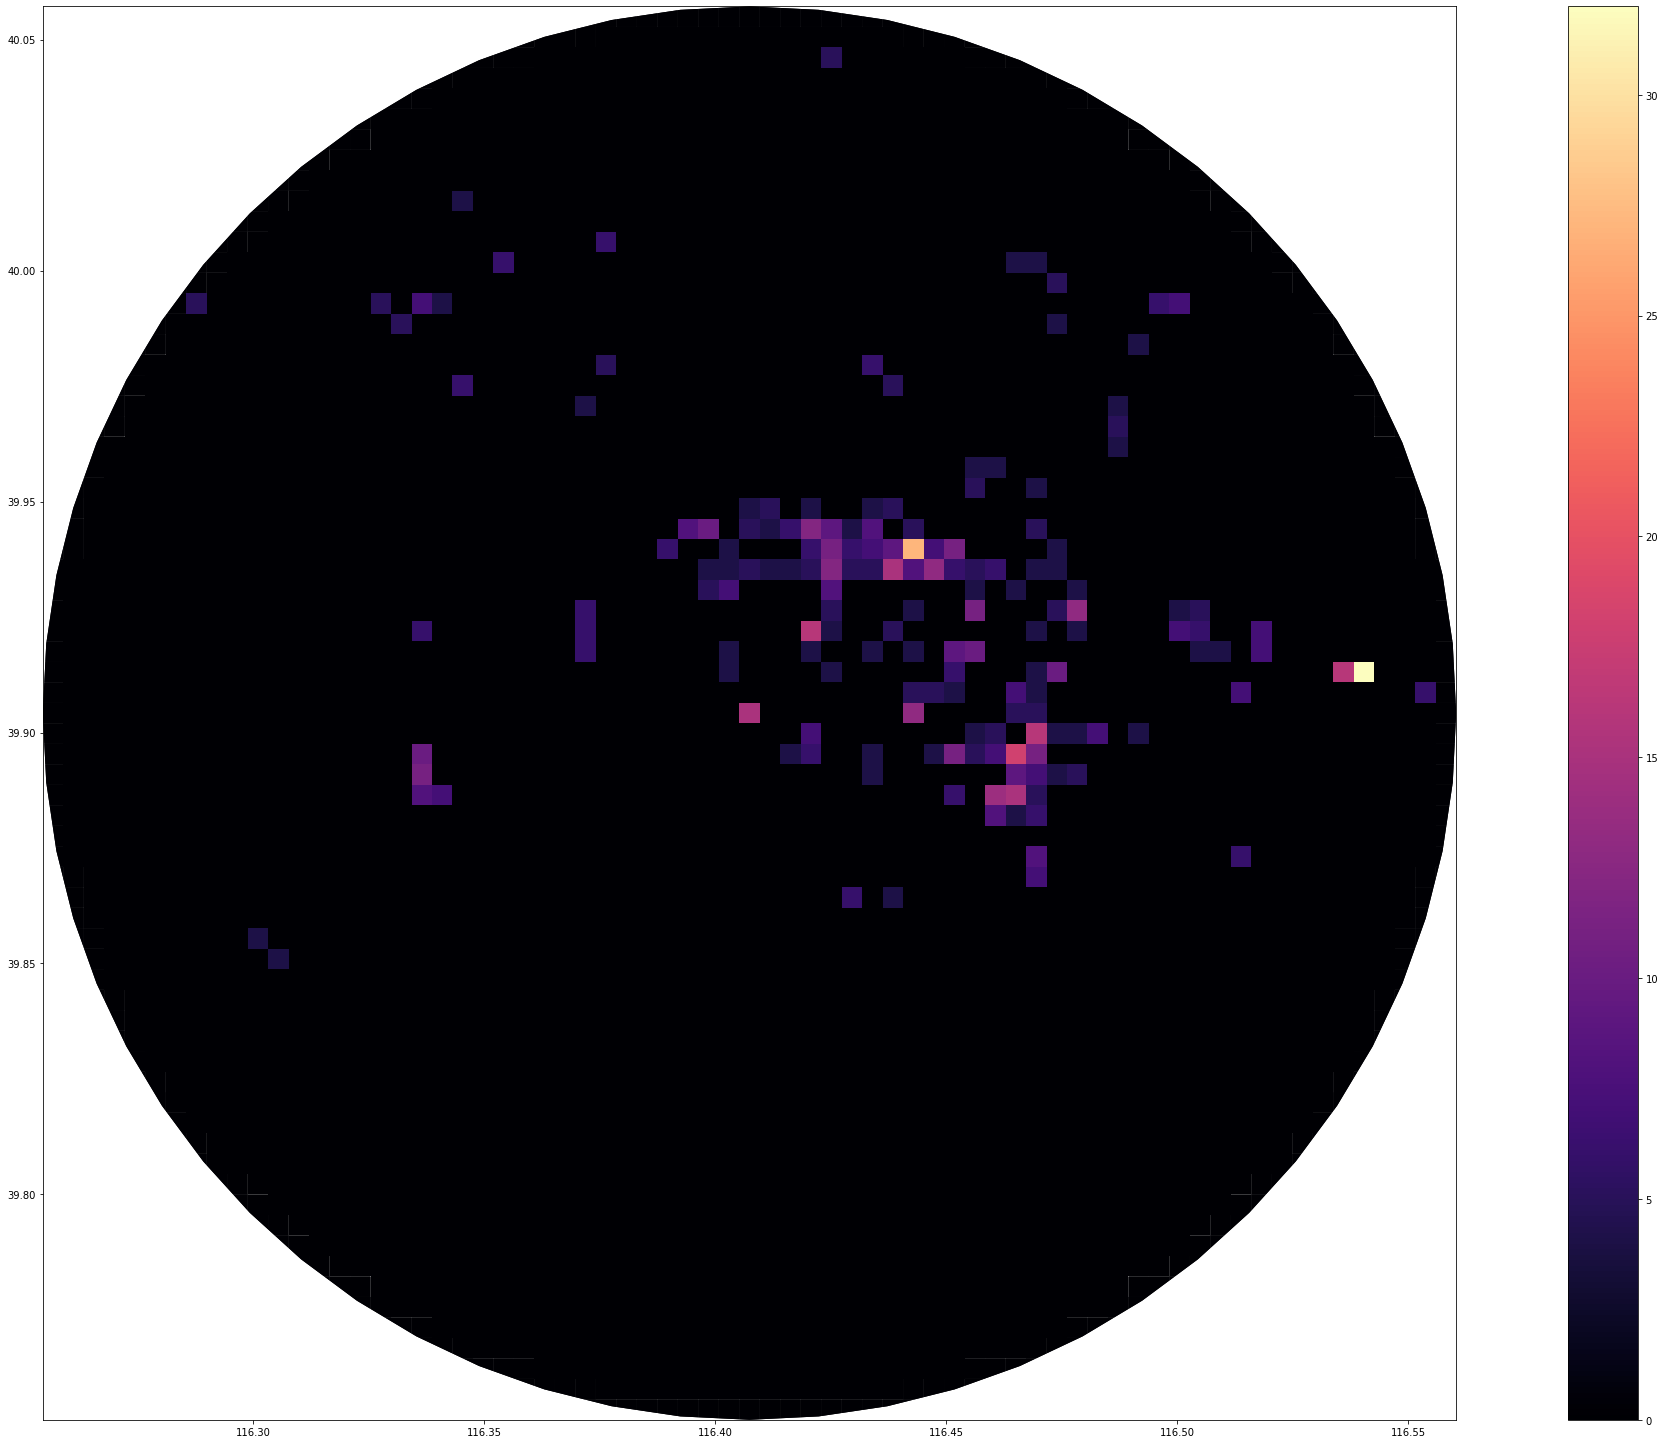

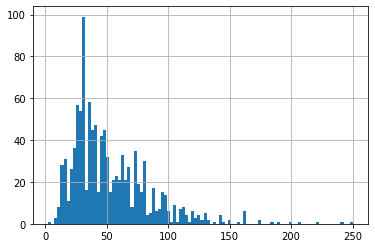

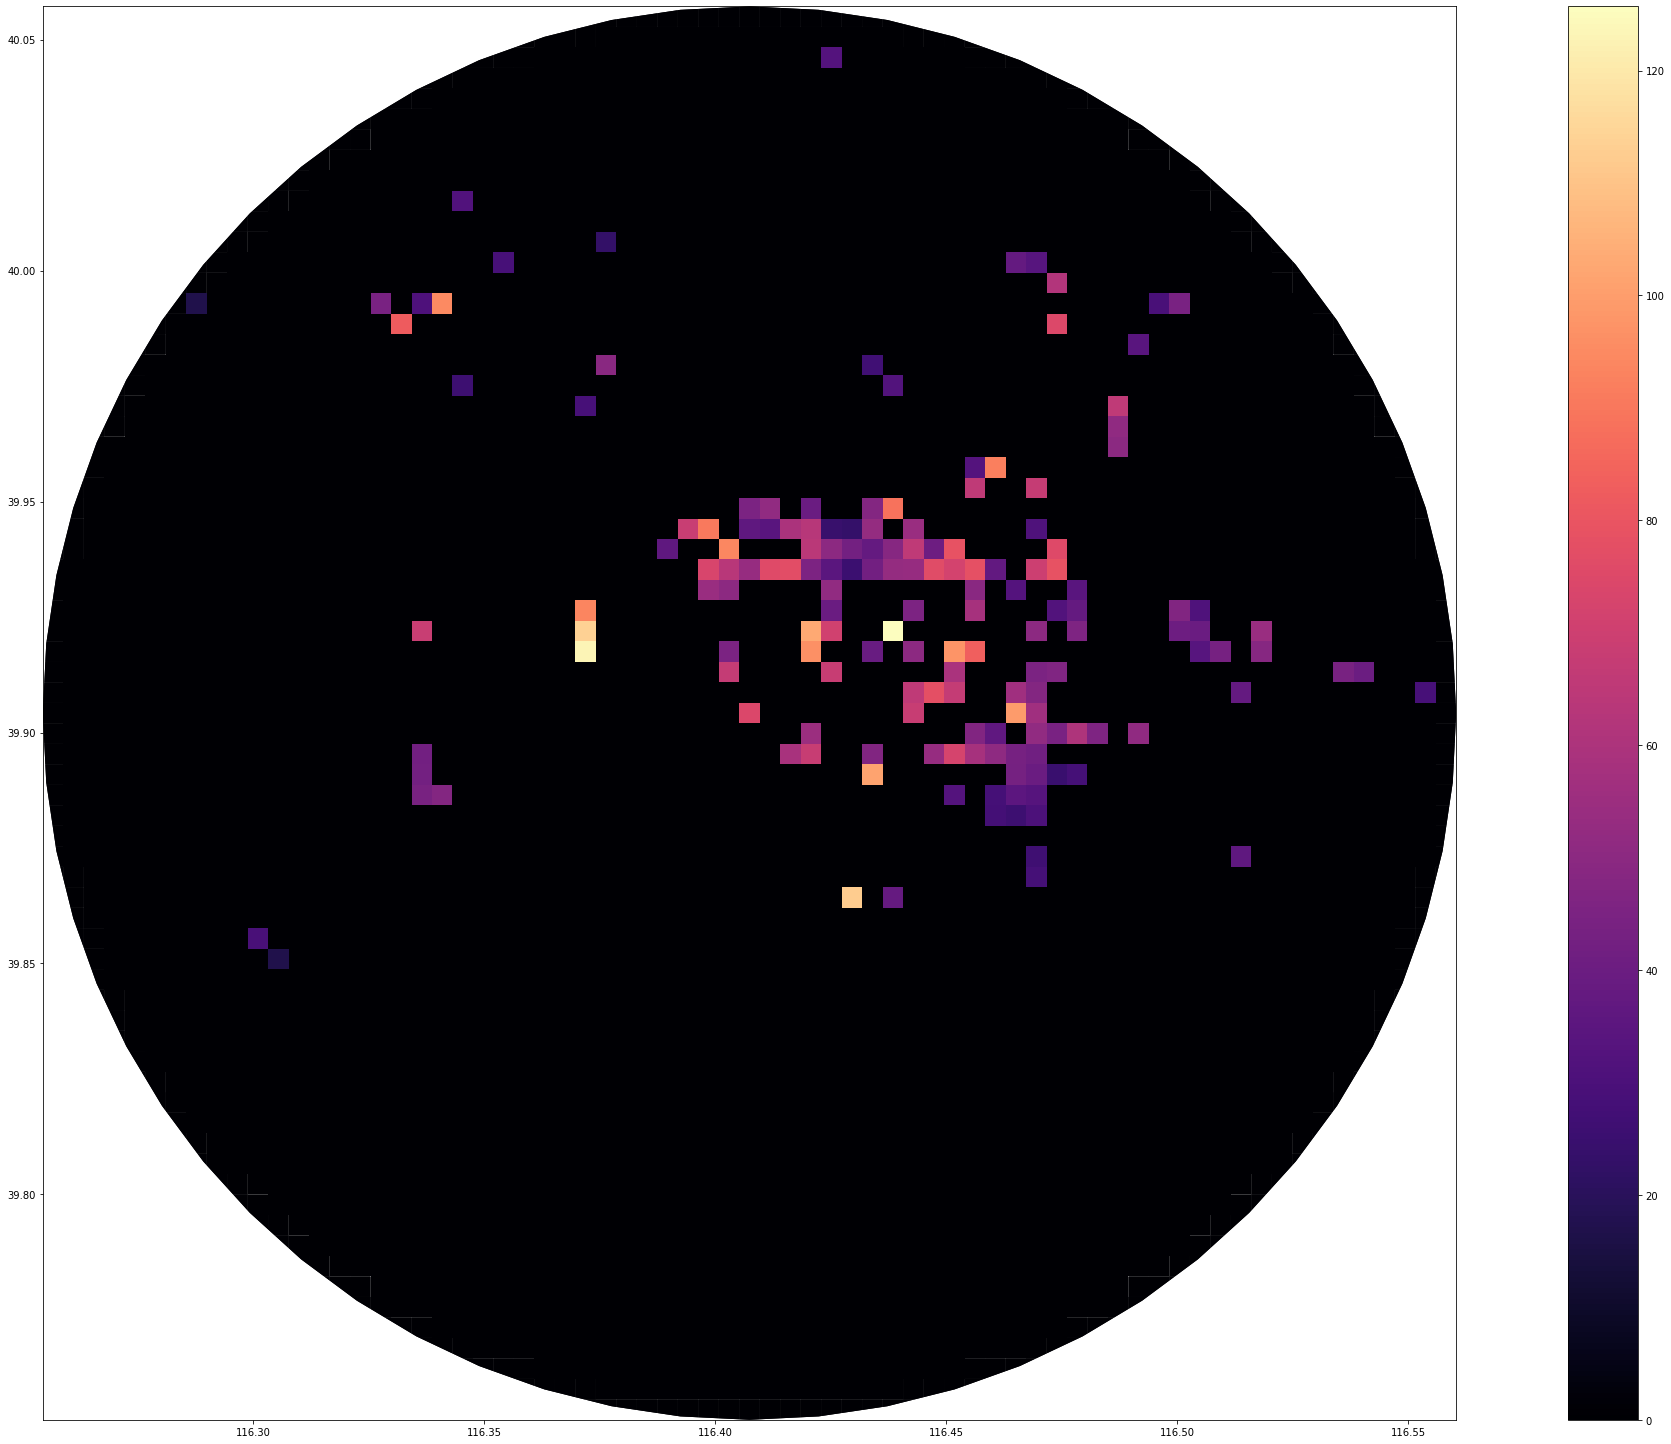

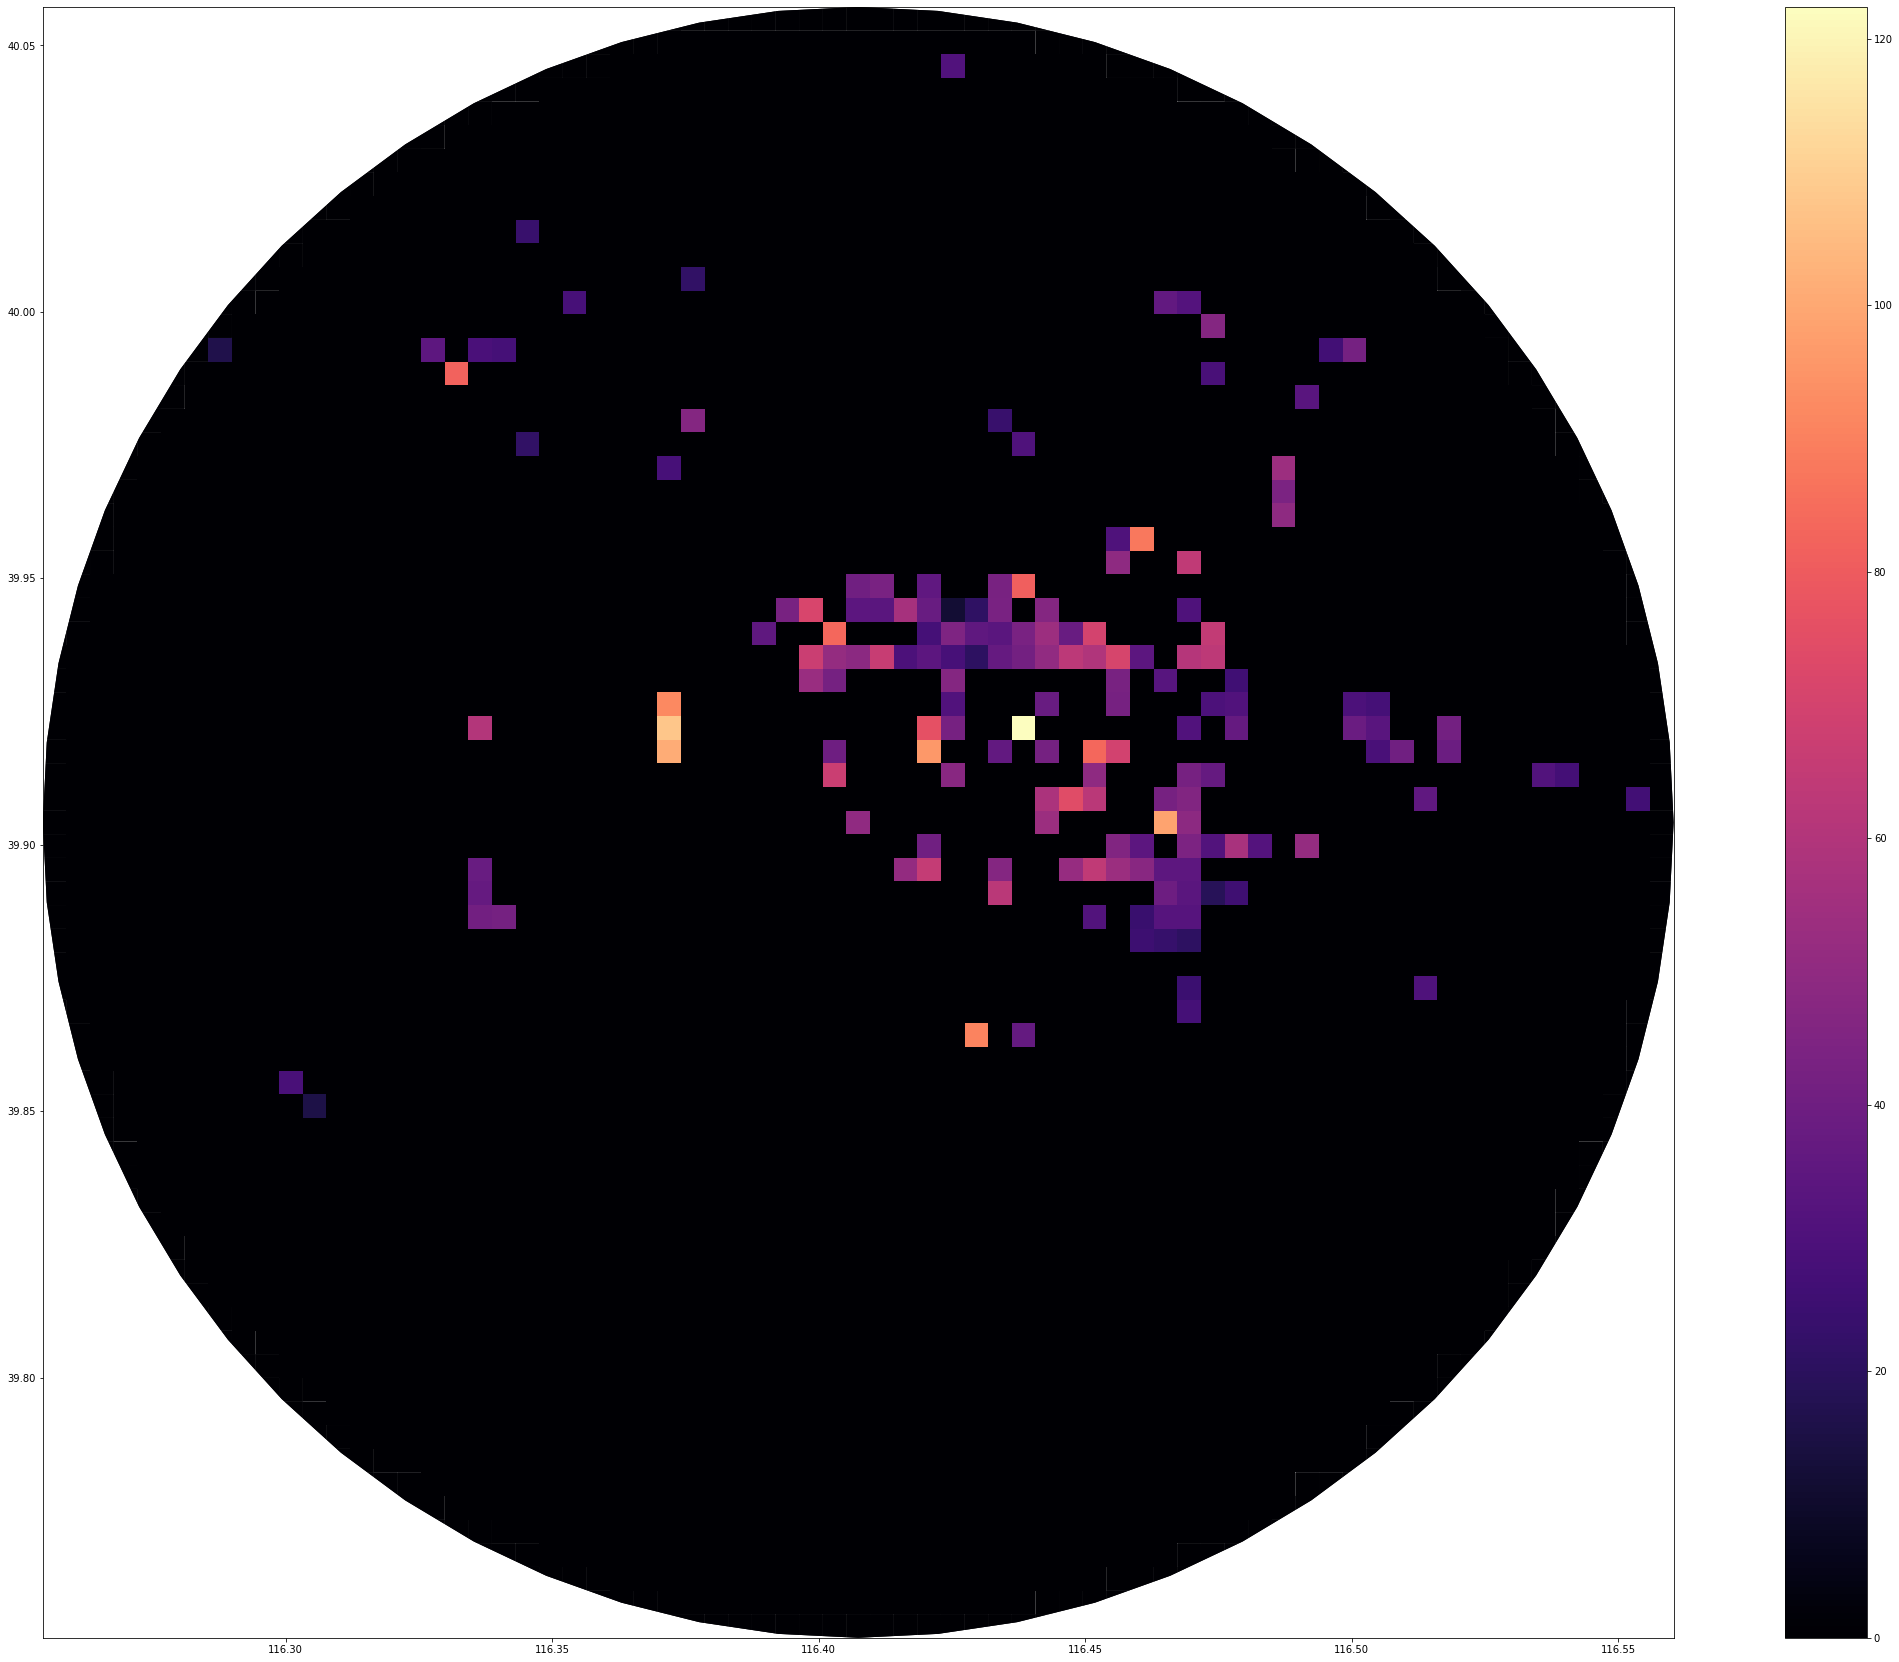

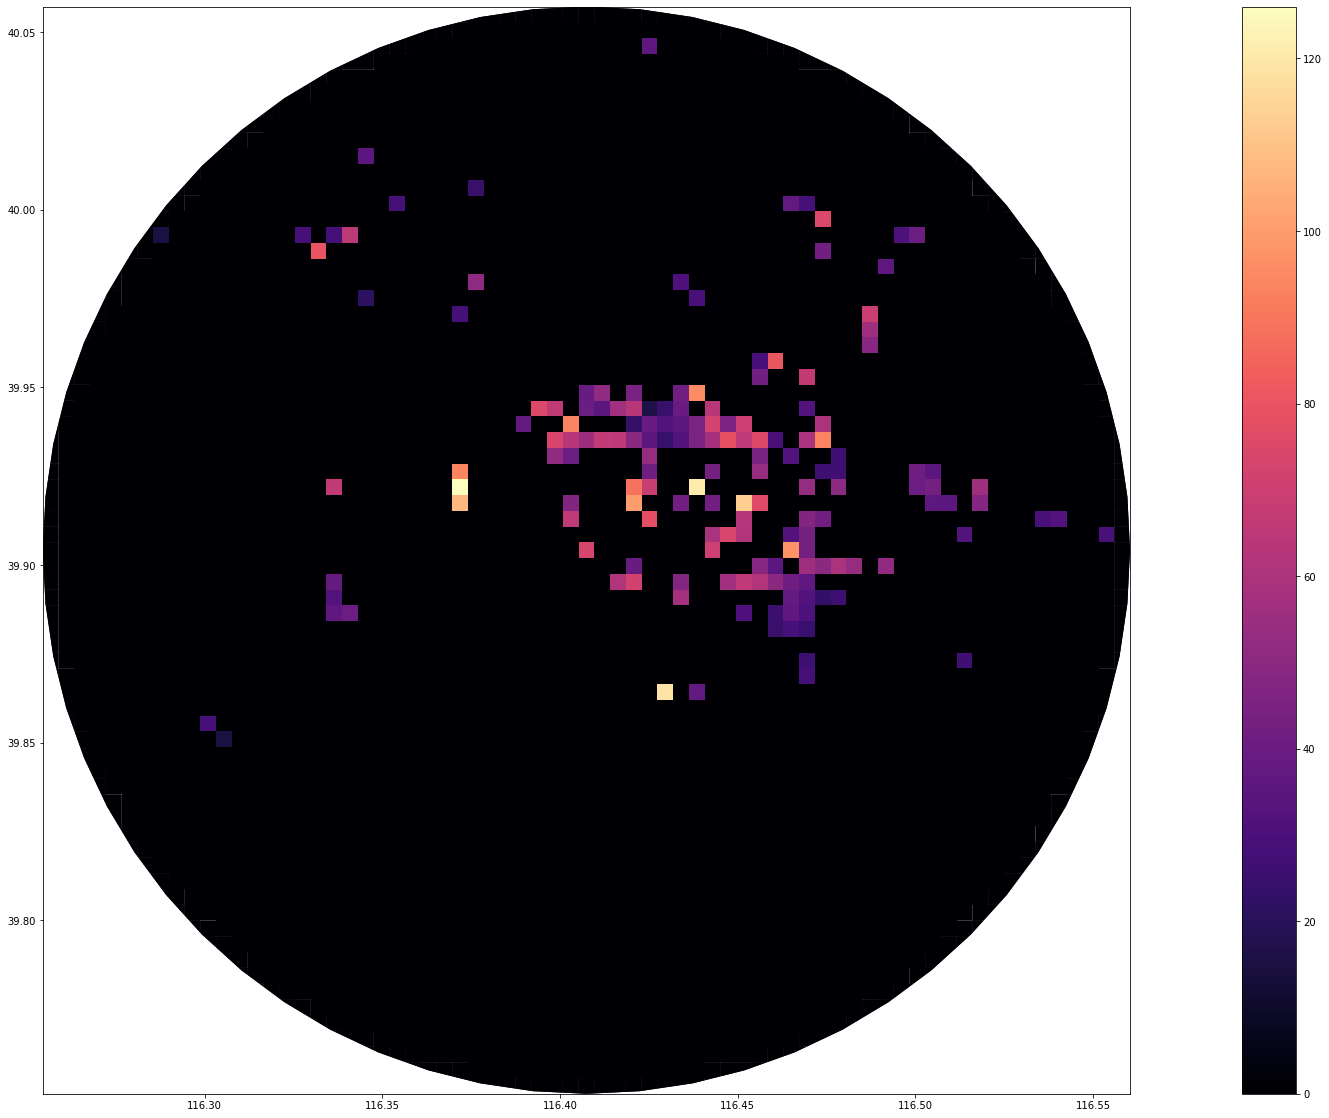

time: 14.9 s


In [4]:
data = pd.read_csv('data/Airbnb_Beijing.csv', header=0, index_col=0)
data = data[['room_id','latitude', 'longitude', 'bedrooms', 'price']]
print(len(data))

data.reset_index(drop=True, inplace=True)
print("data max index:", data.index.max())
print("number of NA prices:", data.price.isna().sum())

data.loc[data.bedrooms == 0, 'bedrooms'] = 1

price_proom = np.divide(np.array(data[pd.notnull(data['bedrooms'])].price),np.array(data[pd.notnull(data['bedrooms'])].bedrooms))
mean_bed = np.mean(price_proom)
print("average bedroom price",mean_bed)

nan_list = data[data.bedrooms.isna()].index.tolist()
data.loc[data.bedrooms.isna(), 'bedrooms'] = np.ceil(data.loc[data.bedrooms.isna(), 'price']/mean_bed)

geometry = [Point(xy) for xy in zip(data.longitude, data.latitude)]
#data = data.drop(['longitude', 'latitude'], axis=1)
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(data, crs=crs, geometry=geometry)

meter_500 = 0.00899928/2


# make the geometry a multipolygon if it's not already
geometry = city_union['geometry'].iloc[0]
if isinstance(geometry, Polygon):
    geometry = MultiPolygon([geometry])
    
# quadrat_width is in the units the geometry is in, so we'll do a tenth of a degree
geometry_cut = ox.quadrat_cut_geometry(geometry, quadrat_width=meter_500)

city_union['coords'] = city_union['geometry'].apply(lambda x: x.representative_point().coords[:])
city_union['coords'] = [coords[0] for coords in city_union['coords']]

polylist = [p for p in geometry_cut]


polyframe = gpd.GeoDataFrame(geometry=polylist)
polyframe.crs = city_union.geometry.crs
polyframe['center_lon'] = polyframe['geometry'].apply(lambda x: x.centroid.coords[0][0])
polyframe['center_lat'] = polyframe['geometry'].apply(lambda x: x.centroid.coords[0][1])


pointInPoly = gpd.sjoin(polyframe, gdf, op='contains')
print("pointinpoly length:",len(pointInPoly))

#pointInPoly.sort_values(['PlateID', 'Time'], inplace=True)
pointInPoly['index'] = pointInPoly.index
pointInPoly.reset_index(drop=True, inplace=True)


present_ind = list(pointInPoly['index_right'])
gdf_test_dropped = gdf.iloc[present_ind,:]
gdf_dropped = gdf_test_dropped.copy()
gdf_dropped.reset_index(drop=True, inplace=True)

print("check contains:",polyframe.iloc[pointInPoly.loc[len(pointInPoly)-1, 'index']].geometry.contains(gdf_dropped.loc[len(pointInPoly)-1,'geometry']))
gdf_dropped['pindex'] = pointInPoly['index']

print("check if there are NAs:", gdf_dropped.isna().values.any())

pindex = gdf_dropped.pindex.unique()
airbnb_dict = dict(gdf_dropped.pindex.value_counts())
counts = pd.DataFrame(list(airbnb_dict.items()), columns=['key', 'count'])
counts = counts[counts['count']>3]
counts = counts.copy()
airbnb_dict = dict(zip(list(counts['key']), list(counts['count'])))
polyair = polyframe.copy()
polyair['count'] = 0
polyair['count'].update(pd.Series(airbnb_dict))

# plot the city_union
west, south, east, north = city_union.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,26))
# for polygon, n in zip(geometry_cut, np.arange(len(polylist))):
#     p = polygon.representative_point().coords[:][0]
#     patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', zorder=2)
#     ax.add_patch(patch)
#     plt.annotate(s=n, xy=p,
#                  horizontalalignment='center', size=7)

polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='count',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()


gdf_dropped = gdf_dropped[gdf_dropped.pindex.isin(airbnb_dict.keys())]
gdf_dropped = gdf_dropped.copy()
gdf_dropped = gdf_dropped[gdf_dropped['price'] > 0]
gdf_dropped = gdf_dropped.copy()
gdf_dropped['price_normalized'] = gdf_dropped.price.divide(gdf_dropped.bedrooms)
gdf_dropped = gdf_dropped[gdf_dropped.price_normalized<270]
gdf_dropped = gdf_dropped.copy()
gdf_dropped.reset_index(drop=True, inplace=True)
gdf_dropped.price_normalized.hist(bins=100)

prices_dict = dict(gdf_dropped.groupby('pindex')['price_normalized'].mean())
from scipy import stats
hmean_prices_dict = dict(gdf_dropped.groupby('pindex')['price_normalized'].apply(lambda x: stats.hmean(x)))
median_prices_dict = dict(gdf_dropped.groupby('pindex')['price_normalized'].median())

polyair['prices'] = 0
polyair['hmean_prices'] = 0
polyair['median_prices'] = 0
polyair['prices'].update(pd.Series(prices_dict))
polyair['hmean_prices'].update(pd.Series(hmean_prices_dict))
polyair['median_prices'].update(pd.Series(median_prices_dict))


# plot the city_union
west, south, east, north = city_union.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,26))
# for polygon, n in zip(geometry_cut, np.arange(len(polylist))):
#     p = polygon.representative_point().coords[:][0]
#     patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', zorder=2)
#     ax.add_patch(patch)
#     plt.annotate(s=n, xy=p,
#                  horizontalalignment='center', size=7)

polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='prices',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()



# plot the city_union
west, south, east, north = city_union.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,30))
# for polygon, n in zip(geometry_cut, np.arange(len(polylist))):
#     p = polygon.representative_point().coords[:][0]
#     patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', zorder=2)
#     ax.add_patch(patch)
#     plt.annotate(s=n, xy=p,
#                  horizontalalignment='center', size=7)

polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='hmean_prices',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()


# plot the city_union
west, south, east, north = city_union.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,20))
# for polygon, n in zip(geometry_cut, np.arange(len(polylist))):
#     p = polygon.representative_point().coords[:][0]
#     patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', zorder=2)
#     ax.add_patch(patch)
#     plt.annotate(s=n, xy=p,
#                  horizontalalignment='center', size=7)

polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='median_prices',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()


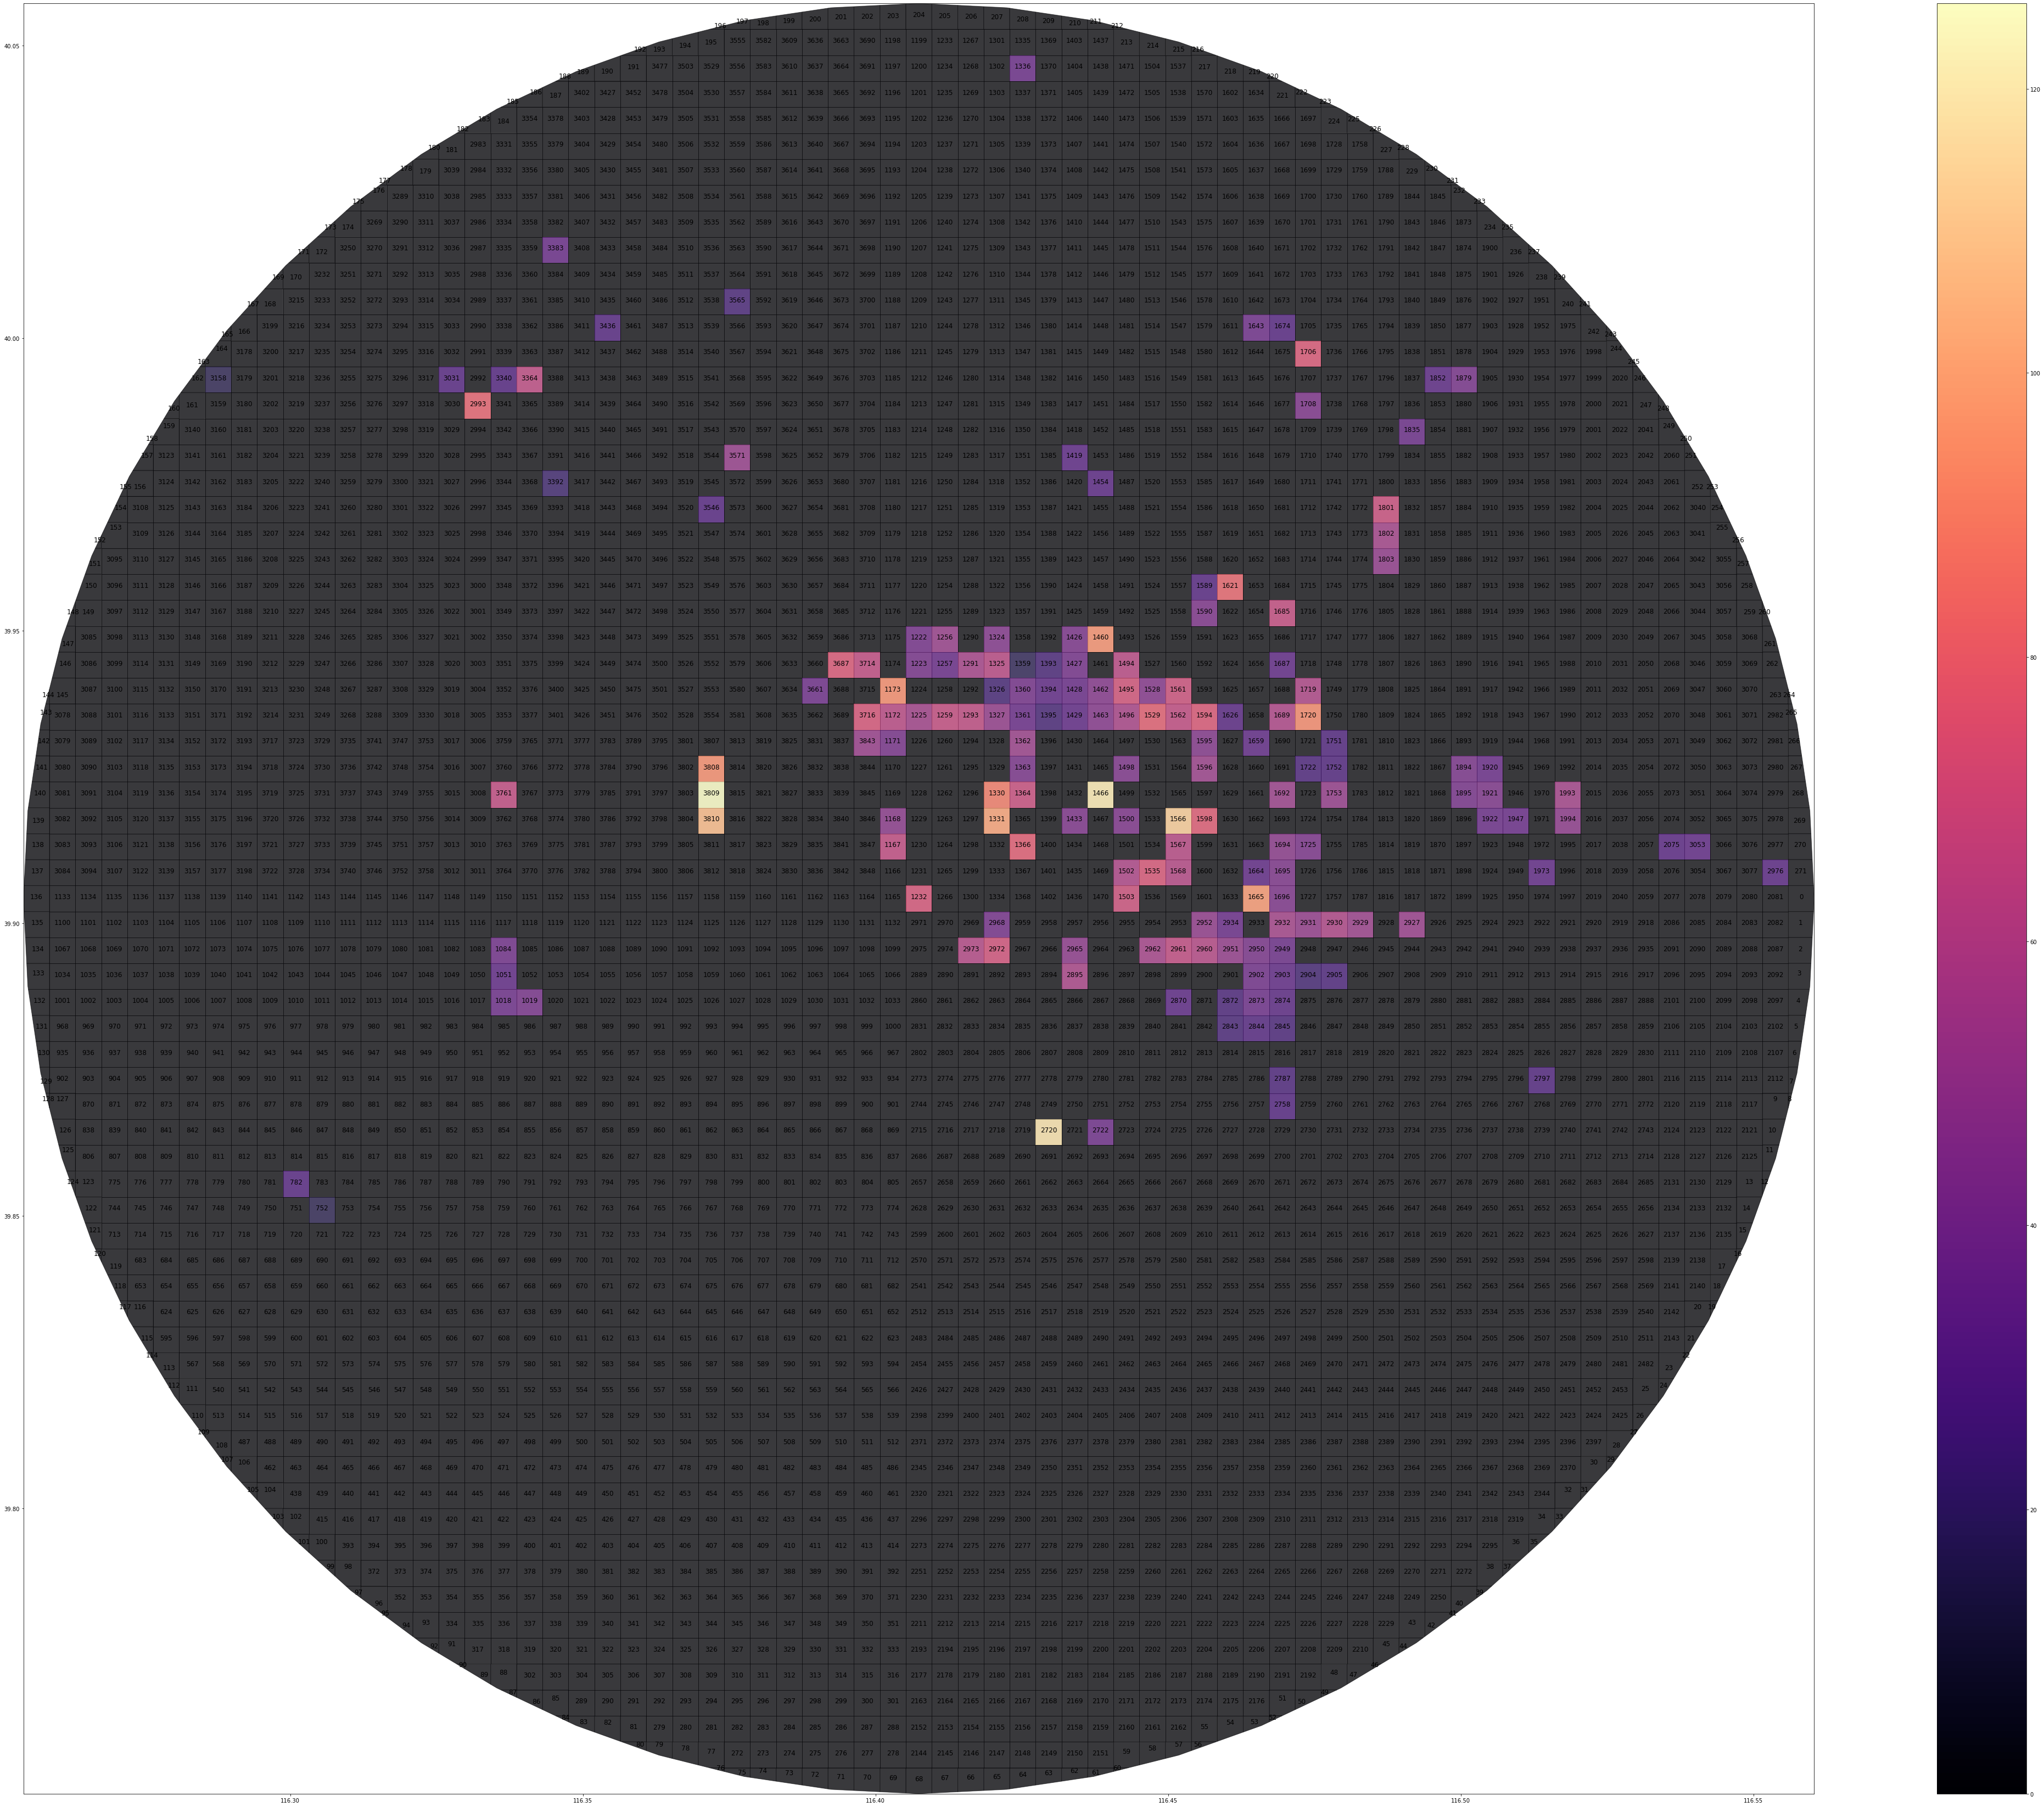

time: 38.2 s


In [5]:
# plot the city
west, south, east, north = city_union.unary_union.bounds
fig, ax = plt.subplots(figsize=(80,60))
for polygon, n in zip(geometry_cut, np.arange(len(polylist))):
    p = polygon.representative_point().coords[:][0]
    patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', alpha=0.5)
    ax.add_patch(patch)
    plt.annotate(s=n, xy=p,
                 horizontalalignment='center', size=12)
polyframe.plot(ax=ax, color='#000004', alpha=0.5)
polyair.plot(column='median_prices',  legend=True, cmap='magma', ax=ax, alpha=0.7, zorder=2)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

In [6]:
polyair.loc[polyair.index==2720, 'median_prices'] = 29
polyair.loc[polyair.index==2720, 'hmean_prices'] = 28
polyair.loc[polyair.index==2720, 'prices'] = 30

time: 4.98 ms


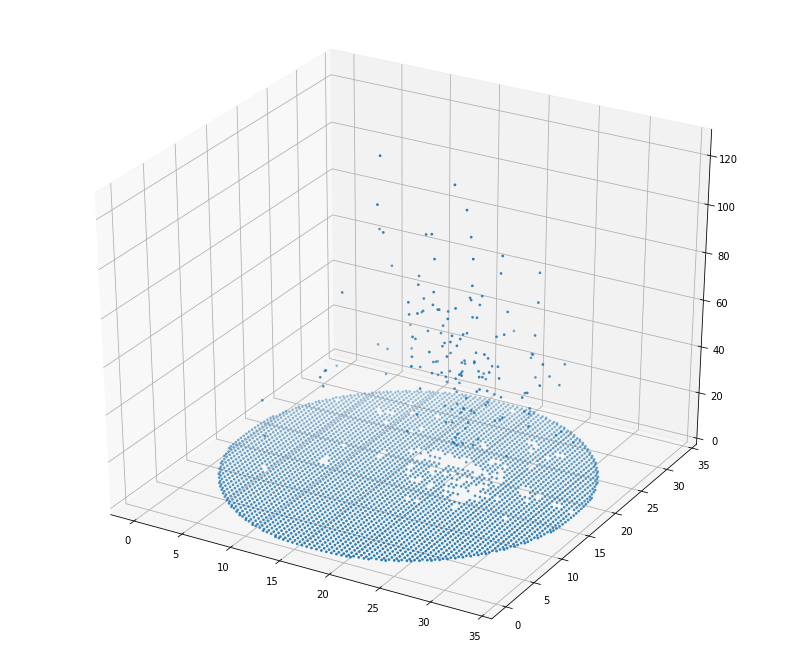

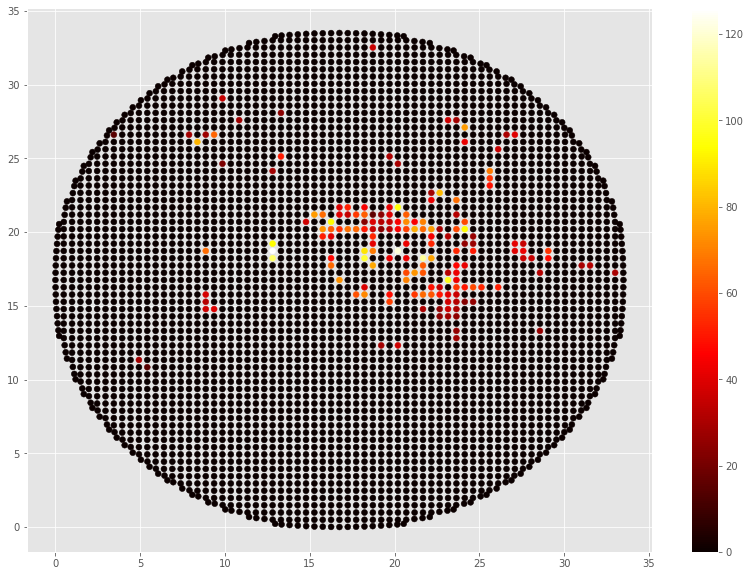

time: 2.68 s


In [7]:
import plotly.plotly as py
import plotly.graph_objs as go

# MatPlotlib
import matplotlib.pyplot as plt
from matplotlib import pylab
from mpl_toolkits.mplot3d import Axes3D
#x, y = np.array(polyair.center_lon), np.array(polyair.center_lat)

x = np.array(polyair.center_lon)*500/meter_500
x = x-x.min()
x = x/1000

y = np.array(polyair.center_lat)*500/meter_500 
y = y-y.min()
y = y/1000


# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure(figsize=(14,12))
ax = fig.gca(projection='3d')
ax.scatter(x, y, np.array(polyair.median_prices), cmap='plasma', s=3)
ax.set_zlim(0,np.max(np.array(polyair.median_prices))+2)
ax.view_init(30, 300)
plt.show()


plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(14,10))
scat = ax.scatter(x, y, c=np.array(polyair.median_prices), s=35, cmap='hot')
cbar = fig.colorbar(scat)
#cbar.set_clim(0, 250)
plt.savefig('images/Beijing_observed.jpg')
plt.show()

In [8]:
cdf = polyair[polyair.index.isin([1173, 1460,1466,1665,1706])]
cdf["cen_lon_km"] = cdf['center_lon'].apply(lambda x: (x*500/meter_500 - (polyair.center_lon*500/meter_500).min())/1000)
cdf["cen_lat_km"] = cdf['center_lat'].apply(lambda x: (x*500/meter_500 - (polyair.center_lat*500/meter_500).min())/1000)
cdf

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



geometry  center_lon  \
1173  POLYGON ((116.4051827860824 39.93745820870015,...  116.402966   
1460  POLYGON ((116.4362237808741 39.95076149216942,...  116.438441   
1466  POLYGON ((116.4362237808741 39.9241549252129, ...  116.438441   
1665  POLYGON ((116.4628303478306 39.90641721390855,...  116.465048   
1706  POLYGON ((116.4716992034828 39.99954019825638,...  116.473916   

      center_lat  count      prices  hmean_prices  median_prices  cen_lon_km  \
1173   39.939675      4   94.083333     83.568877           94.0   16.257856   
1460   39.948544      5   88.400000     80.865357           95.0   20.199885   
1466   39.921938      5  125.700000    122.384826          121.0   20.199885   
1665   39.904200      5   99.200000     98.646048           97.0   23.156407   
1706   39.997323      5   61.400000     46.464235           75.0   24.141914   

      cen_lat_km  
1173   20.692639  
1460   21.678146  
1466   18.721624  
1665   16.750610  
1706   27.098436

time: 367 ms


Fitted parameters:
[3.43562108e+01 1.84873390e+01 2.07691702e+01 2.88778637e+00
 7.30298290e-01 3.17401804e+00 4.47794243e+00 5.13480048e+01
 2.01995509e+01 1.87215372e+01 4.44694031e-01 9.90417987e-01
 2.32406933e+05 2.99777496e-01 5.01496271e+01 2.31777165e+01
 1.64974819e+01 8.94802882e-01 9.00358007e-01 3.89664523e+00
 5.39277691e-01]
RMS residual = 9.183779246409046


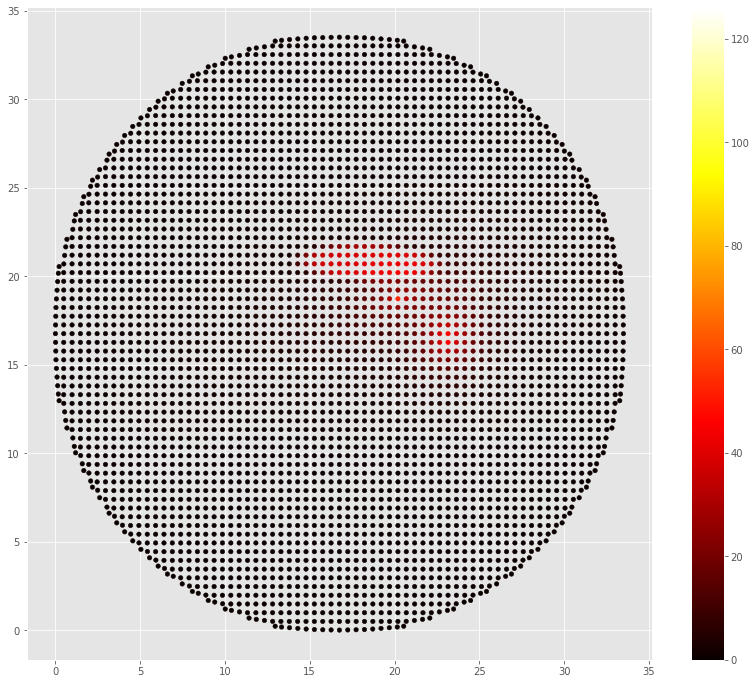

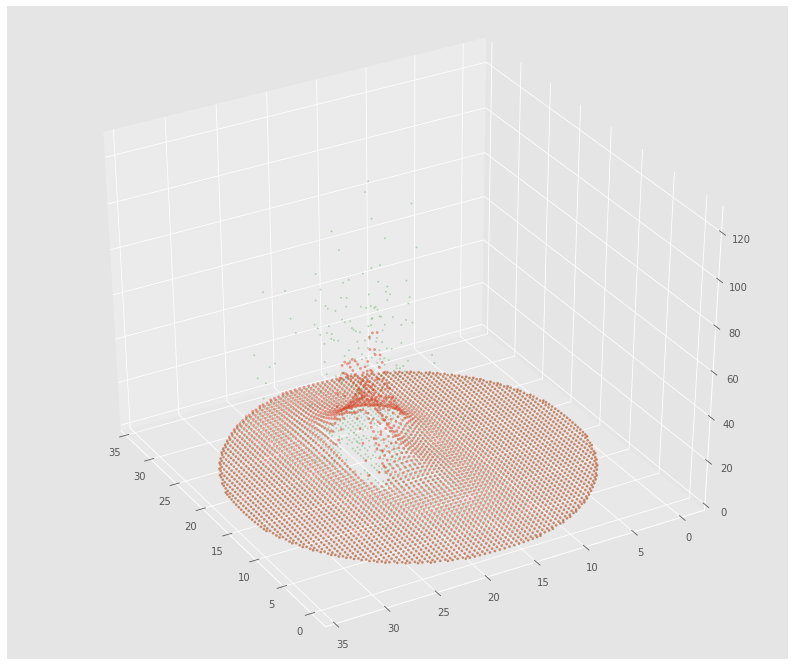

{'Beijing': 1.77233254047711}
time: 2.03 s


In [9]:
alphas = {}
xy = np.vstack([x, y])
zobs = np.array(polyair.median_prices)
#zobs = np.where(zobs>0, zobs, 0.1*zobs.max())
import scipy.optimize as opt
import matplotlib.pyplot as plt

def _gaussian(M, *args):
    xy = M
    arr = np.zeros(len(zobs))
    for i in range(len(args)//7):
        arr += twoD_Gaussian_alpha(xy, *args[i*7:i*7+7])
    return arr


guess_prms = [(94,16.257856, 20.692639, 2, 1,3, 1.5),
              #(95,20.199885,21.678146, 3, 1,4, 1.5),
              (121,20.199885,18.721624, 1, 1,2, 1.5),
              (97,23.156407,16.750610, 1, 2,4, 1.5),
              #(75,24.141914,27.098436, 1.25, 1.16,1.87)
             ]
# Flatten the initial guess parameter list.
p0 = [p for prms in guess_prms for p in prms]

def twoD_Gaussian_alpha(xy, amplitude, xo, yo, sigma_x, sigma_y, theta, alpha):
    x, y = xy
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2))**alpha)
    return g.ravel()
popt, pcov = opt.curve_fit(_gaussian, xy, zobs, p0)
#pred_params, uncert_cov = opt.curve_fit(gauss2d, xy, zobs, p0=guess)

zpred = np.zeros(len(zobs))
for i in range(len(popt)//7):
    zpred += twoD_Gaussian_alpha(xy, *popt[i*7:i*7+7])

# for i in range(len(popt)//5):
#     fit += gaussian(X, Y, *popt[i*5:i*5+5])
print('Fitted parameters:')
print(popt)

rms = np.sqrt(np.mean((zobs - zpred)**2))
print('RMS residual =', rms)


fig, ax = plt.subplots(figsize=(14,12))
scat = ax.scatter(x, y, c=zpred, vmin=0, vmax=zobs.max(), s=20, cmap='hot')
fig.colorbar(scat)
plt.savefig('Beijing_fitted.jpg')
plt.show()


#x, y = np.array(polyair.center_lon), np.array(polyair.center_lat)
# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure(figsize=(14,12))
ax = fig.gca(projection='3d')
ax.scatter(x, y, zpred, cmap='plasma', s=5, alpha=0.5)
ax.scatter(x, y, zobs, color='green', s=2, alpha=0.2)
ax.set_zlim(0,np.max(np.array(polyair.median_prices))+2)
ax.view_init(35, 150)
plt.show()

alphas['Beijing'] = np.mean(popt[6::7])
print(alphas)

In [10]:
import pickle
pickle_in = open("alphas.pickle","rb")
alphas_dict = pickle.load(pickle_in)
#prices_params_dict = {}
alphas_dict['Beijing'] = alphas['Beijing']
print(alphas_dict)
pickle_out = open("alphas.pickle","wb")
pickle.dump(alphas_dict, pickle_out)
pickle_out.close()

{'Paris': 1.9119263949210794, 'Amsterdam': 1.6077156181165682, 'Stockholm': 1.4869621148124246, 'Arezzo': 1.5291330654483044, 'Berlin': 1.3281036059479567, 'Bordeaux': 1.387341915093677, 'Denver': 0.9886695315944182, 'Edinburgh': 1.7431661910906637, 'Lyon': 1.840995035260712, 'Madrid': 1.561423826026336, 'Buenos_Aires': 2.0626361633770363, 'Los_Angeles': 1.7386638625850566, 'Beijing': 1.77233254047711, 'Florence': 1.052999973906332, 'Moscow': 1.822610958759147, 'Porto': 1.4172416677632145, 'Prague': 1.3671832768992007, 'Reykjavik': 1.4194582940670377, 'Riga': 1.4587192546215861, 'Rome': 1.8608390724186512, 'Seoul': 1.3208669147673713, 'Siena': 0.6212787996336754, 'Sydney': 2.584174464016137, 'Tallin': 2.014994948135572, 'Treviso': 1.07320426583068, 'Valencia': 1.5432619, 'Venezia': 1.3156028460923, 'Verona': 1.4364606330705336, 'Vicenza': 1.20971848439062, 'Vienna': 1.3399164167136137, 'Wellington': 1.46363348, 'Zurich': 1.72383878, 'Aarhus': 1.87621535, 'Milan': 2.1468310347956194, 'B

Fitted parameters:
[3.85373183e+01 1.89706135e+01 2.06578499e+01 2.94089992e+00
 5.92543560e-01 3.21495954e+00 1.75582704e+02 2.06772946e+01
 1.93937822e+01 5.94428470e-02 9.37520788e-01 3.79096766e+00
 1.30544332e+01 2.02454972e+01 1.87480750e+01 5.09193479e+00
 2.28969593e+00 2.53405258e+06 3.33992317e+01 2.29164169e+01
 1.60932377e+01 1.40117931e+00 1.08296431e+00 3.73997827e+00]
RMS residual = 9.10376327899833


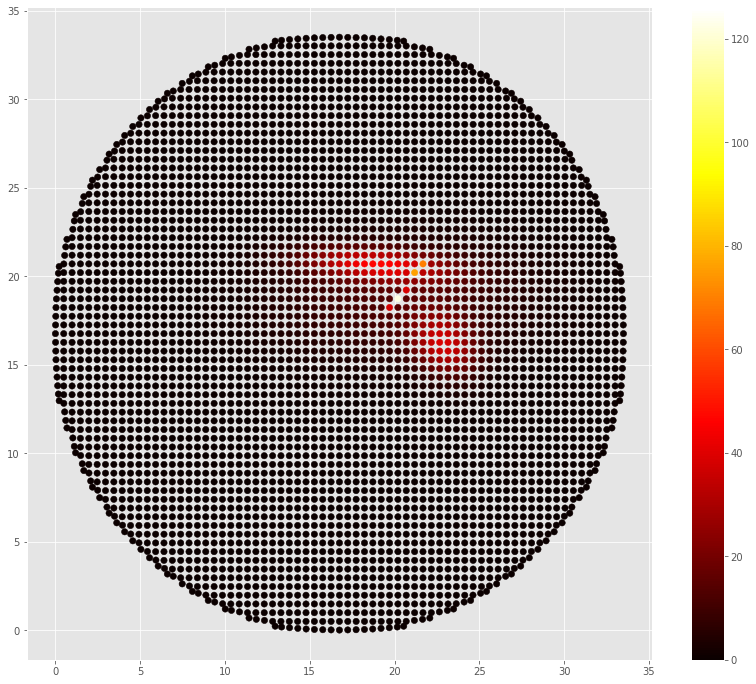

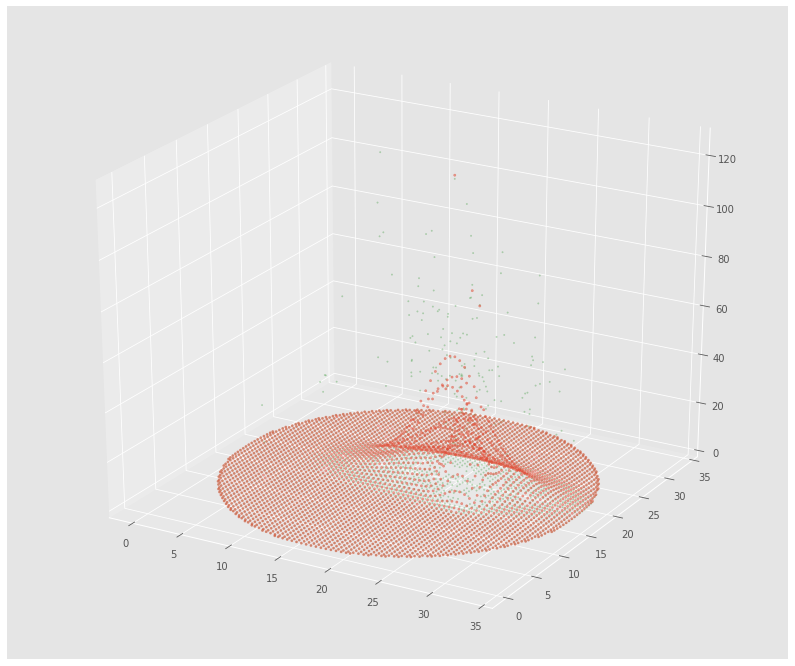

time: 1.82 s


In [11]:
xy = np.vstack([x, y])
zobs = np.array(polyair.median_prices)
#zobs = np.where(zobs>0, zobs, 0.1*zobs.max())
import scipy.optimize as opt
import matplotlib.pyplot as plt

def _gaussian(M, *args):
    xy = M
    arr = np.zeros(len(zobs))
    for i in range(len(args)//6):
        arr += twoD_Gaussian(xy, *args[i*6:i*6+6])
    return arr


guess_prms = [(94,16.257856, 20.692639, 2, 1,3),
              (95,20.199885,21.678146, 3, 1,4),
              (121,20.199885,18.721624, 1, 1,2),
              (97,23.156407,16.750610, 1, 2,4),
              #(75,24.141914,27.098436, 1.25, 1.16,1.87)
             ]

# Flatten the initial guess parameter list.
p0 = [p for prms in guess_prms for p in prms]

def twoD_Gaussian(xy, amplitude, xo, yo, sigma_x, sigma_y, theta):
    x, y = xy
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()
popt, pcov = opt.curve_fit(_gaussian, xy, zobs, p0)
#pred_params, uncert_cov = opt.curve_fit(gauss2d, xy, zobs, p0=guess)

zpred = np.zeros(len(zobs))
for i in range(len(popt)//6):
    zpred += twoD_Gaussian(xy, *popt[i*6:i*6+6])

# for i in range(len(popt)//5):
#     fit += gaussian(X, Y, *popt[i*5:i*5+5])
print('Fitted parameters:')
print(popt)

rms = np.sqrt(np.mean((zobs - zpred)**2))
print('RMS residual =', rms)


fig, ax = plt.subplots(figsize=(14,12))
scat = ax.scatter(x, y, c=zpred, vmin=0, vmax=zobs.max(), s=40, cmap='hot')
fig.colorbar(scat)
plt.savefig('Beijing_fitted.jpg')
plt.show()


#x, y = np.array(polyair.center_lon), np.array(polyair.center_lat)
# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure(figsize=(14,12))
ax = fig.gca(projection='3d')
ax.scatter(x, y, zpred, cmap='plasma', s=5, alpha=0.5)
ax.scatter(x, y, zobs, color='green', s=2, alpha=0.2)
ax.set_zlim(0,np.max(np.array(polyair.median_prices))+2)
ax.view_init(25, 300)
plt.show()

In [12]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

sqrt_eigs_long = np.array([])
sqrt_eigs_short = np.array([])
for i in range(0, len(popt), 6):
    a = (np.cos(popt[i+5])**2)/(2*popt[i+3]**2) + (np.sin(popt[i+5])**2)/(2*popt[i+4]**2)
    b = -(np.sin(2*popt[i+5]))/(4*popt[i+3]**2) + (np.sin(2*popt[i+5]))/(4*popt[i+4]**2)
    c = (np.sin(popt[i+5])**2)/(2*popt[i+3]**2) + (np.cos(popt[i+5])**2)/(2*popt[i+4]**2)
    cov = np.array([a, b, b, c]).reshape(-1, 2)
    print("Is cov_{} positive definite?: ".format(i//6+1), is_pos_def(cov))
    eigenvalues = np.linalg.eigvals(cov)
    eigenvalues = eigenvalues[eigenvalues>0]
    if eigenvalues.size!=0:
        stds = np.sqrt(eigenvalues)/popt[i]
        #stds = stds[stds>=0]
        sqrt_eigs_long = np.append(sqrt_eigs_long,max(stds))
        sqrt_eigs_short = np.append(sqrt_eigs_short,min(stds))

print('long stds: ', sqrt_eigs_long, 'mean: ', np.mean(sqrt_eigs_long))
print('short stds: ', sqrt_eigs_short, 'mean: ', np.mean(sqrt_eigs_short))

Is cov_1 positive definite?:  True
Is cov_2 positive definite?:  True
Is cov_3 positive definite?:  True
Is cov_4 positive definite?:  True
long stds:  [0.03096587 0.06774912 0.02365643 0.01954944] mean:  0.03548021455387483
short stds:  [0.00623912 0.00429559 0.01063761 0.01510966] mean:  0.009070495145543242
time: 32 ms


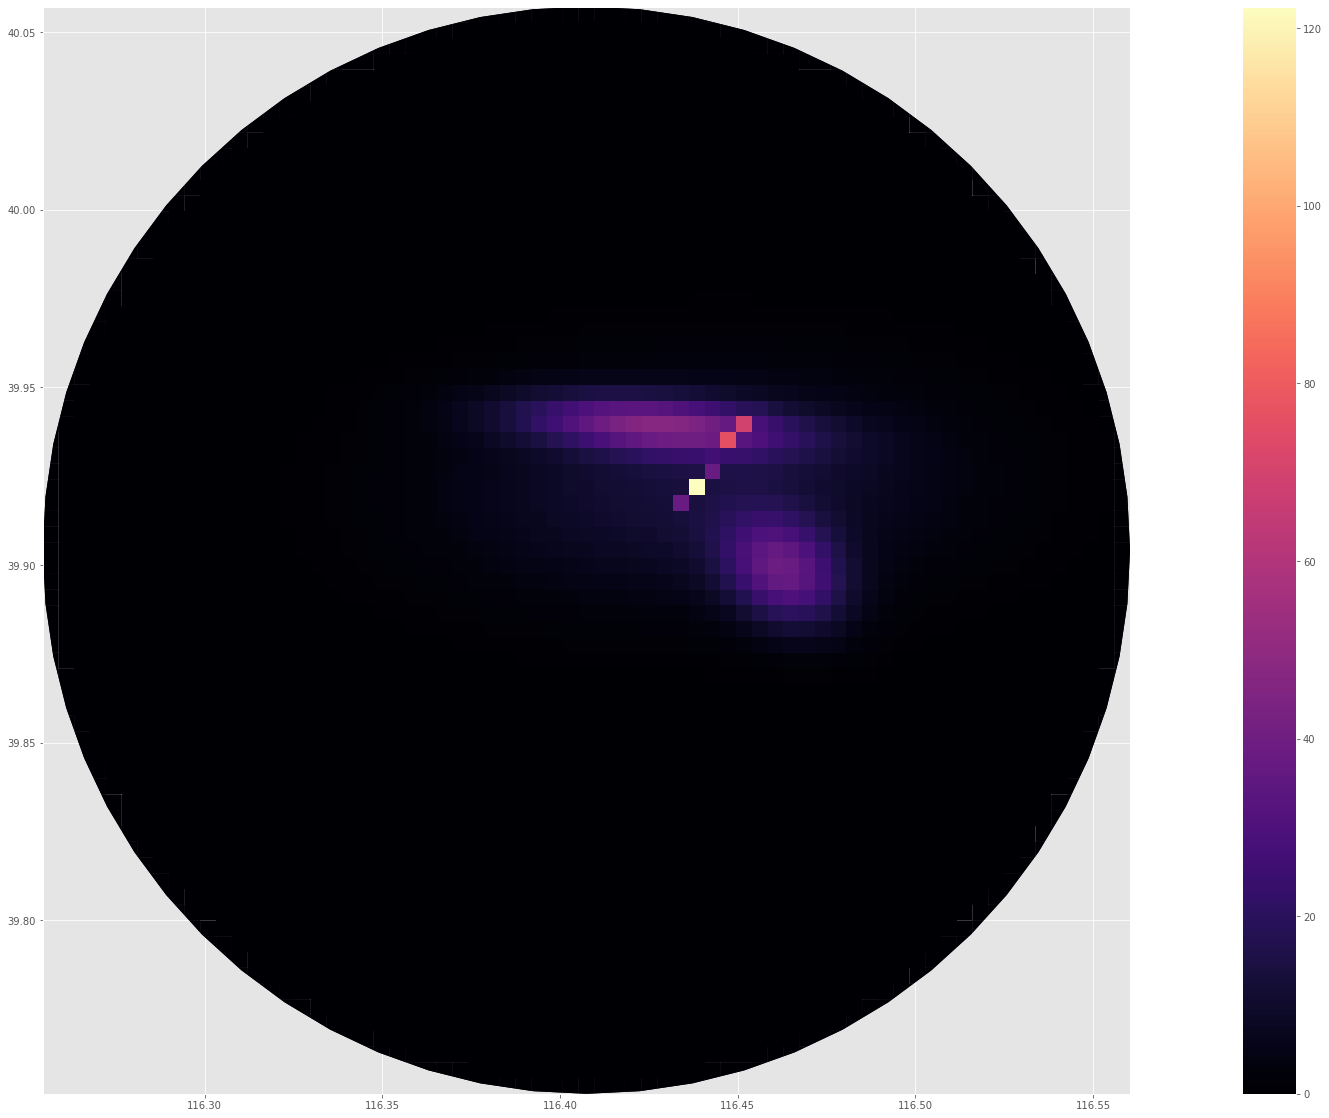

time: 1.79 s


In [13]:
polyair['zpred'] = zpred
# plot the city
west, south, east, north = city_union.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,20))

polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='zpred',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

In [14]:
import pickle
pickle_in = open("Prices_params.pickle","rb")
prices_params_dict = pickle.load(pickle_in)
#prices_params_dict = {}
prices_params_dict['Beijing'] = popt
pickle_out = open("Prices_params.pickle","wb")
pickle.dump(prices_params_dict, pickle_out)
pickle_out.close()

#average_slopes = {}
pickle_in_long = open("Average_price_slopes_long.pickle","rb")
average_slopes_long = pickle.load(pickle_in_long)
average_slopes_long['Beijing'] = np.mean(sqrt_eigs_long)
pickle_out_long = open("Average_price_slopes_long.pickle","wb")
pickle.dump(average_slopes_long, pickle_out_long)
pickle_out_long.close()

pickle_in_short = open("Average_price_slopes_short.pickle","rb")
average_slopes_short = pickle.load(pickle_in_short)
average_slopes_short['Beijing'] = np.mean(sqrt_eigs_short)
pickle_out_short = open("Average_price_slopes_short.pickle","wb")
pickle.dump(average_slopes_short, pickle_out_short)
pickle_out_short.close()

print('long: ', average_slopes_long, '\n', '\n', ' short: ', average_slopes_short)

long:  {'Paris': 0.010453121182320417, 'Amsterdam': 0.017790862401138207, 'Stockholm': 0.01160078748441716, 'Arezzo': 0.012661960610292892, 'Berlin': 0.017168942092868542, 'Bordeaux': 0.0057209390468692745, 'Denver': 0.00873766709683174, 'Edinburgh': 0.012921100209712873, 'Lyon': 0.00594530194011358, 'Madrid': 0.01315080289968449, 'Buenos_Aires': 0.00938788752473718, 'Palermo': 0.02659431146972356, 'Los_Angeles': 0.0056655377791732745, 'Beijing': 0.03548021455387483, 'Florence': 0.011913882705309832, 'Moscow': 0.026524810524746, 'Porto': 0.03745056113103571, 'Prague': 0.01850581507565583, 'Reykjavik': 0.04000475004839031, 'Riga': 0.02150786435094239, 'Rome': 0.009635062558537275, 'Seoul': 0.013154650694260608, 'Siena': 0.013838139160990736, 'Sydney': 0.009200022664460229, 'Tallin': 0.024848430854086192, 'Treviso': 0.015264513943951563, 'Valencia': 0.01982718757582555, 'Venezia': 0.013133572970121148, 'Verona': 0.01119208328282184, 'Vicenza': 0.029546407262138693, 'Vienna': 0.0120270170

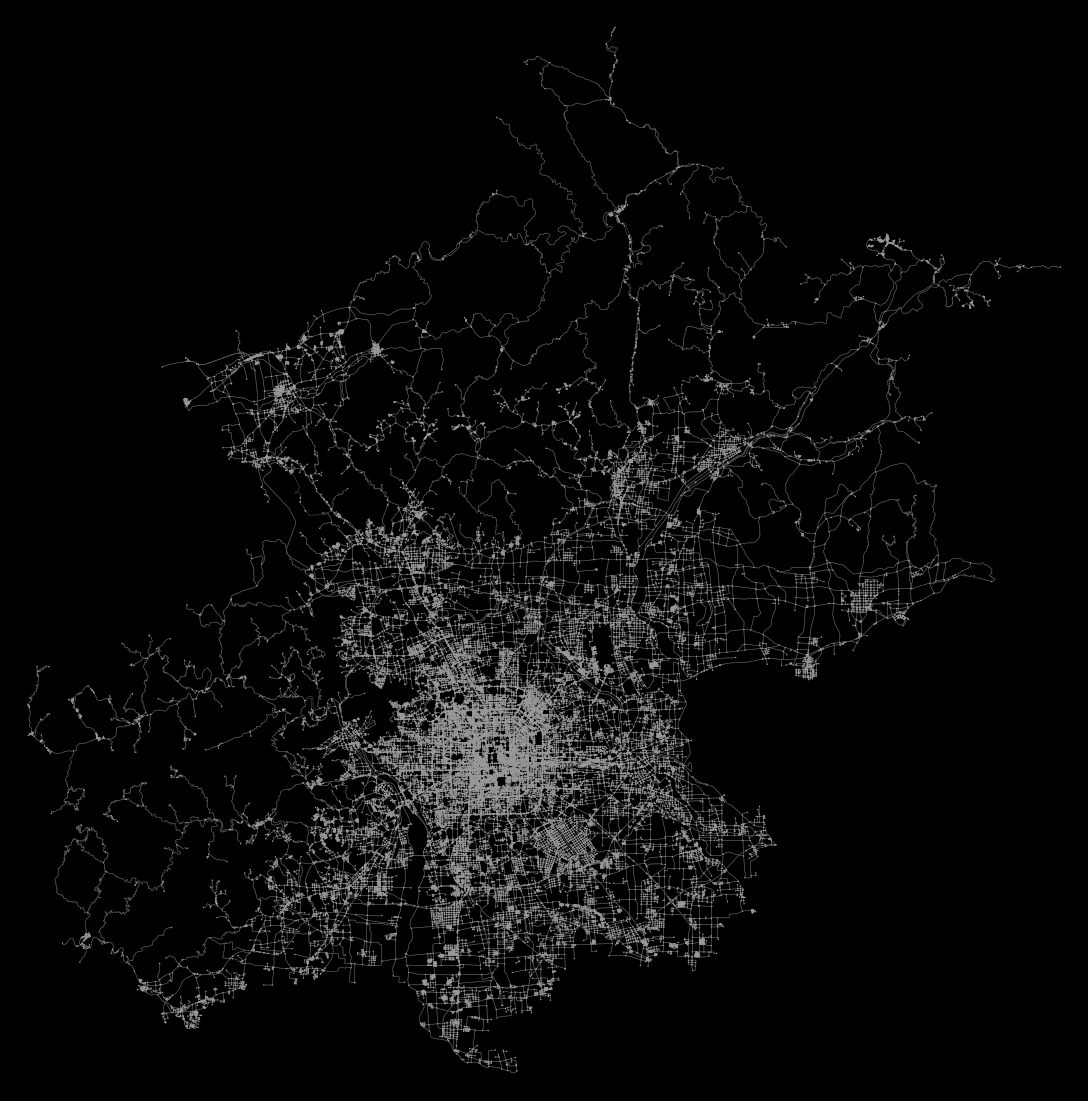

time: 2min 38s


In [15]:
# download and project a street network
G = ox.graph_from_place('Beijing, China', network_type="drive")
#G = ox.project_graph(G)
fig, ax = ox.plot_graph(G, fig_height=20, bgcolor='k', node_size=2, node_color='#999999', node_edgecolor='none', node_zorder=2,
                        edge_color='#555555', edge_linewidth=0.5, edge_alpha=1)

In [16]:
centers = {}
for i in range(0, len(popt), 6):
    lon = popt[i+1]*1000 + (np.array(polyair.center_lon)*500/meter_500).min()
    lon = lon*meter_500/500
    lat = popt[i+2]*1000 + (np.array(polyair.center_lat)*500/meter_500).min()
    lat = lat*meter_500/500
    centers['center_node_{}'.format(i//6+1)] = ox.get_nearest_node(G, (lat,lon))

centers

{'center_node_1': 332616019,
 'center_node_2': 2022785479,
 'center_node_3': 35551198,
 'center_node_4': 2366975923}

time: 446 ms


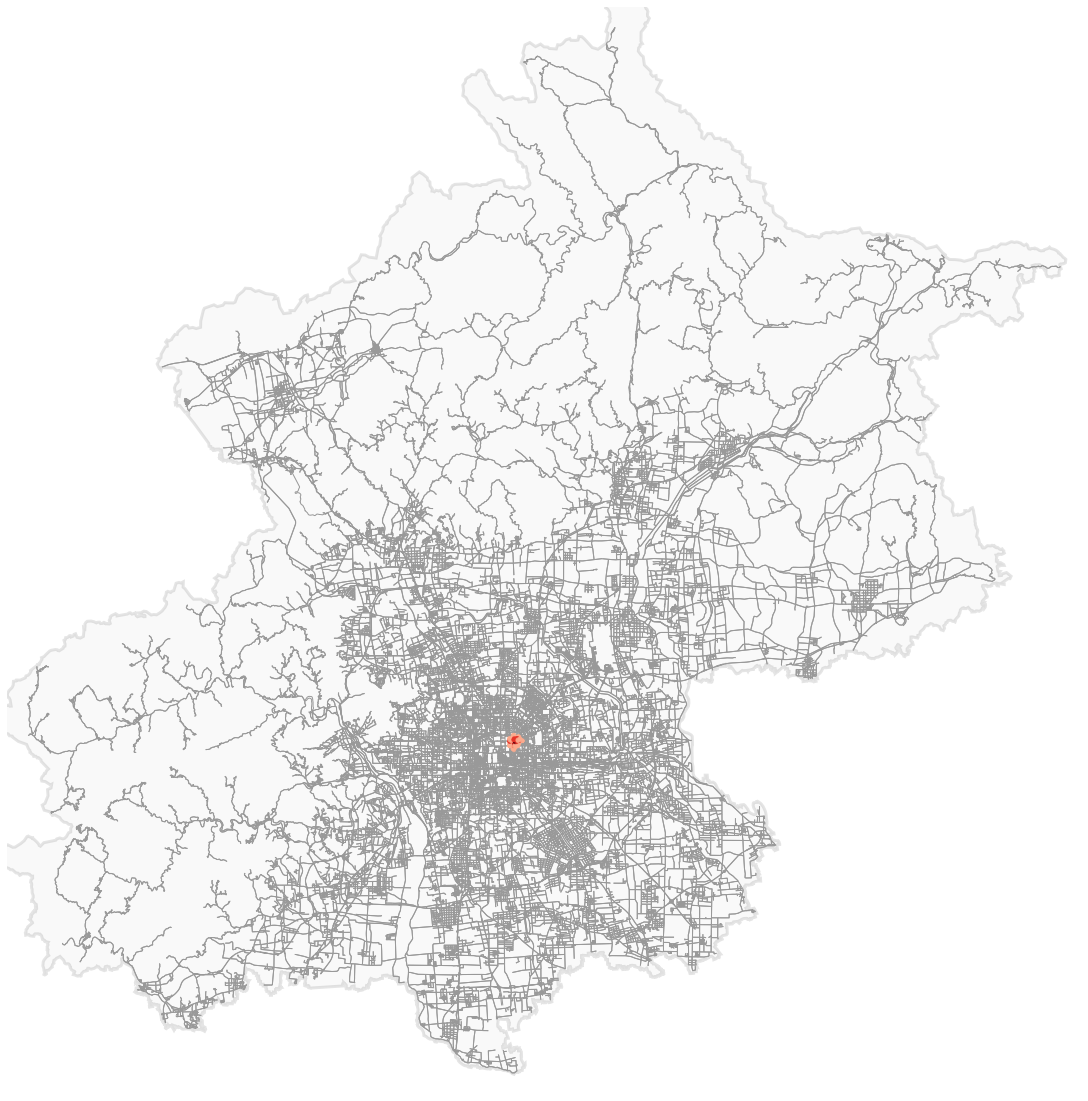

time: 27.1 s


In [17]:
import networkx as nx
#center_node = ox.get_nearest_node(G, (popt[8],popt[7]))
center_node = centers['center_node_1']
# list of distances from center
dists = np.arange(500, 2000, 500)
dists

# get one color for each isochrone
iso_colors = ox.get_colors(n=len(dists), cmap='Reds', start=0.3, return_hex=True)
# color the nodes according to isochrone then plot the street network
node_colors = {}
for dist, color in zip(sorted(dists, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=dist, distance='length')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [20 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, fig_height=20,show=False, close=False, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2)
plt.close()
# to this matplotlib axis, add the place shape as descartes polygon patches
for geometry in city['geometry'].tolist():
    if isinstance(geometry, (Polygon, MultiPolygon)):
        if isinstance(geometry, Polygon):
            geometry = MultiPolygon([geometry])
        for polygon in geometry:
            patch = PolygonPatch(polygon, fc='#cccccc', ec='k', linewidth=3, alpha=0.1, zorder=-1)
            ax.add_patch(patch)
            
fig

3849
3849 559
Number of cells with price above 5th percentile:  559



[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.00443443 0.00886886]
 [0.         0.         0.         ... 0.         0.         0.00443443]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Yes


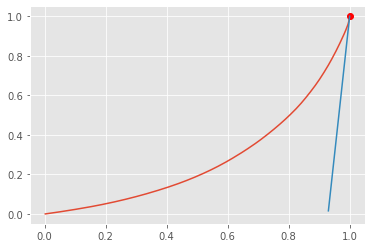

Loubar price:  30.716705642633897
Average price:  11.701706697805417
average city distance:  6586.560663166117
eta =  0.5157280534065634
time: 15.4 s


In [21]:
from tqdm import tqdm_notebook

#poly_prices = polyair[polyair.median_prices>0]
poly_prices = polyair.copy()
print(len(poly_prices))
poly_prices['zpred'] = zpred

lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
keys = np.array(keys)

vals_cut = vals[vals>0.02*vals.max()]
print(len(vals), len(vals_cut))

L = np.cumsum(vals_cut)/np.sum(vals_cut)
keys = keys[vals>0.02*vals.max()]
print('Number of cells with price above 5th percentile: ', len(keys))



mat = np.zeros(shape=(len(geometry_cut), len(geometry_cut)))
for pair in tqdm_notebook(combinations(sorted(keys), 2)):
    mat[pair[0], pair[1]] = geometry_cut[pair[0]].centroid.distance(geometry_cut[pair[1]].centroid)
    
print(mat)


def isuppertriangular(M): 
    for i in range(1, len(M)): 
        for j in range(0, i): 
            if(M[i][j] != 0):  
                    return False
    return True

  
if isuppertriangular(mat): 
    print ("Yes") 
else: 
    print ("No") 
    
    
L1= L
F1 = np.arange(1, len(L1)+1)/len(L1)

L1 = (L1 - L1.min())/(L1.max()-L1.min())

from scipy import interpolate
tck = interpolate.splrep(F1,L1)
x0_1 =1
y0_1 = interpolate.splev(x0_1,tck)
dydx = interpolate.splev(x0_1,tck,der=1)
tngnt1 = lambda x: dydx*x + (y0_1-dydx*x0_1)
plt.plot(F1, L1)
plt.plot(x0_1,y0_1, "or")
plt.plot(F1[tngnt1(F1)>0],tngnt1(F1[tngnt1(F1)>0]), label="tangent")
plt.show()

indlist = poly_prices.index.tolist()

loubar_val = vals_cut[np.where(tngnt1(F1)>0)[0][0]]

print('Loubar price: ', loubar_val)
print('Average price: ', np.mean(vals_cut))

if loubar_val > np.mean(vals_cut):
    loubar_keys = keys[vals_cut>loubar_val]
else:
    loubar_keys = keys[vals_cut>np.mean(vals_cut)]
#loubar_keys = keys[vals_cut>loubar_val]
dist_mat = mat[keys.reshape(-1,1), keys]

total_dist = dist_mat.sum()
dist_corr = dist_mat[dist_mat>0]

loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]
loubar_dist = loubar_dist_mat.sum()

loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
eta_loubar = loubar_dist_corr.mean()/dist_corr.mean()

x = np.array(polyair.center_lon)*500/meter_500
x = x-x.min()
x = x/1000

avg_dist_meters = (dist_corr.mean()/0.00899928)*1000
print('average city distance: ', avg_dist_meters)
print('eta = ', eta_loubar)

In [19]:
pickle_in = open("City_spreading_index.pickle","rb")
spreading_index_dict = pickle.load(pickle_in)
#spreading_index_dict = {}
spreading_index_dict['Beijing'] = eta_loubar


pickle_out = open("City_spreading_index.pickle","wb")
pickle.dump(spreading_index_dict, pickle_out)
pickle_out.close()

spreading_index_dict

{'Paris': 0.7251609142253275,
 'Amsterdam': 0.6513935879350918,
 'Stockholm': 0.6839327295656318,
 'Arezzo': 0.5574311537992848,
 'Berlin': 0.7499866909236614,
 'Bordeaux': 0.5818334466519048,
 'Denver': 0.6312111392217781,
 'Edinburgh': 0.6813298654934006,
 'Lyon': 0.6138305864151811,
 'Madrid': 0.6426066210787698,
 'Buenos_Aires': 0.8337988194080271,
 'Palermo': 0.8841435007903967,
 'Los_Angeles': 0.7889452782510832,
 'Beijing': 0.6425383574699105,
 'Florence': 0.5049117106731263,
 'Moscow': 0.6925493573699144,
 'Porto': 0.7058843952576399,
 'Prague': 0.5522963433539414,
 'Reykjavik': 0.8276260142343259,
 'Riga': 0.6850021296374689,
 'Rome': 0.5803964773671335,
 'Seoul': 0.8924742030382572,
 'Siena': 0.5646389917673048,
 'Sydney': 0.7909301400958108,
 'Tallin': 0.5690189423395199,
 'Treviso': 0.5345662066021125,
 'Valencia': 0.6956994914059091,
 'Venezia': 0.656650370883064,
 'Verona': 0.5707647012625697,
 'Vicenza': 0.5117751186840898,
 'Vienna': 0.6189242538490607,
 'Wellington': 0

time: 8.98 ms


In [22]:
pickle_in = open("avg_distances_dict.pickle","rb")
avg_distances_dict = pickle.load(pickle_in)
#avg_distances_dict = {}
avg_distances_dict['Beijing'] = avg_dist_meters


pickle_out = open("avg_distances_dict.pickle","wb")
pickle.dump(avg_distances_dict, pickle_out)
pickle_out.close()

avg_distances_dict

{'Venezia': 2398.636425932576,
 'Verona': 3141.8502884813342,
 'Vicenza': 1988.2224372858566,
 'Vienna': 5125.89366602888,
 'Wellington': 2806.4963410749997,
 'Zurich': 2068.4583585914684,
 'Aarhus': 2857.919349359045,
 'Milan': 6008.128043000454,
 'Busan': 7348.804402235624,
 'Valencia': 4090.433301180094,
 'Bologna': 2104.4589605649485,
 'Barcelona': 4218.232625020259,
 'Bremen': 3772.1380465457137,
 'Brno': 2231.9772664038364,
 'Budapest': 3463.3335339061914,
 'Dublin': 4138.1465107736385,
 'Boston': 5610.60832524716,
 'Rio': 8357.334811118957,
 'NY': 8563.096975538809,
 'Ottawa': 2220.3476963993976,
 'Nashville': 5606.900406329212,
 'New_Orleans': 5048.047130029565,
 'Shanghai': 5452.583570486633,
 'Portland': 5406.388840795854,
 'Amsterdam': 7020.480387015727,
 'Arezzo': 1662.0178383704194,
 'Beijing': 6586.560663166117}

time: 4.98 ms


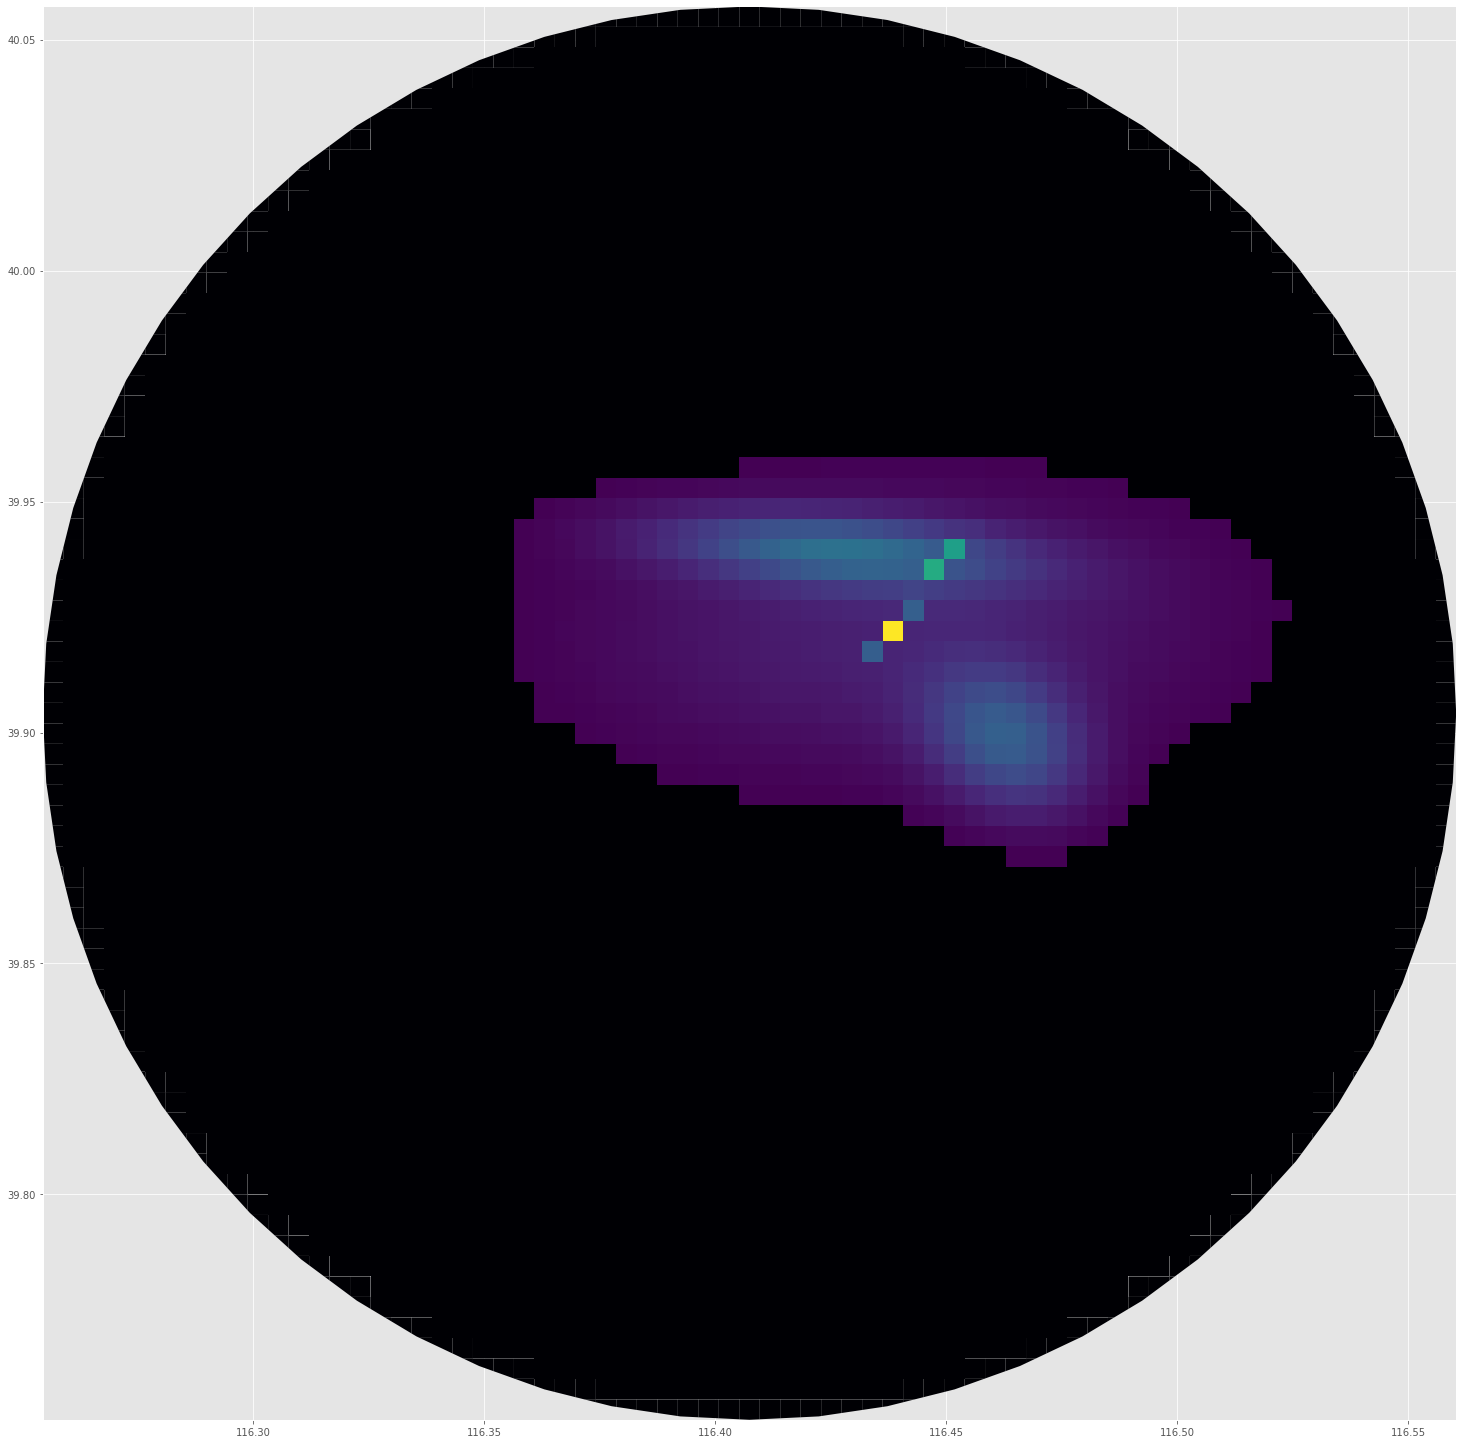

time: 1.35 s


In [23]:
# plot the city
west, south, east, north = city_union.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,26))

polyframe.plot(ax=ax, color='#000004')
#polyair.plot(column='prices',  legend=True, cmap='magma', ax=ax)    
poly_prices[poly_prices.index.isin(keys)].plot(ax=ax, column='zpred')
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

In [24]:
lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    
print(len(keys))
vals = np.array(vals)
keys = np.array(keys)
keys = keys[vals>=0.01*vals.max()]
print(len(keys))

indlist = poly_prices.index.tolist()
mat = np.zeros(shape=(len(geometry_cut), len(geometry_cut)))
for pair in tqdm_notebook(combinations(sorted(keys), 2)):
    mat[pair[0], pair[1]] = geometry_cut[pair[0]].centroid.distance(geometry_cut[pair[1]].centroid)

print(mat)


def isuppertriangular(M): 
    for i in range(1, len(M)): 
        for j in range(0, i): 
            if(M[i][j] != 0):  
                    return False
    return True


if isuppertriangular(mat): 
    print ("Yes") 
else: 
    print ("No")

3849
746



[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.00443443 0.00886886]
 [0.         0.         0.         ... 0.         0.         0.00443443]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Yes
time: 23.8 s


In [28]:
zpred.max()

122.41996618097434

time: 2 ms


3849


3849 746
Number of cells with price above 1.0th percentile:  746
Loubar price:  27.95369541623639
Average price:  9.208901833640146
eta =  0.4747699997858897
3849 559
Number of cells with price above 2.0th percentile:  559
Loubar price:  30.716705642633897
Average price:  11.701706697805417
eta =  0.5157280534065634
3849 454
Number of cells with price above 3.0th percentile:  454
Loubar price:  33.162457328204006
Average price:  13.719181954890372
eta =  0.53072227030953
3849 385
Number of cells with price above 4.0th percentile:  385
Loubar price:  34.60825109931467
Average price:  15.415713190528763
eta =  0.5643150227163559
3849 328
Number of cells with price above 5.0th percentile:  328
Loubar price:  35.86772373312217
Average price:  17.143739125919215
eta =  0.5463539286979855
3849 289
Number of cells with price above 6.000000000000001th percentile:  289
Loubar price:  36.568712715172204
Average price:  18.550146163507957
eta =  0.5053588023283733
3849 258
Number of cells with pr

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning:

Mean of empty slice.

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning:

invalid value encountered in double_scalars



eta =  nan
3849 25
Number of cells with price above 29.000000000000004th percentile:  25
Loubar price:  76.01212088958023
Average price:  46.01129442033879
eta =  nan
3849 20
Number of cells with price above 30.0th percentile:  20
Loubar price:  76.01212088958023
Average price:  48.47053452466333
eta =  nan
3849 20
Number of cells with price above 31.0th percentile:  20
Loubar price:  76.01212088958023
Average price:  48.47053452466333
eta =  nan
3849 14
Number of cells with price above 32.0th percentile:  14
Loubar price:  122.41996618097434
Average price:  52.83803860316716
eta =  nan
3849 10
Number of cells with price above 33.0th percentile:  10
Loubar price:  122.41996618097434
Average price:  58.07695163805681
eta =  nan
3849 9
Number of cells with price above 34.0th percentile:  9
Loubar price:  122.41996618097434
Average price:  60.034676715494925
eta =  nan
3849 9
Number of cells with price above 35.0th percentile:  9
Loubar price:  122.41996618097434
Average price:  60.034676

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning:

invalid value encountered in true_divide



Loubar price:  122.41996618097434
Average price:  122.41996618097434
eta =  nan
3849 1
Number of cells with price above 64.0th percentile:  1
Loubar price:  122.41996618097434
Average price:  122.41996618097434
eta =  nan
3849 1
Number of cells with price above 65.0th percentile:  1
Loubar price:  122.41996618097434
Average price:  122.41996618097434
eta =  nan
3849 1
Number of cells with price above 66.0th percentile:  1
Loubar price:  122.41996618097434
Average price:  122.41996618097434
eta =  nan
3849 1
Number of cells with price above 67.0th percentile:  1
Loubar price:  122.41996618097434
Average price:  122.41996618097434
eta =  nan
3849 1
Number of cells with price above 68.0th percentile:  1
Loubar price:  122.41996618097434
Average price:  122.41996618097434
eta =  nan
3849 1
Number of cells with price above 69.0th percentile:  1
Loubar price:  122.41996618097434
Average price:  122.41996618097434
eta =  nan
3849 1
Number of cells with price above 70.0th percentile:  1
Loubar

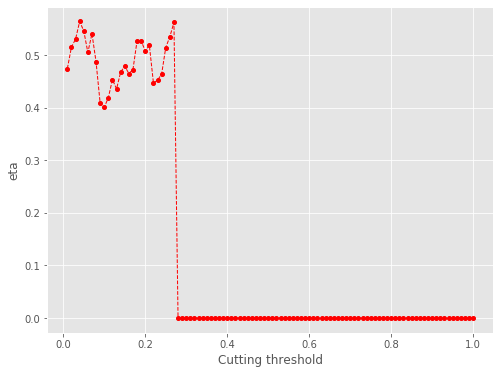

time: 1.6 s


In [25]:
from tqdm import tqdm_notebook

#poly_prices = polyair[polyair.median_prices>0]
poly_prices = polyair.copy()
print(len(poly_prices))
poly_prices['zpred'] = zpred

lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
keys_initial = np.array(keys)


perc_vals = np.linspace(0.01, 1, 100)
etas_cut = []
for i in tqdm_notebook(perc_vals):
    keys = keys_initial
    vals_cut = vals[vals>=i*vals.max()]
    print(len(vals), len(vals_cut))

    L = np.cumsum(vals_cut)/np.sum(vals_cut)
    keys = keys[vals>=i*vals.max()]
    print('Number of cells with price above {}th percentile: '.format(i*100), len(keys))
    
    
        
    L1= L
    F1 = np.arange(1, len(L1)+1)/len(L1)

    L1 = (L1 - L1.min())/(L1.max()-L1.min())
    

    loubar_val = vals_cut[np.where(tngnt1(F1)>0)[0][0]]

    print('Loubar price: ', loubar_val)
    print('Average price: ', np.mean(vals_cut))
    
    
    loubar_keys = keys[vals_cut>loubar_val]
    dist_mat = mat[keys.reshape(-1,1), keys]

    total_dist = dist_mat.sum()
    dist_corr = dist_mat[dist_mat>0]

    loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]

    loubar_dist = loubar_dist_mat.sum()

    loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
    eta = loubar_dist_corr.mean()/dist_corr.mean()
    etas_cut.append(eta)
    print('eta = ', eta)
etas_cut = np.array(etas_cut)
etas_cut = np.where(np.isnan(etas_cut), 0, etas_cut)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(perc_vals, etas_cut, color='r', linestyle='--', marker='o', markersize=4, linewidth=1)
plt.xlabel("Cutting threshold")
plt.ylabel("eta")
plt.show()

In [29]:
pickle_in = open("etas_cut_dict.pickle","rb")
etas_cut_dict = pickle.load(pickle_in)
#etas_cut_dict = {}
etas_cut_dict['Beijing'] = etas_cut


pickle_out = open("etas_cut_dict.pickle","wb")
pickle.dump(etas_cut_dict, pickle_out)
pickle_out.close()

etas_cut_dict

{'Boston': array([0.54176111, 0.69697859, 0.70601119, 0.71142664, 0.72735905,
        0.71723297, 0.69152614, 0.68969459, 0.69338651, 0.68627389,
        0.68571239, 0.68565242, 0.66080855, 0.68568495, 0.66662135,
        0.65169235, 0.66853925, 0.64080339, 0.6392735 , 0.64870117,
        0.66369008, 0.64936606, 0.65513408, 0.65817401, 0.54708479,
        0.54484174, 0.5177247 , 0.54225619, 0.54660686, 0.55128317,
        0.55836993, 0.56571414, 0.52792612, 0.52759205, 0.55096732,
        0.46941853, 0.48021089, 0.47484233, 0.46129546, 0.46439344,
        0.4699713 , 0.50255475, 0.51573036, 0.52765377, 0.52765377,
        0.53943229, 0.54404083, 0.54813213, 0.6100999 , 0.50092562,
        0.52536404, 0.56707558, 0.56150998, 0.61316219, 0.66467806,
        0.74541769, 0.74541769, 0.77652679, 0.74895419, 0.92876367,
        0.92876367, 0.90963119, 0.90963119, 1.05344906, 1.15130075,
        1.15130075, 1.22651104, 1.26738008, 0.62257449, 0.62257449,
        0.64231201, 0.64231201, 0.6240

time: 23 ms


100
100
100
100
100
100
100
100
100
100
100
100
100
100


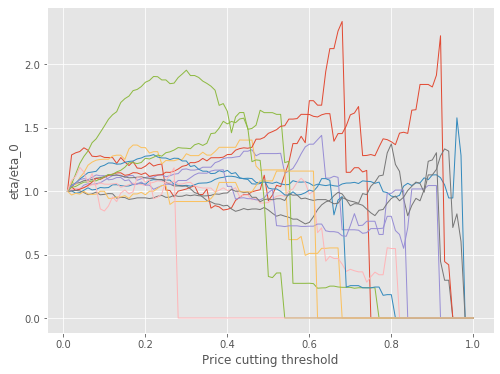

time: 238 ms


In [30]:
fig, ax = plt.subplots(figsize=(8, 6))
for key in etas_cut_dict:
    print(len(etas_cut_dict[key]))
    etas = etas_cut_dict[key]#[1:]
    vals = etas/etas[0]
    plt.plot(np.linspace(0.01, 1, 100), vals, linestyle='-', linewidth=1)
plt.xlabel("Price cutting threshold")
plt.ylabel("eta/eta_0")
plt.show()

3849 328
Number of cells with price above 5th percentile:  328


eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  0.9941875554148208
eta =  0.9383683618131412
eta =  0.8886766456276307
eta =  0.8590088389530496
eta =  0.8231301409156472
eta =  0.7963426594583904
eta =  0.7939875093003098
eta =  0.783545542219227
eta =  0.78963435796683
eta =  0.790141079010148
eta =  0.7742133329077993
eta =  0.7676483531482211
eta =  0.7551549668223478
eta =  0.7426812501439692
eta =  0.7448378211462736
eta =  0.7542746001657848
eta =  0.7407543172174242
eta =  0.727424058673968
eta =  0.7098616144252466
eta =  0.6936344899346676
eta =  0.6712653412291226
eta =  0.6558798088077318
eta =  0.6253786474292757
eta =  0.6057450894528776
eta =  0.5765766898914857
eta =  0.4748647464754204
eta =  0.4192011712056681
eta =  0.32084719075360857
eta =  0.3663690834683354
eta =  0.3663690834683354
eta =  0.34420128719278337
eta =  0.36973982424005786
eta =  0.3570354704027234
eta =  0.3832493405419802
eta =  0.32522271630501903
eta =  0.32522271630501903
eta =  0.

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning:

Mean of empty slice.



eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan



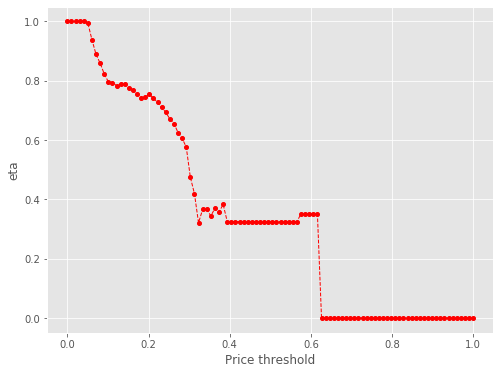

time: 669 ms


In [31]:
lval = np.linspace(0, max(vals_cut), 100)
etas = []

lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
keys = np.array(keys)
vals_cut = vals[vals>0.05*vals.max()]
print(len(vals), len(vals_cut))

L = np.cumsum(vals_cut)/np.sum(vals_cut)
keys = keys[vals>0.05*vals.max()]
print('Number of cells with price above 5th percentile: ', len(keys))

for i in tqdm_notebook(lval):
    loubar_keys = keys[vals_cut>=i]
    dist_mat = mat[keys.reshape(-1,1), keys]

    total_dist = dist_mat.sum()
    dist_corr = dist_mat[dist_mat>0]

    loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]

    loubar_dist = loubar_dist_mat.sum()

    loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
    eta = loubar_dist_corr.mean()/dist_corr.mean()
    etas.append(eta)
    print('eta = ', eta)
etas = np.array(etas)
etas = np.where(np.isnan(etas), 0, etas)
lval = lval/lval.max()
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(lval, etas, color='r', linestyle='--', marker='o', markersize=4, linewidth=1)
plt.xlabel("Price threshold")
plt.ylabel("eta")
plt.show()

etas_cut_threshold = etas

In [32]:
pickle_in = open("etas_cut_threshold_dict.pickle","rb")
etas_cut_threshold_dict = pickle.load(pickle_in)
#etas_cut_threshold_dict = {}
etas_cut_threshold_dict['Beijing'] = etas_cut_threshold


pickle_out = open("etas_cut_threshold_dict.pickle","wb")
pickle.dump(etas_cut_threshold_dict, pickle_out)
pickle_out.close()

etas_cut_threshold_dict

{'NY': array([1.        , 1.        , 1.        , 1.        , 1.        ,
        0.99991145, 0.98955316, 0.97868522, 0.96344498, 0.95205618,
        0.94615067, 0.93194961, 0.92540239, 0.92150344, 0.91822455,
        0.91569734, 0.91218202, 0.90337978, 0.898264  , 0.89376519,
        0.89441924, 0.88573077, 0.88617046, 0.87902683, 0.87195329,
        0.87101443, 0.87158631, 0.86935351, 0.86321974, 0.86053312,
        0.86079304, 0.86069179, 0.86140605, 0.85888874, 0.8617884 ,
        0.85709178, 0.8579834 , 0.85179248, 0.84947743, 0.84847717,
        0.84228408, 0.82983947, 0.82767187, 0.82334824, 0.81678545,
        0.81788964, 0.81304395, 0.807866  , 0.79902867, 0.79698224,
        0.78820712, 0.76853775, 0.76312442, 0.75071909, 0.7481045 ,
        0.73389742, 0.71700231, 0.70245218, 0.68328343, 0.67990807,
        0.66811743, 0.61552082, 0.58620924, 0.57826542, 0.57372339,
        0.55441141, 0.5326264 , 0.53706259, 0.53126932, 0.52772792,
        0.5331439 , 0.51700595, 0.49034259

time: 21 ms


3849 746
Number of cells with price above 1.0th percentile:  746


eta =  1.0
eta =  0.8626595961716295
eta =  0.775618894767906
eta =  0.7114334479185538
eta =  0.6627748029884204
eta =  0.6227820458282786
eta =  0.5903472421990055
eta =  0.570075156415272
eta =  0.5473859903588771
eta =  0.530623623245281
eta =  0.5310193918681066
eta =  0.5183770182744666
eta =  0.5233497560343536
eta =  0.5236855979740088
eta =  0.5110947167518829
eta =  0.5087779860221976
eta =  0.5004976843614087
eta =  0.49816664351707596
eta =  0.4979744975663253
eta =  0.49991419952404764
eta =  0.48932461328629917
eta =  0.48211833717667635
eta =  0.4763106512583722
eta =  0.4642223662361466
eta =  0.45206701141958305
eta =  0.4347006110666273
eta =  0.4135872141393754
eta =  0.411861221763696
eta =  0.38010658937293595
eta =  0.314728388791393
eta =  0.314728388791393
eta =  0.2236656435346352
eta =  0.2351832835502014
eta =  0.24282019711677416
eta =  0.24282019711677416
eta =  0.24505423916767755
eta =  0.24505423916767755
eta =  0.2627572070157046
eta =  0.21554942172641

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning:

Mean of empty slice.



eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan


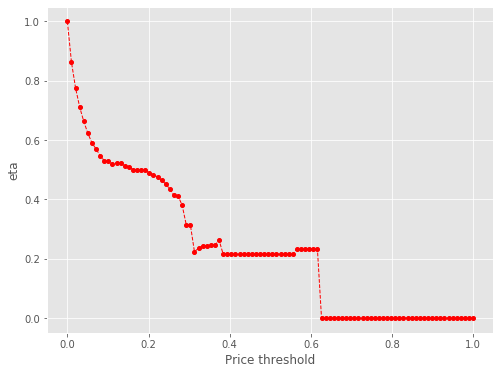

3849 559
Number of cells with price above 2.0th percentile:  559


eta =  1.0
eta =  0.8991019148340798
eta =  0.8246977731144502
eta =  0.7728959667014464
eta =  0.7234153241237855
eta =  0.6849508640109496
eta =  0.6608344229232376
eta =  0.6378451636715189
eta =  0.6152943150607654
eta =  0.6155607544675805
eta =  0.601670784283031
eta =  0.6066700681901777
eta =  0.6052295117257412
eta =  0.5924639556785254
eta =  0.5941805312081815
eta =  0.5797461646347323
eta =  0.5748589451964363
eta =  0.5772549216125005
eta =  0.5750821318780245
eta =  0.5672279256590408
eta =  0.5588743686574107
eta =  0.5512608020156612
eta =  0.5441172418379779
eta =  0.5196058086679662
eta =  0.5076685538470685
eta =  0.49365733039373394
eta =  0.48227402887067916
eta =  0.45261116047429734
eta =  0.41975956572181194
eta =  0.3648349710454928
eta =  0.3313632619524048
eta =  0.2582481347024764
eta =  0.2814785787979157
eta =  0.2814785787979157
eta =  0.2644472296140444
eta =  0.2840682932818417
eta =  0.3045896761385217
eta =  0.24986613802593524
eta =  0.24986613802593

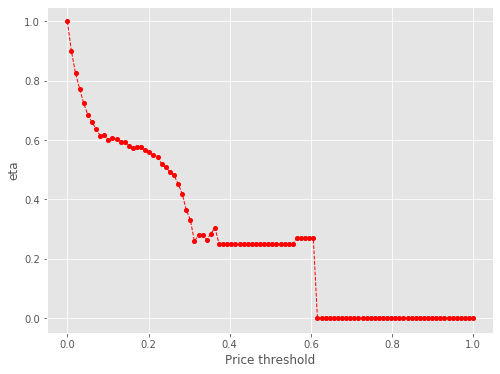

3849 454
Number of cells with price above 3.0th percentile:  454


eta =  1.0
eta =  0.9172461536428159
eta =  0.859631098487958
eta =  0.8050902009212738
eta =  0.7673549268694924
eta =  0.7354781234723597
eta =  0.7166934464028958
eta =  0.6843432373006477
eta =  0.6841363559141316
eta =  0.6691908607424814
eta =  0.6757918395296562
eta =  0.6702479226034822
eta =  0.6582315010805699
eta =  0.661063579898815
eta =  0.6492822320947216
eta =  0.6393701711807841
eta =  0.6387194058102786
eta =  0.6352788171672837
eta =  0.6358667641488498
eta =  0.6295410869091103
eta =  0.6131238215829969
eta =  0.6063264476566003
eta =  0.5812361402687263
eta =  0.5646396092268958
eta =  0.565112332762112
eta =  0.5371840069376196
eta =  0.5176157840294358
eta =  0.4668653895585067
eta =  0.4057771038256764
eta =  0.36854916721376857
eta =  0.2741674230418841
eta =  0.3130663767409057
eta =  0.3130663767409057
eta =  0.2941237531040577
eta =  0.3159467114851642
eta =  0.3050907026018915
eta =  0.3387710237439887
eta =  0.27790635733663804
eta =  0.27790635733663804
e

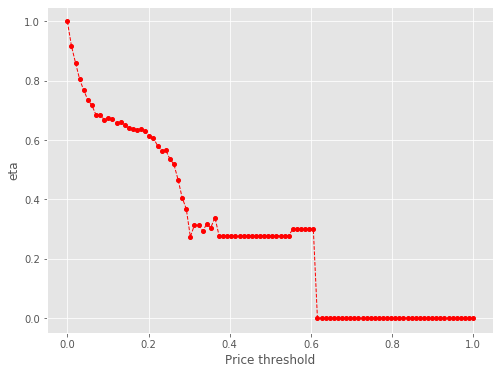

3849 385
Number of cells with price above 4.0th percentile:  385


eta =  1.0
eta =  0.9371869209524167
eta =  0.877725349650017
eta =  0.8365856033540887
eta =  0.8018328782861941
eta =  0.7808563182602342
eta =  0.7450281821740211
eta =  0.745859062147172
eta =  0.729565186056992
eta =  0.7342443628820036
eta =  0.7307176159219774
eta =  0.7144791861787095
eta =  0.7176945059378972
eta =  0.7078604031383684
eta =  0.7019313451131257
eta =  0.6935123946326105
eta =  0.6944519537004663
eta =  0.7026858253384773
eta =  0.6804222759798534
eta =  0.6684397848363756
eta =  0.661029152587441
eta =  0.6326472300385967
eta =  0.6253540026656424
eta =  0.6110207670702497
eta =  0.582605739237824
eta =  0.5789174278615681
eta =  0.5371416021675341
eta =  0.4423862691755584
eta =  0.4489991828953144
eta =  0.31438730381459495
eta =  0.3413111905649011
eta =  0.3413111905649011
eta =  0.3413111905649011
eta =  0.3444513887906656
eta =  0.3444513887906656
eta =  0.3693349079727068
eta =  0.3029790381054651
eta =  0.3029790381054651
eta =  0.3029790381054651
eta =

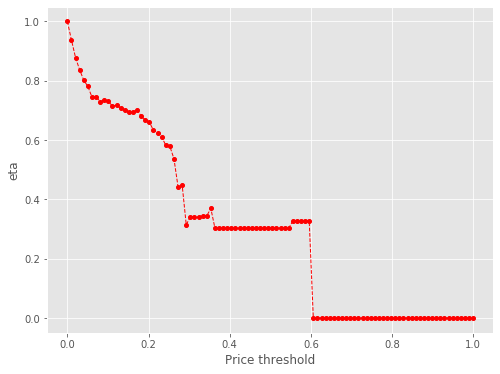

3849 328
Number of cells with price above 5.0th percentile:  328


eta =  1.0
eta =  0.9415885585256573
eta =  0.8980048390337215
eta =  0.8607006885015388
eta =  0.8381841016345514
eta =  0.8028843337680872
eta =  0.8006174674294797
eta =  0.7868364041484727
eta =  0.7850061417771913
eta =  0.79366727740729
eta =  0.7730125412394336
eta =  0.7703851664386855
eta =  0.75982907765814
eta =  0.7586586832423824
eta =  0.7444276877501498
eta =  0.7407656628421573
eta =  0.7542746001657848
eta =  0.7303765376388249
eta =  0.727424058673968
eta =  0.7098616144252466
eta =  0.6936344899346676
eta =  0.6712653412291226
eta =  0.6558798088077318
eta =  0.6240237442258367
eta =  0.6214195529260212
eta =  0.5735079059418874
eta =  0.4748647464754204
eta =  0.4748647464754204
eta =  0.33746853761811296
eta =  0.3548464463189775
eta =  0.3663690834683354
eta =  0.3663690834683354
eta =  0.36973982424005786
eta =  0.36973982424005786
eta =  0.39645020575758866
eta =  0.32522271630501903
eta =  0.32522271630501903
eta =  0.32522271630501903
eta =  0.3252227163050190

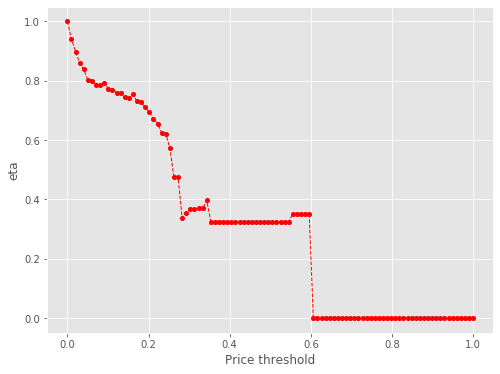

3849 289
Number of cells with price above 6.000000000000001th percentile:  289


eta =  1.0
eta =  0.9479194947148228
eta =  0.9153686433864543
eta =  0.8920091813019977
eta =  0.8510810033639041
eta =  0.8520301569370761
eta =  0.8373641247959394
eta =  0.8322802406845115
eta =  0.8446336514444323
eta =  0.8213646732674229
eta =  0.8198564495104089
eta =  0.8086224877918282
eta =  0.8046013711631892
eta =  0.792232077646911
eta =  0.7883348910578123
eta =  0.8027113223201209
eta =  0.7857076429290994
eta =  0.7741365384666407
eta =  0.7554462990724385
eta =  0.7381771287272845
eta =  0.7258831792723722
eta =  0.6979979817634121
eta =  0.6837997918168088
eta =  0.6613248158365498
eta =  0.6269438297602908
eta =  0.5543803550951992
eta =  0.5053588023283733
eta =  0.4589947633474242
eta =  0.3577178132973067
eta =  0.3898959495433618
eta =  0.3898959495433618
eta =  0.36630461946627807
eta =  0.39348314680742585
eta =  0.3799629664039653
eta =  0.42190877013200756
eta =  0.3461073150234199
eta =  0.3461073150234199
eta =  0.3461073150234199
eta =  0.3461073150234199

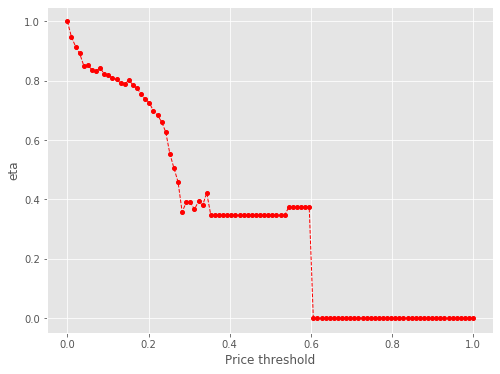

3849 258
Number of cells with price above 6.999999999999999th percentile:  258


eta =  1.0
eta =  0.965660742805842
eta =  0.9416169654927068
eta =  0.8978410172057363
eta =  0.898842319086818
eta =  0.8833705071630122
eta =  0.8780073047605156
eta =  0.8890966297999707
eta =  0.8664920152470612
eta =  0.8649009267997583
eta =  0.8530497497945208
eta =  0.8488077053476464
eta =  0.8357588192499936
eta =  0.8362192704241237
eta =  0.8468138136156941
eta =  0.828875919642813
eta =  0.8166690766282172
eta =  0.8068313311402043
eta =  0.7867671669941214
eta =  0.7592869162973721
eta =  0.7418433056779088
eta =  0.7213690567916075
eta =  0.7047349242116029
eta =  0.661389319721612
eta =  0.6133841095046397
eta =  0.5331241789477156
eta =  0.48421281122139026
eta =  0.3602107682404099
eta =  0.4113175767744498
eta =  0.4113175767744498
eta =  0.38643009402025125
eta =  0.4151018614991175
eta =  0.4151018614991175
eta =  0.4450892427937003
eta =  0.3651231111430456
eta =  0.3651231111430456
eta =  0.3651231111430456
eta =  0.3651231111430456
eta =  0.3651231111430456
eta

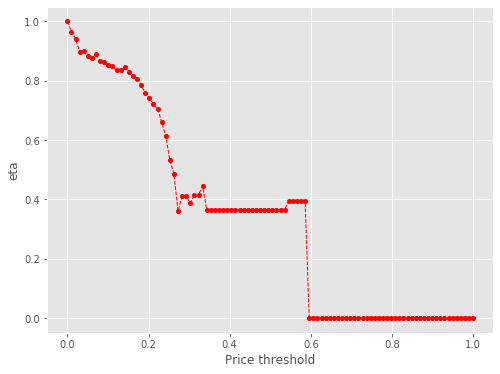

3849 233
Number of cells with price above 8.0th percentile:  233


eta =  1.0
eta =  0.965211770975815
eta =  0.9310869617520482
eta =  0.9308054881418549
eta =  0.9147834927992147
eta =  0.9092295729133205
eta =  0.9227251310681409
eta =  0.8973047953977769
eta =  0.895657127250183
eta =  0.8946325513466663
eta =  0.8779503522107892
eta =  0.8654787154561105
eta =  0.8659555404462124
eta =  0.8769268295562849
eta =  0.8583510573645312
eta =  0.845710134446688
eta =  0.832820014068536
eta =  0.8233790840238698
eta =  0.7862874430321913
eta =  0.7682235310947766
eta =  0.7470212102602245
eta =  0.730868660139335
eta =  0.704245006654668
eta =  0.6351962778588051
eta =  0.5520822741521623
eta =  0.4873672717215584
eta =  0.392344133957849
eta =  0.42594418364706194
eta =  0.42594418364706194
eta =  0.42594418364706194
eta =  0.4298630389519509
eta =  0.4298630389519509
eta =  0.4609167827413597
eta =  0.3781070255399811
eta =  0.3781070255399811
eta =  0.3781070255399811
eta =  0.3781070255399811
eta =  0.3781070255399811
eta =  0.3781070255399811
eta =

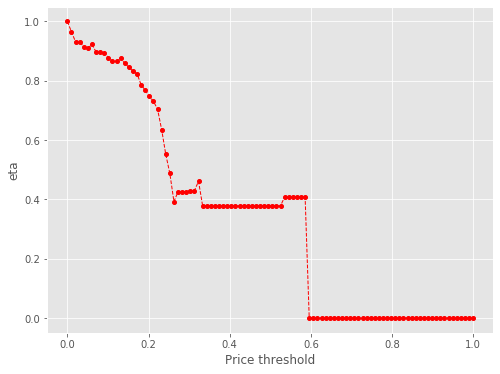

3849 207
Number of cells with price above 9.0th percentile:  207


eta =  1.0
eta =  0.969680544818151
eta =  0.9693874041181991
eta =  0.9482103761142591
eta =  0.9504852154143926
eta =  0.960972115996432
eta =  0.93449810663439
eta =  0.9327821425916418
eta =  0.931715097985561
eta =  0.9143414211848435
eta =  0.8992382485431294
eta =  0.8985408026083354
eta =  0.9132754734849788
eta =  0.8939297349672545
eta =  0.8807648454075157
eta =  0.868766152638102
eta =  0.8575081722610964
eta =  0.8235828842072264
eta =  0.800066419974727
eta =  0.8002227552605807
eta =  0.7611631884747133
eta =  0.7334359837381309
eta =  0.6981188937627104
eta =  0.5749661013155466
eta =  0.5861935341081781
eta =  0.40860681032043866
eta =  0.42964797728201004
eta =  0.4435995830977998
eta =  0.4435995830977998
eta =  0.41675882160957844
eta =  0.44768087507503634
eta =  0.43229844702620346
eta =  0.4640381936092669
eta =  0.3937795733228383
eta =  0.3937795733228383
eta =  0.3937795733228383
eta =  0.3937795733228383
eta =  0.3937795733228383
eta =  0.3937795733228383
eta

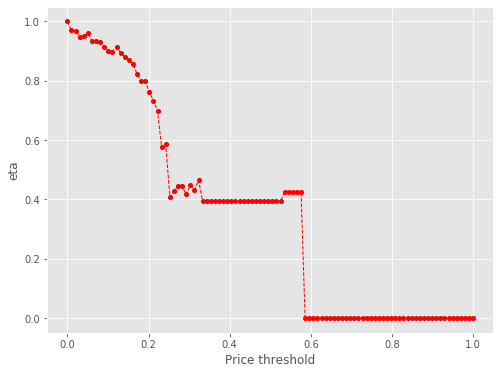

3849 181
Number of cells with price above 10.0th percentile:  181


eta =  1.0
eta =  1.0007458556413398
eta =  0.9781642826669668
eta =  0.9844378874523679
eta =  0.9913291651148719
eta =  0.9640188434507481
eta =  0.9622486722110748
eta =  0.9490636021249279
eta =  0.9432254095669117
eta =  0.9276451286448462
eta =  0.926925650436537
eta =  0.9421257886457914
eta =  0.9221689194566988
eta =  0.9085881518580957
eta =  0.8962104211335791
eta =  0.8845968018596794
eta =  0.8495998160752869
eta =  0.8253404682066087
eta =  0.8192258919947987
eta =  0.7811284527969594
eta =  0.7761833505352871
eta =  0.7201724260095755
eta =  0.5931292445415866
eta =  0.5931292445415866
eta =  0.4215146739353624
eta =  0.41984604875296816
eta =  0.4576128662189818
eta =  0.4576128662189818
eta =  0.4299242067519212
eta =  0.4618230859548466
eta =  0.4459547279647947
eta =  0.4951856560940276
eta =  0.40621904544717213
eta =  0.40621904544717213
eta =  0.40621904544717213
eta =  0.40621904544717213
eta =  0.40621904544717213
eta =  0.40621904544717213
eta =  0.406219045447

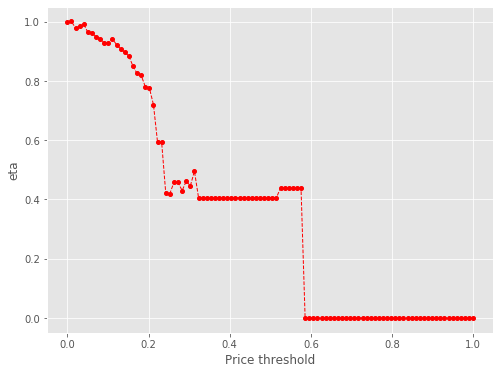

3849 165
Number of cells with price above 11.0th percentile:  165


eta =  1.0
eta =  0.9774352570664394
eta =  0.9870767954917755
eta =  0.978979225450431
eta =  0.9648107820039762
eta =  0.9615315085111259
eta =  0.9483562652544879
eta =  0.9425224238999567
eta =  0.92695375495745
eta =  0.9382170877855148
eta =  0.9414236225260398
eta =  0.9214816271866706
eta =  0.9079109813308358
eta =  0.8955424757259995
eta =  0.8856140781328935
eta =  0.8489666095402523
eta =  0.8247253421576045
eta =  0.818615323137949
eta =  0.780546277952222
eta =  0.7756048612740553
eta =  0.715805477528297
eta =  0.5926871854607609
eta =  0.5926871854607609
eta =  0.5383112219995444
eta =  0.41953313759556354
eta =  0.4572718074617608
eta =  0.4572718074617608
eta =  0.42960378434582597
eta =  0.4614788893218867
eta =  0.4614788893218867
eta =  0.49481659434570635
eta =  0.405916290491997
eta =  0.405916290491997
eta =  0.405916290491997
eta =  0.405916290491997
eta =  0.405916290491997
eta =  0.405916290491997
eta =  0.405916290491997
eta =  0.405916290491997
eta =  0.405

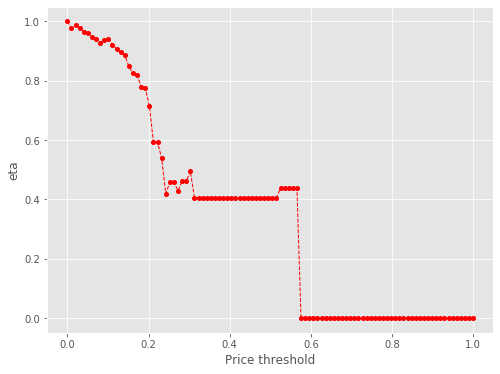

3849 145
Number of cells with price above 12.0th percentile:  145


eta =  1.0
eta =  1.0095928978033013
eta =  1.00719558886779
eta =  0.9805689160008793
eta =  0.9849817004064341
eta =  0.9714851343643224
eta =  0.9666541346243378
eta =  0.9517935724274245
eta =  0.9488241757916889
eta =  0.9643834157388448
eta =  0.9439550675204028
eta =  0.9300534556518625
eta =  0.9173833022826792
eta =  0.907212767196719
eta =  0.8696715263632642
eta =  0.8582513086074454
eta =  0.838580021378311
eta =  0.7995825340074092
eta =  0.7945206042016829
eta =  0.733262810604925
eta =  0.6007994840783962
eta =  0.607141863346945
eta =  0.5514397584474388
eta =  0.41022156875118054
eta =  0.4684239242029967
eta =  0.4684239242029967
eta =  0.4684239242029967
eta =  0.47273360995708336
eta =  0.47273360995708336
eta =  0.5068843674635702
eta =  0.41581592957944435
eta =  0.41581592957944435
eta =  0.41581592957944435
eta =  0.41581592957944435
eta =  0.41581592957944435
eta =  0.41581592957944435
eta =  0.41581592957944435
eta =  0.41581592957944435
eta =  0.4158159295794

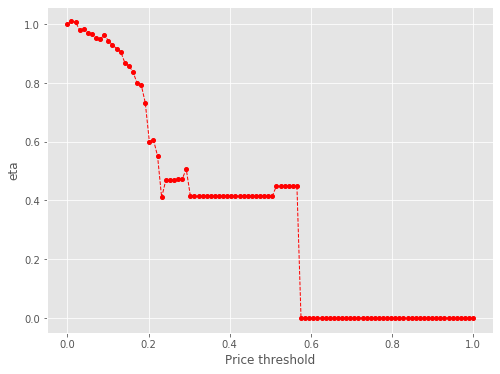

3849 126
Number of cells with price above 13.0th percentile:  126


eta =  1.0
eta =  1.0006417160527599
eta =  0.9765834623190953
eta =  0.9797146120744108
eta =  0.962254326945153
eta =  0.9607721290089194
eta =  0.942749869277371
eta =  0.9381122482429702
eta =  0.9552200870639794
eta =  0.9349858438725995
eta =  0.9212163216237923
eta =  0.9086665568653918
eta =  0.896891523692923
eta =  0.8614081262412981
eta =  0.836811605625359
eta =  0.830612044917229
eta =  0.7919851018634955
eta =  0.7869712692417128
eta =  0.7262955317934362
eta =  0.5950908384811655
eta =  0.6013729540570066
eta =  0.5462001165492307
eta =  0.40632374657522985
eta =  0.46397307788337827
eta =  0.46397307788337827
eta =  0.46397307788337827
eta =  0.46824181408731136
eta =  0.46824181408731136
eta =  0.5020680796848537
eta =  0.4118649511938798
eta =  0.4118649511938798
eta =  0.4118649511938798
eta =  0.4118649511938798
eta =  0.4118649511938798
eta =  0.4118649511938798
eta =  0.4118649511938798
eta =  0.4118649511938798
eta =  0.4118649511938798
eta =  0.4118649511938798


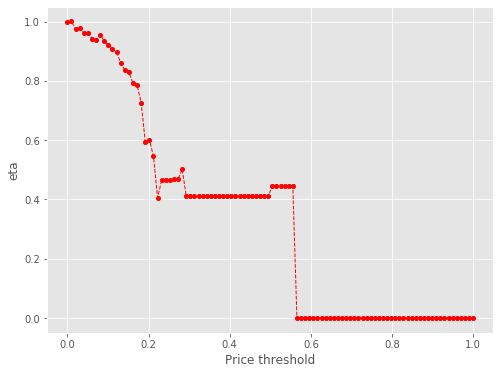

3849 112
Number of cells with price above 14.000000000000002th percentile:  112


eta =  1.0
eta =  0.9798418959278736
eta =  0.9787848645983461
eta =  0.9550073444843349
eta =  0.9433174285172587
eta =  0.9421452795274663
eta =  0.9369129982670652
eta =  0.9546075001070757
eta =  0.9343862332272598
eta =  0.9206255414352725
eta =  0.9065935775637908
eta =  0.8963163431072001
eta =  0.8608557013186521
eta =  0.8362749545624951
eta =  0.8300793696606529
eta =  0.7914771982399915
eta =  0.7864665810117184
eta =  0.7258297551879613
eta =  0.5947092040382101
eta =  0.600987290864954
eta =  0.5458498359471071
eta =  0.40606316932104203
eta =  0.46367552985259997
eta =  0.46367552985259997
eta =  0.46367552985259997
eta =  0.467941528496722
eta =  0.467941528496722
eta =  0.5017461011573313
eta =  0.4116008203401384
eta =  0.4116008203401384
eta =  0.4116008203401384
eta =  0.4116008203401384
eta =  0.4116008203401384
eta =  0.4116008203401384
eta =  0.4116008203401384
eta =  0.4116008203401384
eta =  0.4116008203401384
eta =  0.4116008203401384
eta =  0.4116008203401384


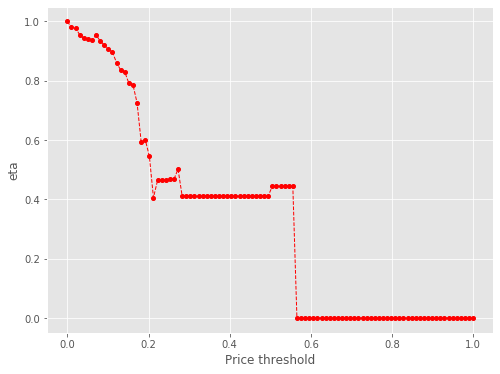

3849 100
Number of cells with price above 15.000000000000002th percentile:  100


eta =  1.0
eta =  1.002897350147977
eta =  0.9785340679008431
eta =  0.966556169415823
eta =  0.9653551443914691
eta =  0.9606063223876766
eta =  0.9781243733081613
eta =  0.9574049530311379
eta =  0.9433052649040129
eta =  0.930454581636657
eta =  0.9183972064846074
eta =  0.8820629874232254
eta =  0.8568766909468037
eta =  0.8505284770487228
eta =  0.8092183319127447
eta =  0.8058412819861706
eta =  0.7639471669731196
eta =  0.708498064225828
eta =  0.6157926867089524
eta =  0.559296913806187
eta =  0.4376207309597692
eta =  0.475098233571947
eta =  0.475098233571947
eta =  0.475098233571947
eta =  0.44635159165283483
eta =  0.4794693256174708
eta =  0.46299463837134497
eta =  0.5141066780842175
eta =  0.421740657184408
eta =  0.421740657184408
eta =  0.421740657184408
eta =  0.421740657184408
eta =  0.421740657184408
eta =  0.421740657184408
eta =  0.421740657184408
eta =  0.421740657184408
eta =  0.421740657184408
eta =  0.421740657184408
eta =  0.421740657184408
eta =  0.421740657

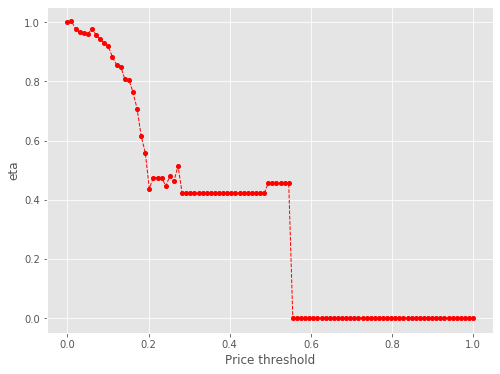

3849 94
Number of cells with price above 16.0th percentile:  94


eta =  1.0
eta =  0.9837251180509458
eta =  0.9791434716189573
eta =  0.9737112320338637
eta =  0.9684661435395785
eta =  0.9825782821944594
eta =  0.9514467589794992
eta =  0.9476006242841684
eta =  0.936185653358027
eta =  0.9225791465228448
eta =  0.8810187338852042
eta =  0.8607784960877614
eta =  0.8544013754707964
eta =  0.8146681287916796
eta =  0.809510696372242
eta =  0.7470971618578485
eta =  0.6786027328197576
eta =  0.6185967110174094
eta =  0.5618436834833962
eta =  0.4179611529651232
eta =  0.477261602875601
eta =  0.477261602875601
eta =  0.477261602875601
eta =  0.481652598776131
eta =  0.481652598776131
eta =  0.4651028937123054
eta =  0.5164476731197263
eta =  0.4236610616973779
eta =  0.4236610616973779
eta =  0.4236610616973779
eta =  0.4236610616973779
eta =  0.4236610616973779
eta =  0.4236610616973779
eta =  0.4236610616973779
eta =  0.4236610616973779
eta =  0.4236610616973779
eta =  0.4236610616973779
eta =  0.4236610616973779
eta =  0.4236610616973779
eta =  0

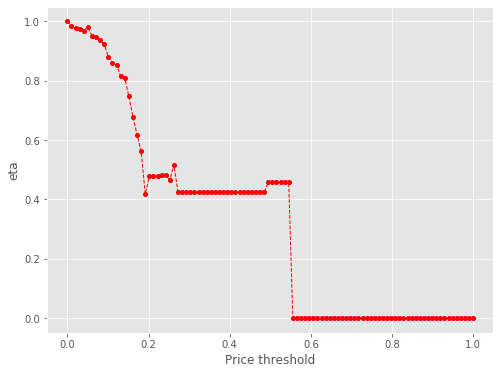

3849 88
Number of cells with price above 17.0th percentile:  88


eta =  1.0
eta =  0.9834819113607007
eta =  0.9949586444175004
eta =  0.9912136162715652
eta =  0.9890906790258496
eta =  0.9674466581049257
eta =  0.9632778577024129
eta =  0.9400211156821316
eta =  0.9280079444929334
eta =  0.8955944274664516
eta =  0.8750193324261369
eta =  0.8757519098533093
eta =  0.8281461089514328
eta =  0.8229033512696364
eta =  0.7594572387640888
eta =  0.6222619102319482
eta =  0.6288308590137811
eta =  0.5711389016848293
eta =  0.4248759590415151
eta =  0.48515748364868355
eta =  0.48515748364868355
eta =  0.48515748364868355
eta =  0.4896211247817166
eta =  0.4896211247817166
eta =  0.4727976191497617
eta =  0.5249918535606408
eta =  0.43067016783791945
eta =  0.43067016783791945
eta =  0.43067016783791945
eta =  0.43067016783791945
eta =  0.43067016783791945
eta =  0.43067016783791945
eta =  0.43067016783791945
eta =  0.43067016783791945
eta =  0.43067016783791945
eta =  0.43067016783791945
eta =  0.43067016783791945
eta =  0.43067016783791945
eta =  0.430

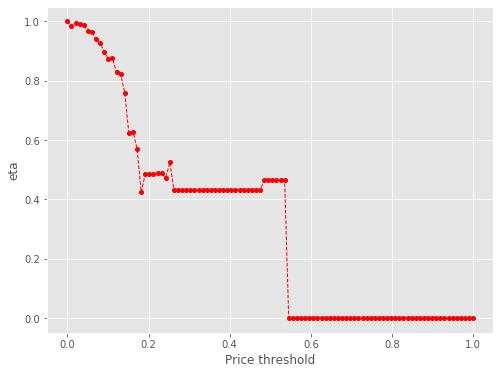

3849 81
Number of cells with price above 18.000000000000004th percentile:  81


eta =  1.0
eta =  0.9996142938246645
eta =  0.9890952364093032
eta =  1.0035079747504447
eta =  0.9717133255316881
eta =  0.9677852651331732
eta =  0.9561271463211596
eta =  0.9422308101563638
eta =  0.9049536707869524
eta =  0.8791137571131569
eta =  0.8726007987962101
eta =  0.832021202617705
eta =  0.8267539128190914
eta =  0.7837725909565968
eta =  0.7268845117735078
eta =  0.6317733089662493
eta =  0.5577169352344006
eta =  0.4489775589058854
eta =  0.47209761354112
eta =  0.4874276515233017
eta =  0.4874276515233017
eta =  0.4579349968054175
eta =  0.49191217910052154
eta =  0.49191217910052154
eta =  0.5274484159770884
eta =  0.4326853765331027
eta =  0.4326853765331027
eta =  0.4326853765331027
eta =  0.4326853765331027
eta =  0.4326853765331027
eta =  0.4326853765331027
eta =  0.4326853765331027
eta =  0.4326853765331027
eta =  0.4326853765331027
eta =  0.4326853765331027
eta =  0.4326853765331027
eta =  0.4326853765331027
eta =  0.4326853765331027
eta =  0.4326853765331027
et

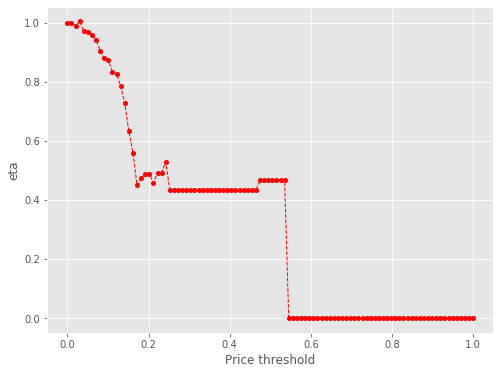

3849 74
Number of cells with price above 19.0th percentile:  74


eta =  1.0
eta =  0.9962359961723558
eta =  0.9903926390589662
eta =  0.9723486132142893
eta =  0.9681586899185796
eta =  0.944784108320872
eta =  0.9327100675990777
eta =  0.9001323145353226
eta =  0.8794529675536594
eta =  0.8729374961791683
eta =  0.8323422421604989
eta =  0.8270729199517696
eta =  0.7840750135312421
eta =  0.7271649837982466
eta =  0.6320170818576393
eta =  0.5579321331035567
eta =  0.4491507991427716
eta =  0.4722797747667336
eta =  0.4876157279207515
eta =  0.4876157279207515
eta =  0.4581116933145223
eta =  0.4921019858753686
eta =  0.4921019858753686
eta =  0.5276519345866861
eta =  0.432852330349927
eta =  0.432852330349927
eta =  0.432852330349927
eta =  0.432852330349927
eta =  0.432852330349927
eta =  0.432852330349927
eta =  0.432852330349927
eta =  0.432852330349927
eta =  0.432852330349927
eta =  0.432852330349927
eta =  0.432852330349927
eta =  0.432852330349927
eta =  0.432852330349927
eta =  0.432852330349927
eta =  0.432852330349927
eta =  0.43285233

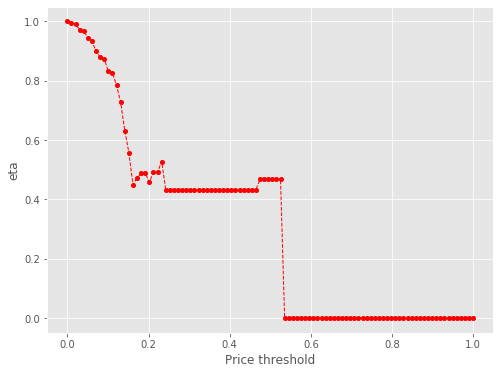

3849 64
Number of cells with price above 20.0th percentile:  64


eta =  1.0
eta =  0.9683164957142834
eta =  0.9644021666831745
eta =  0.952784801295607
eta =  0.938937042718251
eta =  0.9017902134878389
eta =  0.876040628707288
eta =  0.869550437816113
eta =  0.8273163965599268
eta =  0.8322194476286965
eta =  0.7810327477980508
eta =  0.7243435329492738
eta =  0.6295648115037257
eta =  0.6295648115037257
eta =  0.44740806271872274
eta =  0.4456369349112644
eta =  0.48572374489053427
eta =  0.48572374489053427
eta =  0.48572374489053427
eta =  0.49019259585141983
eta =  0.49019259585141983
eta =  0.4733494543290324
eta =  0.525604608282516
eta =  0.431172833121435
eta =  0.431172833121435
eta =  0.431172833121435
eta =  0.431172833121435
eta =  0.431172833121435
eta =  0.431172833121435
eta =  0.431172833121435
eta =  0.431172833121435
eta =  0.431172833121435
eta =  0.431172833121435
eta =  0.431172833121435
eta =  0.431172833121435
eta =  0.431172833121435
eta =  0.431172833121435
eta =  0.431172833121435
eta =  0.431172833121435
eta =  0.4311728

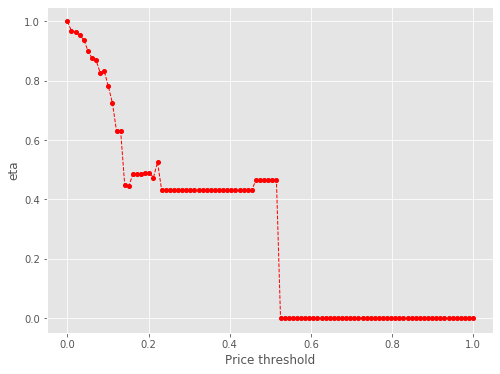

3849 60
Number of cells with price above 21.000000000000004th percentile:  60


eta =  1.0
eta =  0.9852730152664393
eta =  0.9718506037501099
eta =  0.9610762189982208
eta =  0.921306062424912
eta =  0.9092077982714944
eta =  0.8883685783700566
eta =  0.8702980020247982
eta =  0.8514798856115862
eta =  0.8204626773769835
eta =  0.7809549973055581
eta =  0.6431893680509555
eta =  0.6431893680509555
eta =  0.584180092274911
eta =  0.4345774315601245
eta =  0.49623540390906595
eta =  0.49623540390906595
eta =  0.49623540390906595
eta =  0.4662098208701434
eta =  0.5008009662990295
eta =  0.5008009662990295
eta =  0.5369793382168737
eta =  0.44050394334098625
eta =  0.44050394334098625
eta =  0.44050394334098625
eta =  0.44050394334098625
eta =  0.44050394334098625
eta =  0.44050394334098625
eta =  0.44050394334098625
eta =  0.44050394334098625
eta =  0.44050394334098625
eta =  0.44050394334098625
eta =  0.44050394334098625
eta =  0.44050394334098625
eta =  0.44050394334098625
eta =  0.44050394334098625
eta =  0.44050394334098625
eta =  0.44050394334098625
eta =  0.4

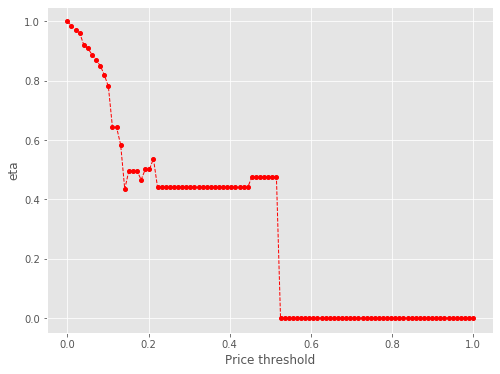

3849 55
Number of cells with price above 22.0th percentile:  55


eta =  1.0
eta =  0.9758566629199256
eta =  0.9633855248229162
eta =  0.9297363375533221
eta =  0.9083768773770134
eta =  0.9016471217673838
eta =  0.8578541454394274
eta =  0.8542741273347709
eta =  0.8098620832470981
eta =  0.7510803666487772
eta =  0.6528031906740317
eta =  0.6528031906740317
eta =  0.5929118967263465
eta =  0.462086202526819
eta =  0.503652689376531
eta =  0.503652689376531
eta =  0.503652689376531
eta =  0.5082864937325031
eta =  0.5082864937325031
eta =  0.49082164130448
eta =  0.545005627776848
eta =  0.44708820450326087
eta =  0.44708820450326087
eta =  0.44708820450326087
eta =  0.44708820450326087
eta =  0.44708820450326087
eta =  0.44708820450326087
eta =  0.44708820450326087
eta =  0.44708820450326087
eta =  0.44708820450326087
eta =  0.44708820450326087
eta =  0.44708820450326087
eta =  0.44708820450326087
eta =  0.44708820450326087
eta =  0.44708820450326087
eta =  0.44708820450326087
eta =  0.44708820450326087
eta =  0.44708820450326087
eta =  0.44708820

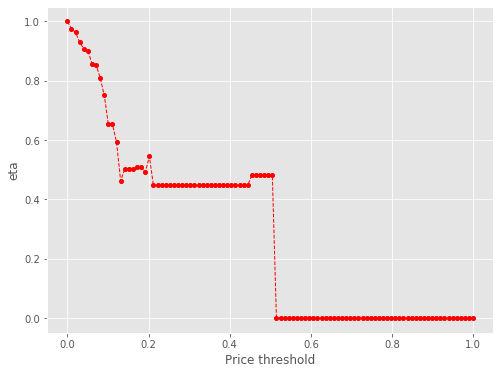

3849 50
Number of cells with price above 23.0th percentile:  50


eta =  1.0
eta =  0.9854660165039095
eta =  0.9464783781831688
eta =  0.9194527741374952
eta =  0.9126409621917655
eta =  0.8940766538802817
eta =  0.8734600368278708
eta =  0.8428797073142869
eta =  0.8022925816186606
eta =  0.6607628612963143
eta =  0.6607628612963143
eta =  0.6001413090107774
eta =  0.4464511408243955
eta =  0.5097937584961912
eta =  0.5097937584961912
eta =  0.5097937584961912
eta =  0.4789478037177273
eta =  0.5144840631219669
eta =  0.5144840631219669
eta =  0.551650915891808
eta =  0.4525395792786802
eta =  0.4525395792786802
eta =  0.4525395792786802
eta =  0.4525395792786802
eta =  0.4525395792786802
eta =  0.4525395792786802
eta =  0.4525395792786802
eta =  0.4525395792786802
eta =  0.4525395792786802
eta =  0.4525395792786802
eta =  0.4525395792786802
eta =  0.4525395792786802
eta =  0.4525395792786802
eta =  0.4525395792786802
eta =  0.4525395792786802
eta =  0.4525395792786802
eta =  0.4525395792786802
eta =  0.4525395792786802
eta =  0.4525395792786802
et

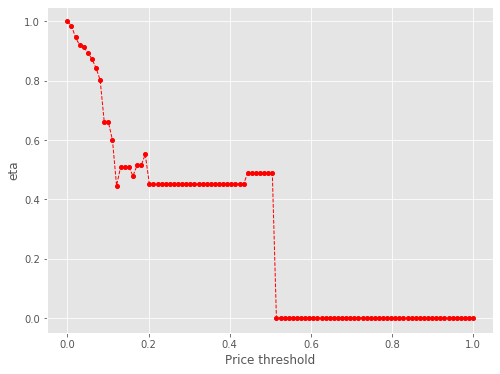

3849 45
Number of cells with price above 24.000000000000004th percentile:  45


eta =  1.0
eta =  0.9655780713631594
eta =  0.9433951948535968
eta =  0.9364060042843739
eta =  0.8867263851668753
eta =  0.8872067606371752
eta =  0.8410826132382238
eta =  0.780034836302037
eta =  0.6779690331234339
eta =  0.6779690331234339
eta =  0.6157689041560821
eta =  0.4798998234419152
eta =  0.5230687161532697
eta =  0.5230687161532697
eta =  0.5230687161532697
eta =  0.4914195370576149
eta =  0.5278811556507819
eta =  0.5278811556507819
eta =  0.5660158280310903
eta =  0.4643236461742765
eta =  0.4643236461742765
eta =  0.4643236461742765
eta =  0.4643236461742765
eta =  0.4643236461742765
eta =  0.4643236461742765
eta =  0.4643236461742765
eta =  0.4643236461742765
eta =  0.4643236461742765
eta =  0.4643236461742765
eta =  0.4643236461742765
eta =  0.4643236461742765
eta =  0.4643236461742765
eta =  0.4643236461742765
eta =  0.4643236461742765
eta =  0.4643236461742765
eta =  0.4643236461742765
eta =  0.4643236461742765
eta =  0.4643236461742765
eta =  0.4643236461742765
et

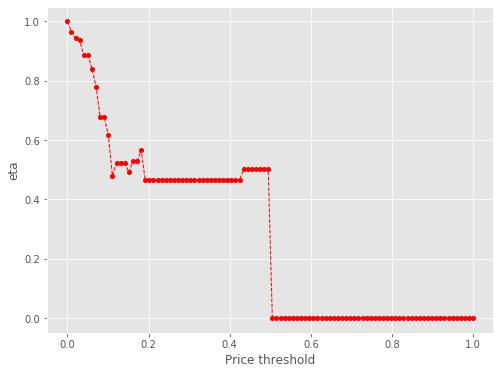

3849 40
Number of cells with price above 25.0th percentile:  40


eta =  1.0
eta =  0.9687615742531396
eta =  0.9420245727449589
eta =  0.9168667462408604
eta =  0.9110623234160956
eta =  0.8408191258621667
eta =  0.8010087184146847
eta =  0.696198529954843
eta =  0.7066055003587669
eta =  0.4947621434094012
eta =  0.4928035578064837
eta =  0.5371331926084785
eta =  0.5371331926084785
eta =  0.5371331926084785
eta =  0.5420750308635814
eta =  0.5420750308635814
eta =  0.5420750308635814
eta =  0.5812350832470458
eta =  0.4768085621853906
eta =  0.4768085621853906
eta =  0.4768085621853906
eta =  0.4768085621853906
eta =  0.4768085621853906
eta =  0.4768085621853906
eta =  0.4768085621853906
eta =  0.4768085621853906
eta =  0.4768085621853906
eta =  0.4768085621853906
eta =  0.4768085621853906
eta =  0.4768085621853906
eta =  0.4768085621853906
eta =  0.4768085621853906
eta =  0.4768085621853906
eta =  0.4768085621853906
eta =  0.4768085621853906
eta =  0.4768085621853906
eta =  0.4768085621853906
eta =  0.4768085621853906
eta =  0.4768085621853906
et

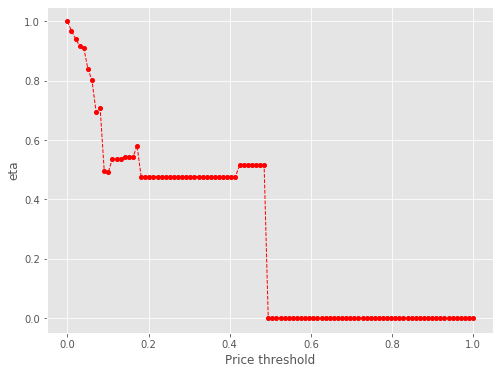

3849 37
Number of cells with price above 26.0th percentile:  37


eta =  1.0
eta =  0.9534958067486456
eta =  0.9474594957506728
eta =  0.8982029262840974
eta =  0.8330092211424467
eta =  0.7240118389048089
eta =  0.7240118389048089
eta =  0.657587522227251
eta =  0.48918595517805225
eta =  0.5585918007360627
eta =  0.5585918007360627
eta =  0.5585918007360627
eta =  0.5247932358498391
eta =  0.5637310666906739
eta =  0.5637310666906739
eta =  0.6044555731609756
eta =  0.6044555731609756
eta =  0.4958571859319984
eta =  0.4958571859319984
eta =  0.4958571859319984
eta =  0.4958571859319984
eta =  0.4958571859319984
eta =  0.4958571859319984
eta =  0.4958571859319984
eta =  0.4958571859319984
eta =  0.4958571859319984
eta =  0.4958571859319984
eta =  0.4958571859319984
eta =  0.4958571859319984
eta =  0.4958571859319984
eta =  0.4958571859319984
eta =  0.4958571859319984
eta =  0.4958571859319984
eta =  0.4958571859319984
eta =  0.4958571859319984
eta =  0.4958571859319984
eta =  0.4958571859319984
eta =  0.4958571859319984
eta =  0.4958571859319984
e

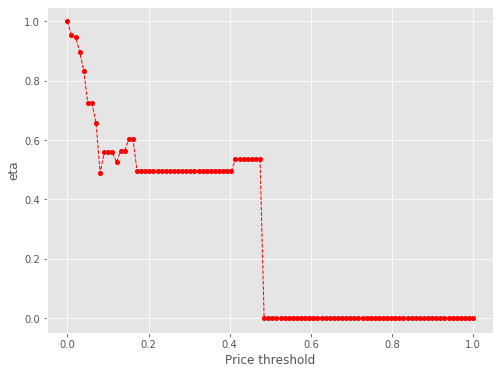

3849 33
Number of cells with price above 27.0th percentile:  33


eta =  1.0
eta =  0.9958267753047663
eta =  0.9707083986112812
eta =  0.9239659471720683
eta =  0.7609722400299642
eta =  0.7609722400299642
eta =  0.6911569989821907
eta =  0.5407943860161541
eta =  0.5686425390097931
eta =  0.5871076010462591
eta =  0.5871076010462591
eta =  0.5515836382472901
eta =  0.59250922366545
eta =  0.59250922366545
eta =  0.5721504569440082
eta =  0.6353126935088415
eta =  0.5211704190975779
eta =  0.5211704190975779
eta =  0.5211704190975779
eta =  0.5211704190975779
eta =  0.5211704190975779
eta =  0.5211704190975779
eta =  0.5211704190975779
eta =  0.5211704190975779
eta =  0.5211704190975779
eta =  0.5211704190975779
eta =  0.5211704190975779
eta =  0.5211704190975779
eta =  0.5211704190975779
eta =  0.5211704190975779
eta =  0.5211704190975779
eta =  0.5211704190975779
eta =  0.5211704190975779
eta =  0.5211704190975779
eta =  0.5211704190975779
eta =  0.5211704190975779
eta =  0.5211704190975779
eta =  0.5211704190975779
eta =  0.5211704190975779
eta =

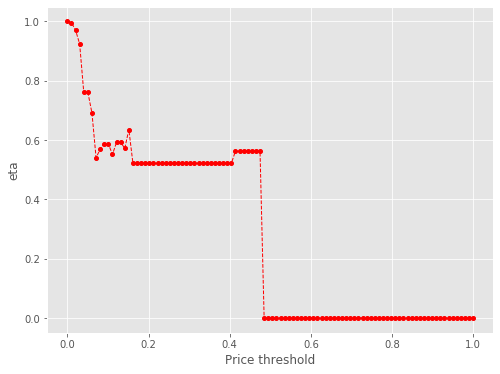

3849 28
Number of cells with price above 28.000000000000004th percentile:  28


eta =  1.0
eta =  0.9228996790356263
eta =  0.8792029895509708
eta =  0.7641612566573877
eta =  0.7755841529142564
eta =  0.5430607003418316
eta =  0.5409109181012779
eta =  0.5895680007866617
eta =  0.5895680007866617
eta =  0.5895680007866617
eta =  0.5538951672377774
eta =  0.5949922600585995
eta =  0.5949922600585995
eta =  0.6379751069802357
eta =  0.6167320270780171
eta =  0.5233544950004754
eta =  0.5233544950004754
eta =  0.5233544950004754
eta =  0.5233544950004754
eta =  0.5233544950004754
eta =  0.5233544950004754
eta =  0.5233544950004754
eta =  0.5233544950004754
eta =  0.5233544950004754
eta =  0.5233544950004754
eta =  0.5233544950004754
eta =  0.5233544950004754
eta =  0.5233544950004754
eta =  0.5233544950004754
eta =  0.5233544950004754
eta =  0.5233544950004754
eta =  0.5233544950004754
eta =  0.5233544950004754
eta =  0.5233544950004754
eta =  0.5233544950004754
eta =  0.5233544950004754
eta =  0.5233544950004754
eta =  0.5233544950004754
eta =  0.5233544950004754
e

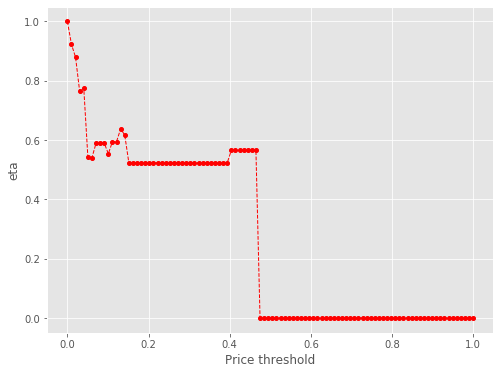

3849 25
Number of cells with price above 29.000000000000004th percentile:  25


eta =  1.0
eta =  0.9083192487737981
eta =  0.8280003493509602
eta =  0.8403775302259228
eta =  0.5884287454832543
eta =  0.5860993674485798
eta =  0.638821330399339
eta =  0.638821330399339
eta =  0.638821330399339
eta =  0.6001683387912368
eta =  0.644698739824387
eta =  0.644698739824387
eta =  0.6912724334749805
eta =  0.6912724334749805
eta =  0.567076256378536
eta =  0.567076256378536
eta =  0.567076256378536
eta =  0.567076256378536
eta =  0.567076256378536
eta =  0.567076256378536
eta =  0.567076256378536
eta =  0.567076256378536
eta =  0.567076256378536
eta =  0.567076256378536
eta =  0.567076256378536
eta =  0.567076256378536
eta =  0.567076256378536
eta =  0.567076256378536
eta =  0.567076256378536
eta =  0.567076256378536
eta =  0.567076256378536
eta =  0.567076256378536
eta =  0.567076256378536
eta =  0.567076256378536
eta =  0.567076256378536
eta =  0.567076256378536
eta =  0.567076256378536
eta =  0.567076256378536
eta =  0.567076256378536
eta =  0.612176798327144
eta = 

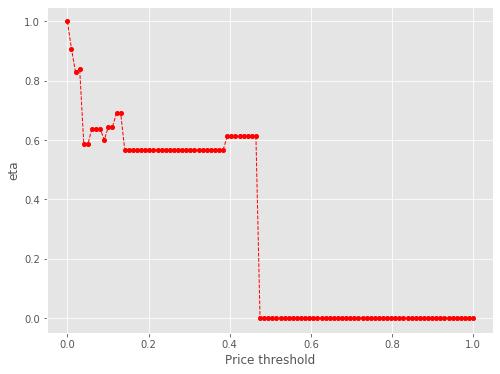

3849 20
Number of cells with price above 30.0th percentile:  20


eta =  1.0
eta =  0.9082552064645297
eta =  0.6756601603615063
eta =  0.7715230203708102
eta =  0.7715230203708102
eta =  0.7715230203708102
eta =  0.7248406830524735
eta =  0.7786213379375301
eta =  0.7786213379375301
eta =  0.751867711917427
eta =  0.8348697364884496
eta =  0.684874416807972
eta =  0.684874416807972
eta =  0.684874416807972
eta =  0.684874416807972
eta =  0.684874416807972
eta =  0.684874416807972
eta =  0.684874416807972
eta =  0.684874416807972
eta =  0.684874416807972
eta =  0.684874416807972
eta =  0.684874416807972
eta =  0.684874416807972
eta =  0.684874416807972
eta =  0.684874416807972
eta =  0.684874416807972
eta =  0.684874416807972
eta =  0.684874416807972
eta =  0.684874416807972
eta =  0.684874416807972
eta =  0.684874416807972
eta =  0.684874416807972
eta =  0.684874416807972
eta =  0.684874416807972
eta =  0.684874416807972
eta =  0.684874416807972
eta =  0.684874416807972
eta =  0.684874416807972
eta =  0.739343647387356
eta =  0.739343647387356
eta =

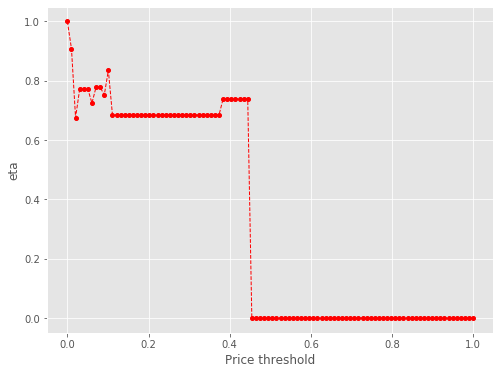

3849 20
Number of cells with price above 31.0th percentile:  20


eta =  1.0
eta =  0.9082552064645297
eta =  0.6756601603615063
eta =  0.7715230203708102
eta =  0.7715230203708102
eta =  0.7715230203708102
eta =  0.7248406830524735
eta =  0.7786213379375301
eta =  0.7786213379375301
eta =  0.751867711917427
eta =  0.8348697364884496
eta =  0.684874416807972
eta =  0.684874416807972
eta =  0.684874416807972
eta =  0.684874416807972
eta =  0.684874416807972
eta =  0.684874416807972
eta =  0.684874416807972
eta =  0.684874416807972
eta =  0.684874416807972
eta =  0.684874416807972
eta =  0.684874416807972
eta =  0.684874416807972
eta =  0.684874416807972
eta =  0.684874416807972
eta =  0.684874416807972
eta =  0.684874416807972
eta =  0.684874416807972
eta =  0.684874416807972
eta =  0.684874416807972
eta =  0.684874416807972
eta =  0.684874416807972
eta =  0.684874416807972
eta =  0.684874416807972
eta =  0.684874416807972
eta =  0.684874416807972
eta =  0.684874416807972
eta =  0.684874416807972
eta =  0.739343647387356
eta =  0.739343647387356
eta =

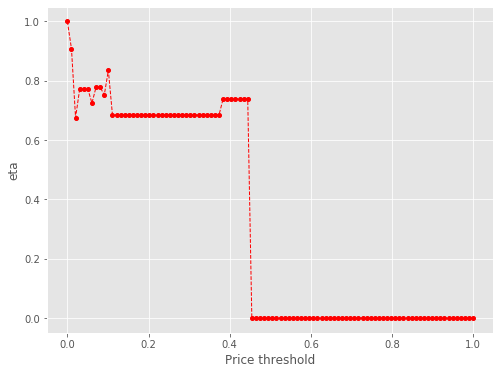

3849 14
Number of cells with price above 32.0th percentile:  14


eta =  1.0
eta =  1.0514949003054315
eta =  1.0856392304130198
eta =  1.0856392304130198
eta =  1.0856392304130198
eta =  1.0956275416064527
eta =  1.0956275416064527
eta =  1.0956275416064527
eta =  1.174776791210743
eta =  1.1356594699078992
eta =  0.9637127022284027
eta =  0.9637127022284027
eta =  0.9637127022284027
eta =  0.9637127022284027
eta =  0.9637127022284027
eta =  0.9637127022284027
eta =  0.9637127022284027
eta =  0.9637127022284027
eta =  0.9637127022284027
eta =  0.9637127022284027
eta =  0.9637127022284027
eta =  0.9637127022284027
eta =  0.9637127022284027
eta =  0.9637127022284027
eta =  0.9637127022284027
eta =  0.9637127022284027
eta =  0.9637127022284027
eta =  0.9637127022284027
eta =  0.9637127022284027
eta =  0.9637127022284027
eta =  0.9637127022284027
eta =  0.9637127022284027
eta =  0.9637127022284027
eta =  0.9637127022284027
eta =  0.9637127022284027
eta =  0.9637127022284027
eta =  1.0403584172700235
eta =  1.0403584172700235
eta =  1.0403584172700235
et

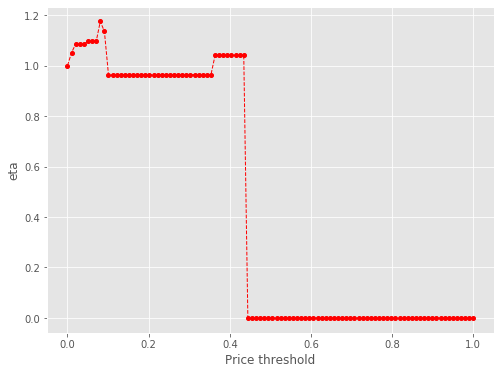

3849 10
Number of cells with price above 33.0th percentile:  10


eta =  1.0
eta =  1.0324721785123925
eta =  1.0324721785123925
eta =  1.0324721785123925
eta =  1.0419713317565324
eta =  1.0419713317565324
eta =  1.0419713317565324
eta =  1.11724440210742
eta =  1.0800427748893695
eta =  0.9165167628948743
eta =  0.9165167628948743
eta =  0.9165167628948743
eta =  0.9165167628948743
eta =  0.9165167628948743
eta =  0.9165167628948743
eta =  0.9165167628948743
eta =  0.9165167628948743
eta =  0.9165167628948743
eta =  0.9165167628948743
eta =  0.9165167628948743
eta =  0.9165167628948743
eta =  0.9165167628948743
eta =  0.9165167628948743
eta =  0.9165167628948743
eta =  0.9165167628948743
eta =  0.9165167628948743
eta =  0.9165167628948743
eta =  0.9165167628948743
eta =  0.9165167628948743
eta =  0.9165167628948743
eta =  0.9165167628948743
eta =  0.9165167628948743
eta =  0.9165167628948743
eta =  0.9165167628948743
eta =  0.9165167628948743
eta =  0.9165167628948743
eta =  0.9894089043777834
eta =  0.9894089043777834
eta =  0.9894089043777834
eta

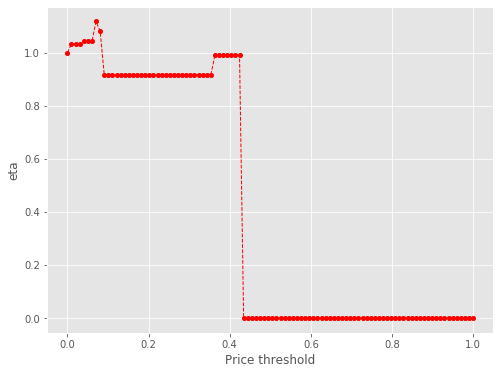

3849 9
Number of cells with price above 34.0th percentile:  9


eta =  1.0
eta =  1.0092003963320606
eta =  1.0092003963320606
eta =  1.0092003963320606
eta =  1.0821060609276358
eta =  1.0460744583408705
eta =  0.887691486481903
eta =  0.887691486481903
eta =  0.887691486481903
eta =  0.887691486481903
eta =  0.887691486481903
eta =  0.887691486481903
eta =  0.887691486481903
eta =  0.887691486481903
eta =  0.887691486481903
eta =  0.887691486481903
eta =  0.887691486481903
eta =  0.887691486481903
eta =  0.887691486481903
eta =  0.887691486481903
eta =  0.887691486481903
eta =  0.887691486481903
eta =  0.887691486481903
eta =  0.887691486481903
eta =  0.887691486481903
eta =  0.887691486481903
eta =  0.887691486481903
eta =  0.887691486481903
eta =  0.887691486481903
eta =  0.887691486481903
eta =  0.887691486481903
eta =  0.887691486481903
eta =  0.887691486481903
eta =  0.887691486481903
eta =  0.9582911045635578
eta =  0.9582911045635578
eta =  0.9582911045635578
eta =  0.9582911045635578
eta =  0.9582911045635578
eta =  0.9582911045635578
eta

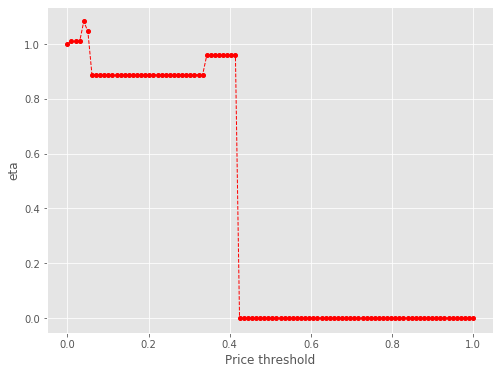

3849 9
Number of cells with price above 35.0th percentile:  9


eta =  1.0
eta =  1.0092003963320606
eta =  1.0092003963320606
eta =  1.0092003963320606
eta =  1.0821060609276358
eta =  1.0460744583408705
eta =  0.887691486481903
eta =  0.887691486481903
eta =  0.887691486481903
eta =  0.887691486481903
eta =  0.887691486481903
eta =  0.887691486481903
eta =  0.887691486481903
eta =  0.887691486481903
eta =  0.887691486481903
eta =  0.887691486481903
eta =  0.887691486481903
eta =  0.887691486481903
eta =  0.887691486481903
eta =  0.887691486481903
eta =  0.887691486481903
eta =  0.887691486481903
eta =  0.887691486481903
eta =  0.887691486481903
eta =  0.887691486481903
eta =  0.887691486481903
eta =  0.887691486481903
eta =  0.887691486481903
eta =  0.887691486481903
eta =  0.887691486481903
eta =  0.887691486481903
eta =  0.887691486481903
eta =  0.887691486481903
eta =  0.887691486481903
eta =  0.9582911045635578
eta =  0.9582911045635578
eta =  0.9582911045635578
eta =  0.9582911045635578
eta =  0.9582911045635578
eta =  0.9582911045635578
eta

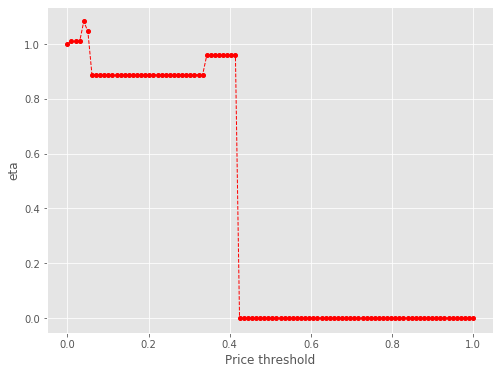

3849 7
Number of cells with price above 36.00000000000001th percentile:  7


eta =  1.0
eta =  1.0722410185930873
eta =  0.8795988286451514
eta =  0.8795988286451514
eta =  0.8795988286451514
eta =  0.8795988286451514
eta =  0.8795988286451514
eta =  0.8795988286451514
eta =  0.8795988286451514
eta =  0.8795988286451514
eta =  0.8795988286451514
eta =  0.8795988286451514
eta =  0.8795988286451514
eta =  0.8795988286451514
eta =  0.8795988286451514
eta =  0.8795988286451514
eta =  0.8795988286451514
eta =  0.8795988286451514
eta =  0.8795988286451514
eta =  0.8795988286451514
eta =  0.8795988286451514
eta =  0.8795988286451514
eta =  0.8795988286451514
eta =  0.8795988286451514
eta =  0.8795988286451514
eta =  0.8795988286451514
eta =  0.8795988286451514
eta =  0.8795988286451514
eta =  0.8795988286451514
eta =  0.8795988286451514
eta =  0.8795988286451514
eta =  0.9495548238451624
eta =  0.9495548238451624
eta =  0.9495548238451624
eta =  0.9495548238451624
eta =  0.9495548238451624
eta =  0.9495548238451624
eta =  0.9495548238451624
eta =  0.9495548238451624
e

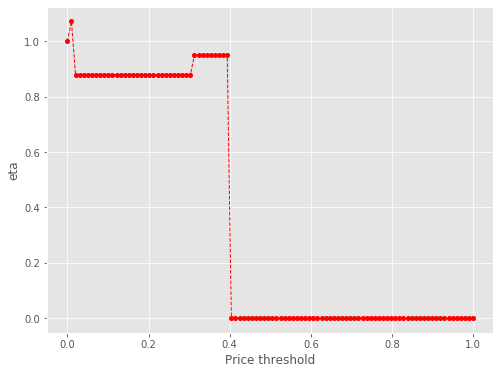

3849 7
Number of cells with price above 37.0th percentile:  7


eta =  1.0
eta =  1.0722410185930873
eta =  0.8795988286451514
eta =  0.8795988286451514
eta =  0.8795988286451514
eta =  0.8795988286451514
eta =  0.8795988286451514
eta =  0.8795988286451514
eta =  0.8795988286451514
eta =  0.8795988286451514
eta =  0.8795988286451514
eta =  0.8795988286451514
eta =  0.8795988286451514
eta =  0.8795988286451514
eta =  0.8795988286451514
eta =  0.8795988286451514
eta =  0.8795988286451514
eta =  0.8795988286451514
eta =  0.8795988286451514
eta =  0.8795988286451514
eta =  0.8795988286451514
eta =  0.8795988286451514
eta =  0.8795988286451514
eta =  0.8795988286451514
eta =  0.8795988286451514
eta =  0.8795988286451514
eta =  0.8795988286451514
eta =  0.8795988286451514
eta =  0.8795988286451514
eta =  0.8795988286451514
eta =  0.8795988286451514
eta =  0.9495548238451624
eta =  0.9495548238451624
eta =  0.9495548238451624
eta =  0.9495548238451624
eta =  0.9495548238451624
eta =  0.9495548238451624
eta =  0.9495548238451624
eta =  0.9495548238451624
e

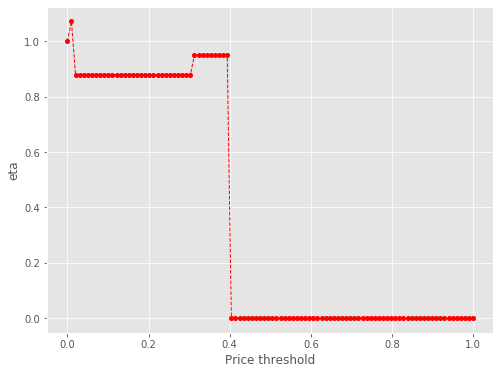

3849 5
Number of cells with price above 38.0th percentile:  5


eta =  1.0
eta =  0.8203368584045533
eta =  0.8203368584045533
eta =  0.8203368584045533
eta =  0.8203368584045533
eta =  0.8203368584045533
eta =  0.8203368584045533
eta =  0.8203368584045533
eta =  0.8203368584045533
eta =  0.8203368584045533
eta =  0.8203368584045533
eta =  0.8203368584045533
eta =  0.8203368584045533
eta =  0.8203368584045533
eta =  0.8203368584045533
eta =  0.8203368584045533
eta =  0.8203368584045533
eta =  0.8203368584045533
eta =  0.8203368584045533
eta =  0.8203368584045533
eta =  0.8203368584045533
eta =  0.8203368584045533
eta =  0.8203368584045533
eta =  0.8203368584045533
eta =  0.8203368584045533
eta =  0.8203368584045533
eta =  0.8203368584045533
eta =  0.8203368584045533
eta =  0.8203368584045533
eta =  0.8203368584045533
eta =  0.8855796480264257
eta =  0.8855796480264257
eta =  0.8855796480264257
eta =  0.8855796480264257
eta =  0.8855796480264257
eta =  0.8855796480264257
eta =  0.8855796480264257
eta =  0.8855796480264257
eta =  0.8855796480264257
e

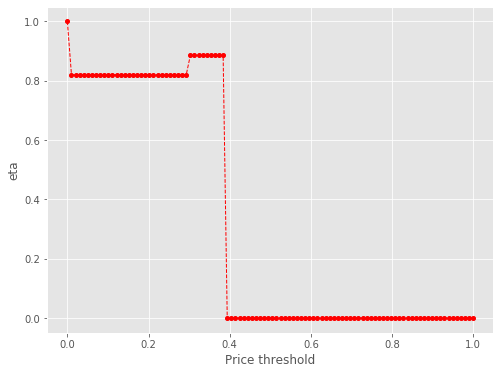

3849 3
Number of cells with price above 39.0th percentile:  3


eta =  1.0
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

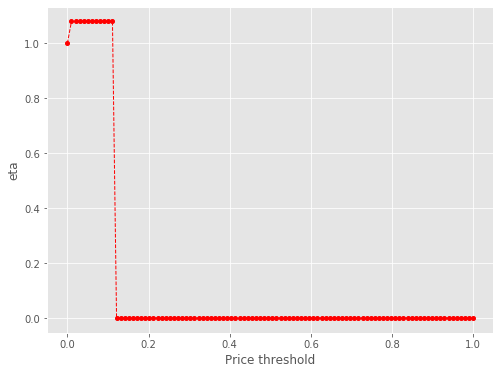

3849 3
Number of cells with price above 40.0th percentile:  3


eta =  1.0
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

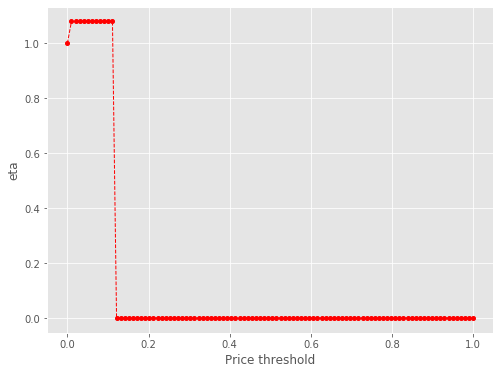

3849 3
Number of cells with price above 41.0th percentile:  3


eta =  1.0
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

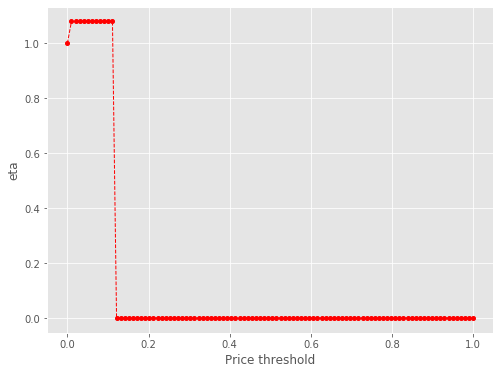

3849 3
Number of cells with price above 42.00000000000001th percentile:  3


eta =  1.0
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

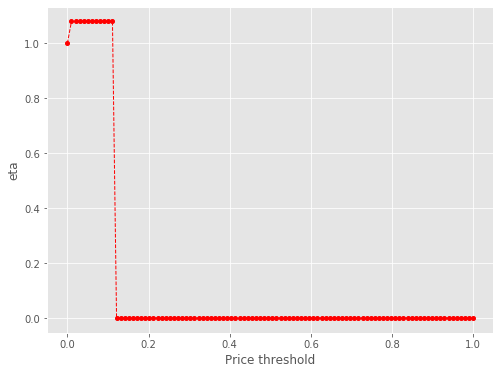

3849 3
Number of cells with price above 43.0th percentile:  3


eta =  1.0
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

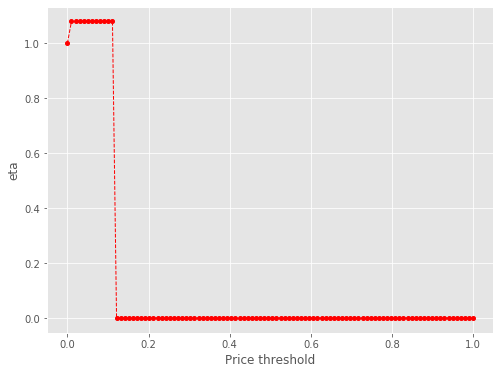

3849 3
Number of cells with price above 44.0th percentile:  3


eta =  1.0
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

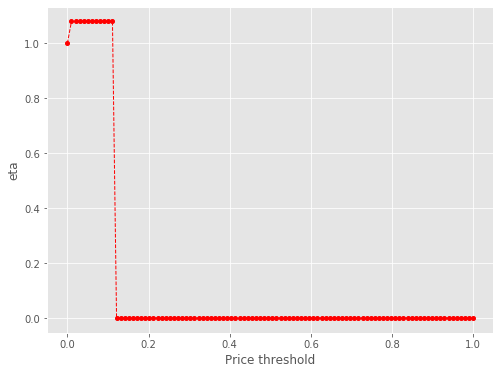

3849 3
Number of cells with price above 45.0th percentile:  3


eta =  1.0
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

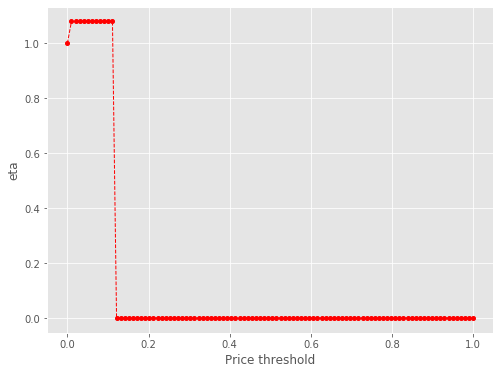

3849 3
Number of cells with price above 46.0th percentile:  3


eta =  1.0
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

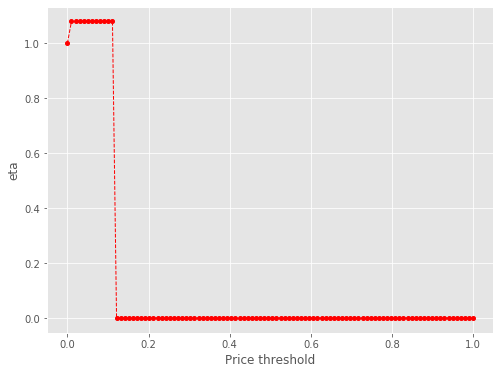

3849 3
Number of cells with price above 47.0th percentile:  3


eta =  1.0
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

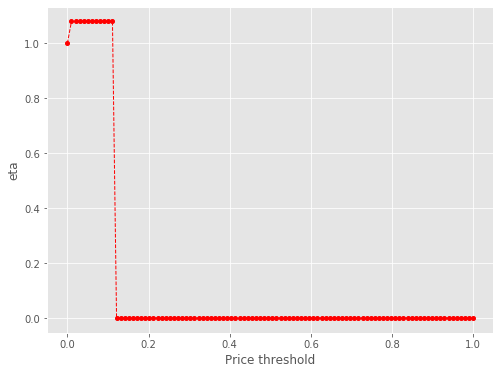

3849 3
Number of cells with price above 48.00000000000001th percentile:  3


eta =  1.0
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

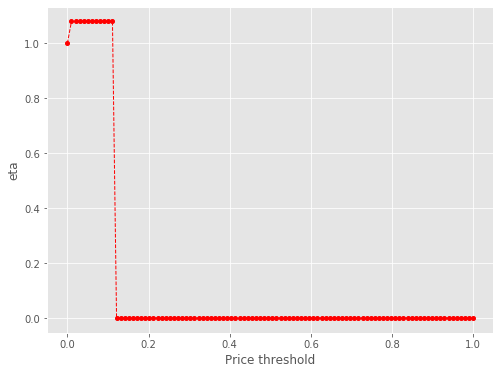

3849 3
Number of cells with price above 49.0th percentile:  3


eta =  1.0
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

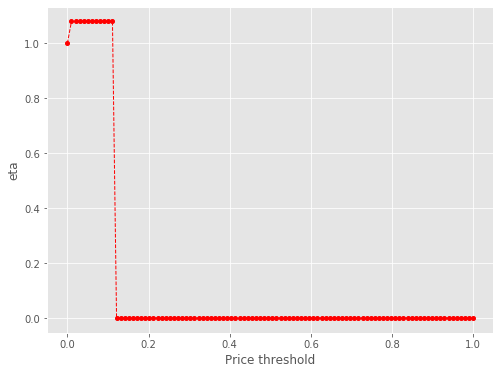

3849 3
Number of cells with price above 50.0th percentile:  3


eta =  1.0
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

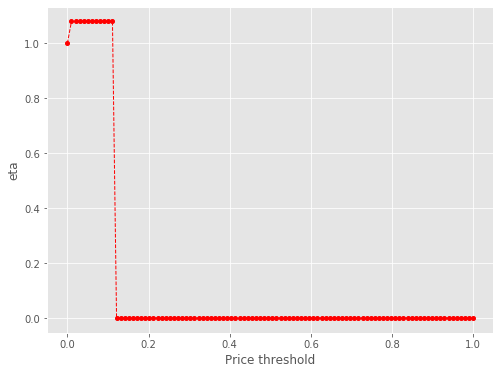

3849 3
Number of cells with price above 51.0th percentile:  3


eta =  1.0
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

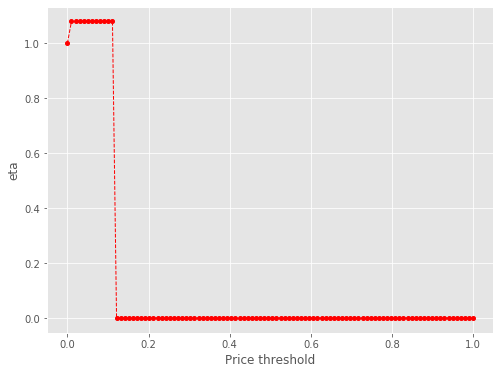

3849 3
Number of cells with price above 52.0th percentile:  3


eta =  1.0
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

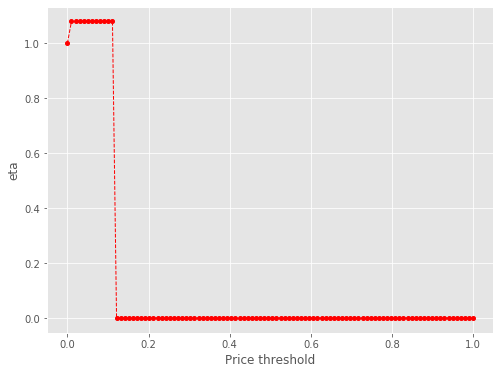

3849 3
Number of cells with price above 53.0th percentile:  3


eta =  1.0
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

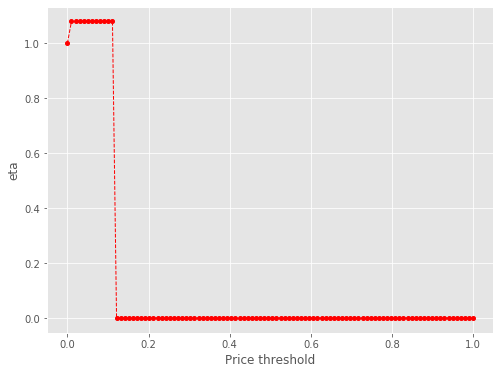

3849 3
Number of cells with price above 54.0th percentile:  3


eta =  1.0
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

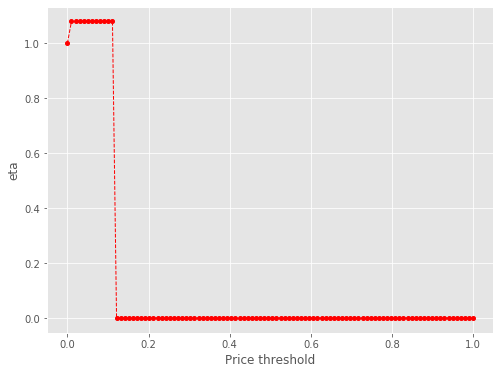

3849 3
Number of cells with price above 55.00000000000001th percentile:  3


eta =  1.0
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

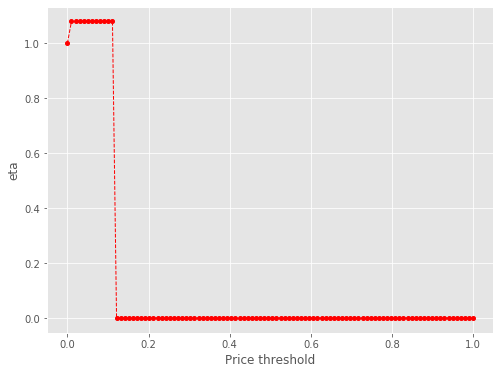

3849 3
Number of cells with price above 56.00000000000001th percentile:  3


eta =  1.0
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  1.0795317057297182
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

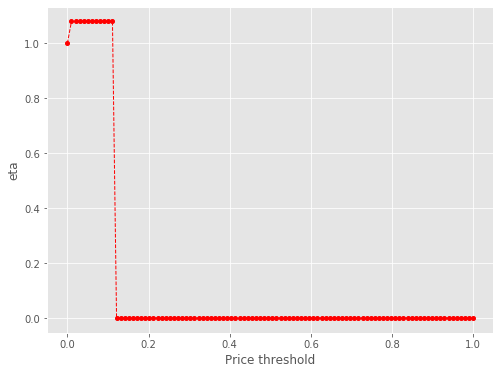

3849 2
Number of cells with price above 57.00000000000001th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

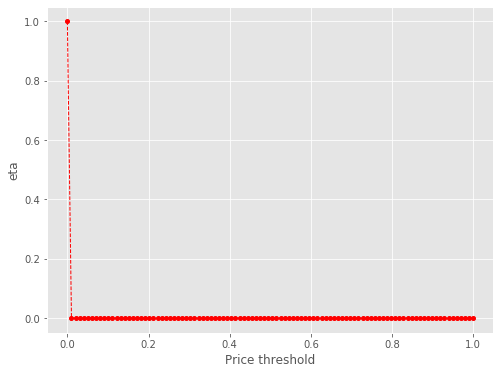

3849 2
Number of cells with price above 58.00000000000001th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

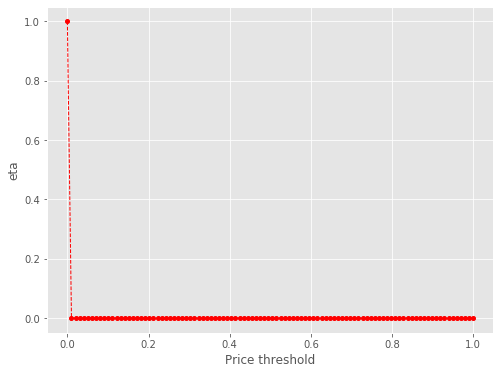

3849 2
Number of cells with price above 59.0th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

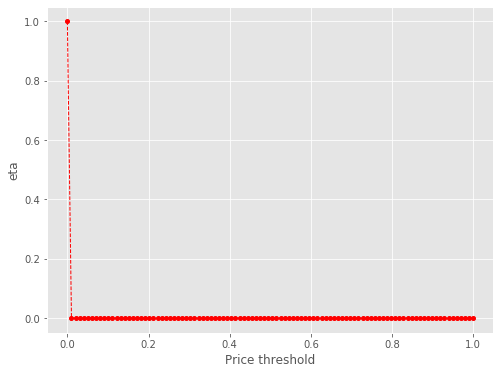

3849 2
Number of cells with price above 60.0th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

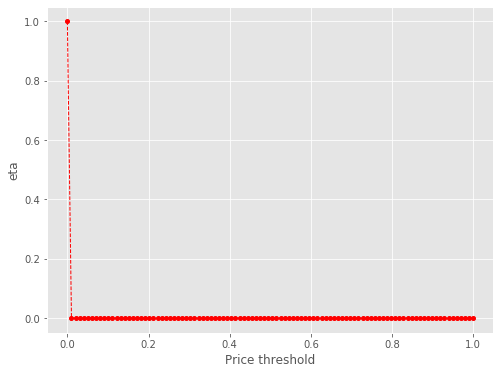

3849 2
Number of cells with price above 61.0th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

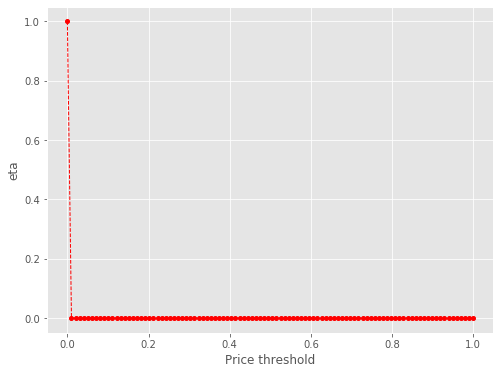

3849 2
Number of cells with price above 62.0th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

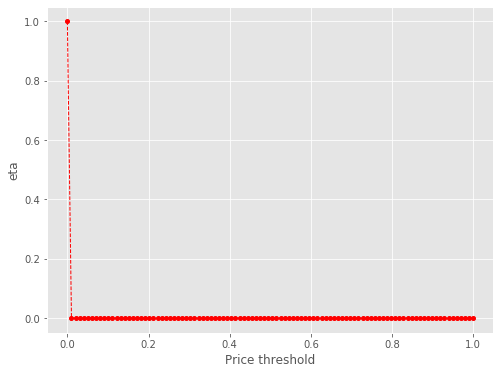

3849 1
Number of cells with price above 63.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning:

invalid value encountered in true_divide



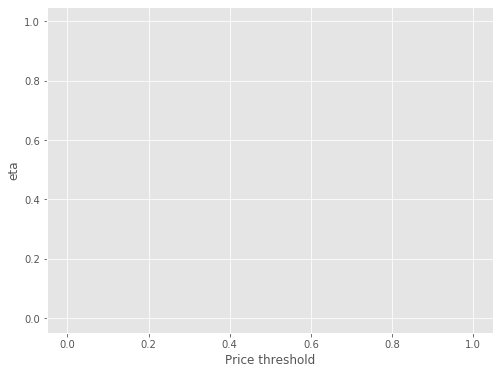

3849 1
Number of cells with price above 64.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

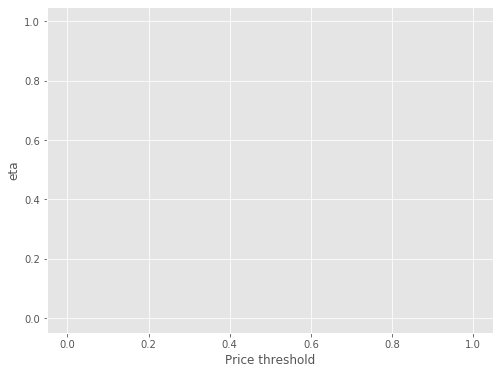

3849 1
Number of cells with price above 65.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

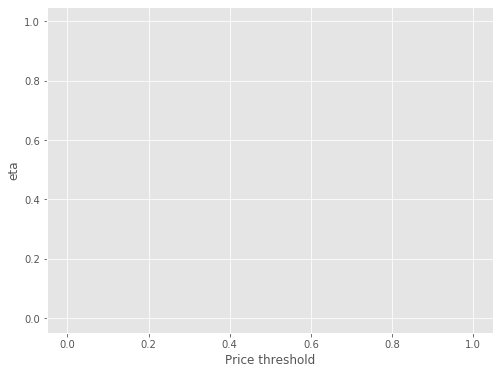

3849 1
Number of cells with price above 66.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

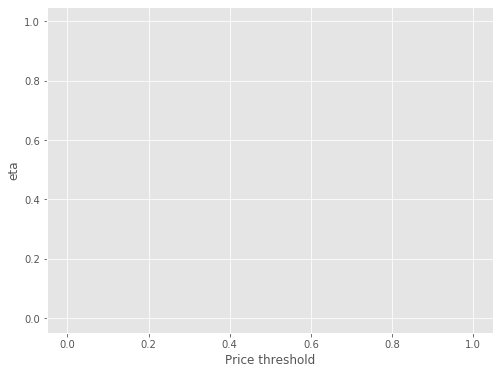

3849 1
Number of cells with price above 67.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

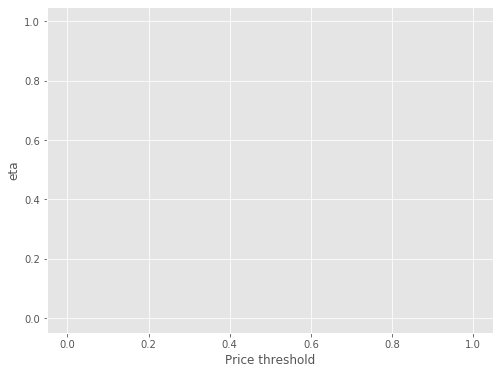

3849 1
Number of cells with price above 68.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

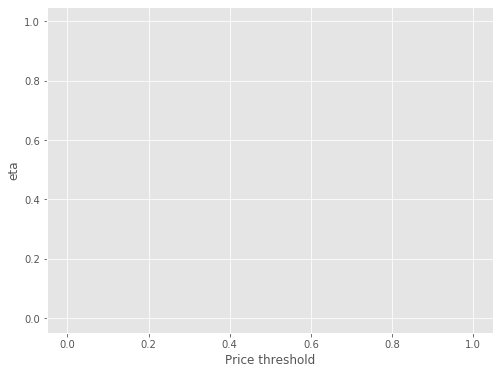

3849 1
Number of cells with price above 69.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

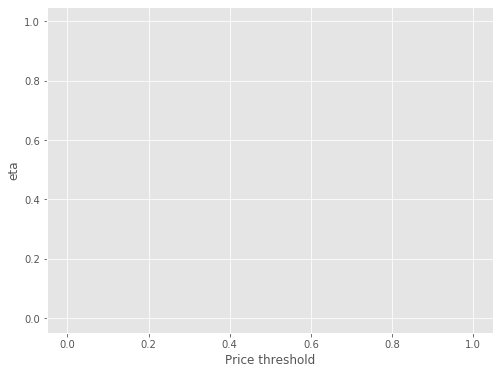

3849 1
Number of cells with price above 70.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

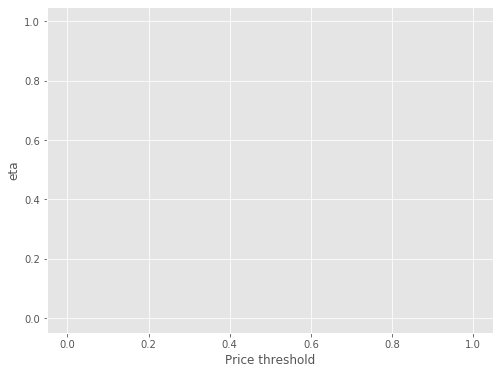

3849 1
Number of cells with price above 71.00000000000001th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

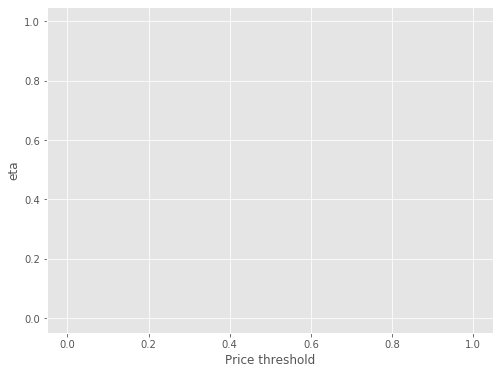

3849 1
Number of cells with price above 72.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

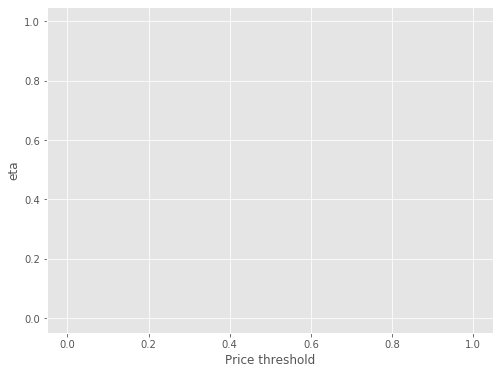

3849 1
Number of cells with price above 73.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

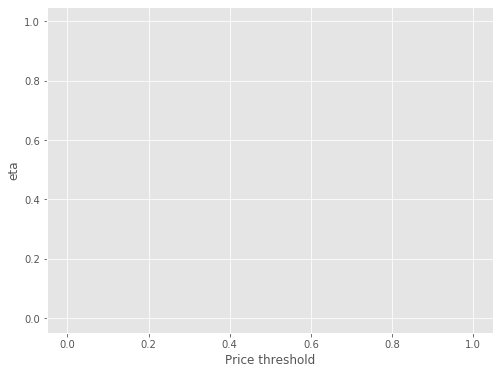

3849 1
Number of cells with price above 74.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

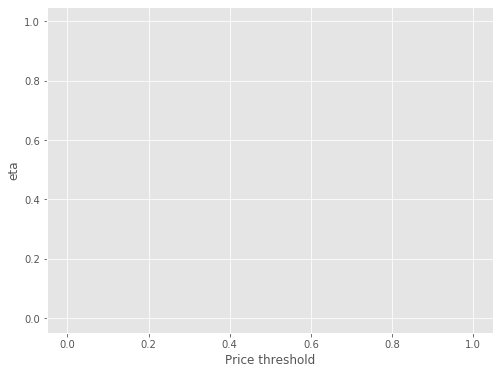

3849 1
Number of cells with price above 75.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

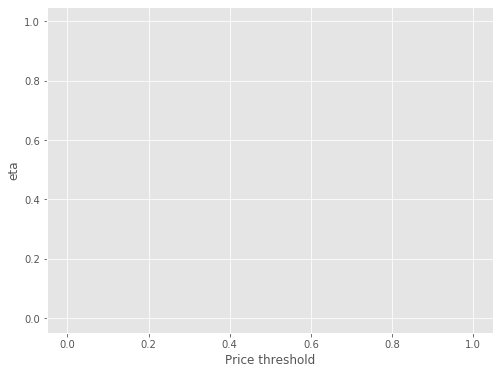

3849 1
Number of cells with price above 76.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

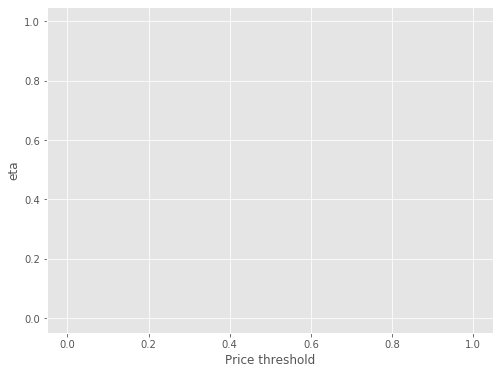

3849 1
Number of cells with price above 77.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

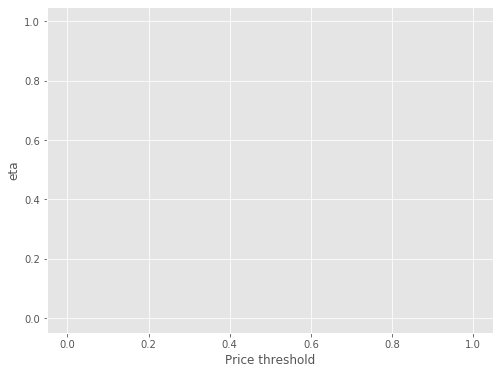

3849 1
Number of cells with price above 78.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

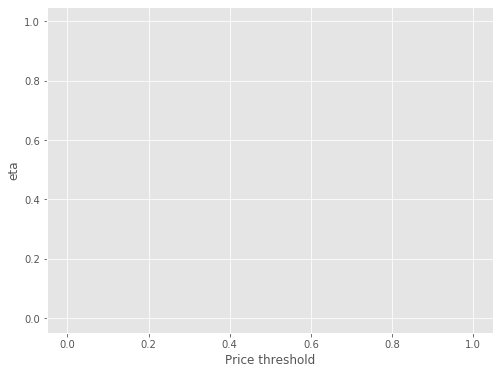

3849 1
Number of cells with price above 79.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

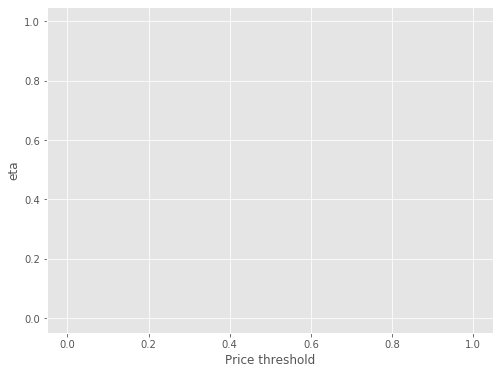

3849 1
Number of cells with price above 80.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

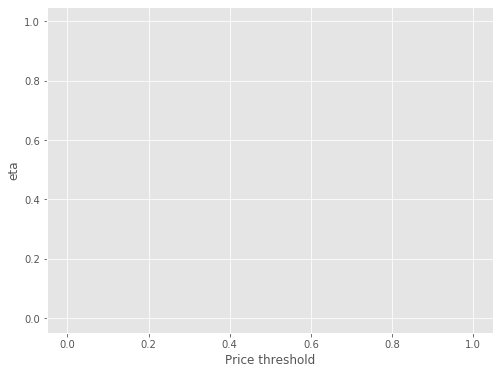

3849 1
Number of cells with price above 81.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

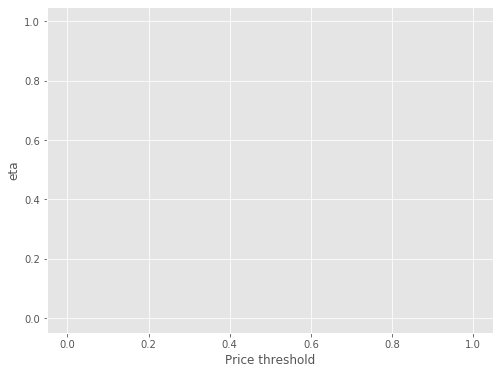

3849 1
Number of cells with price above 82.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

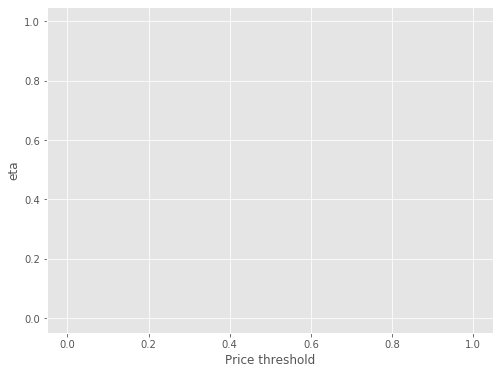

3849 1
Number of cells with price above 83.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

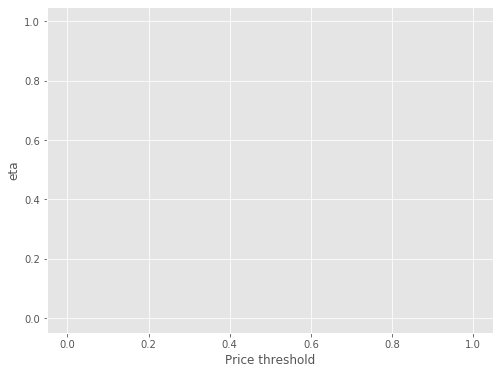

3849 1
Number of cells with price above 84.00000000000001th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

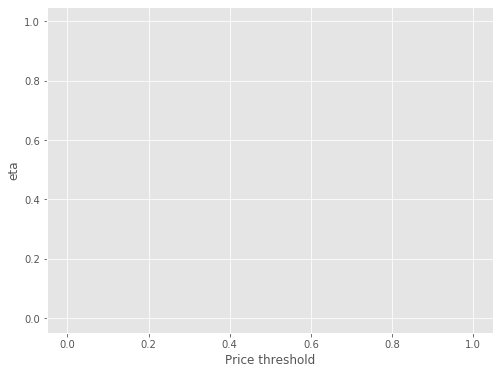

3849 1
Number of cells with price above 85.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

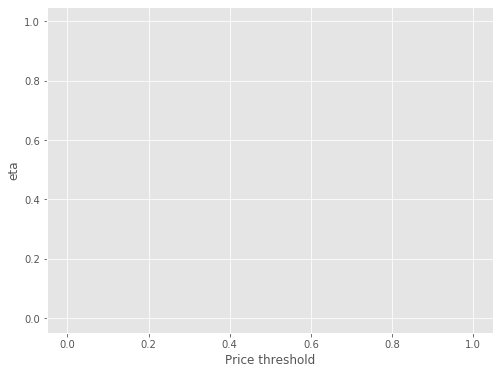

3849 1
Number of cells with price above 86.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

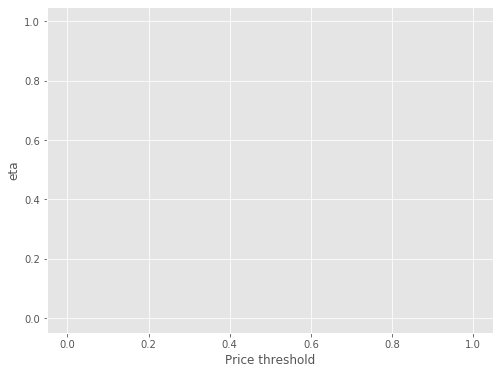

3849 1
Number of cells with price above 87.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

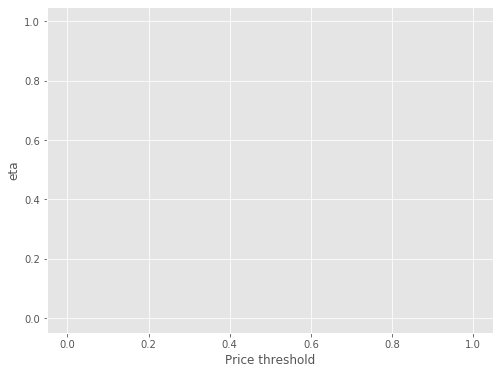

3849 1
Number of cells with price above 88.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

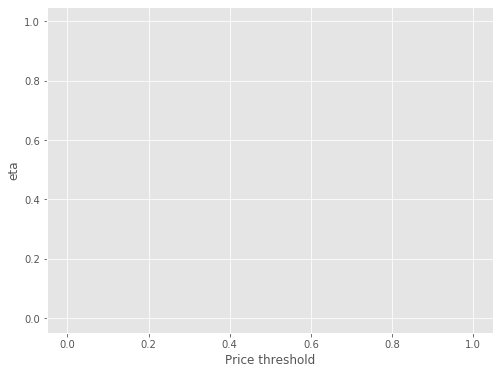

3849 1
Number of cells with price above 89.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

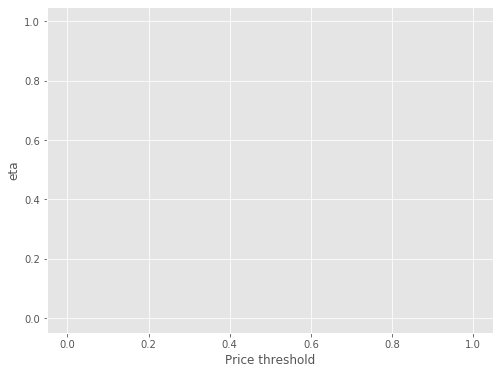

3849 1
Number of cells with price above 90.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

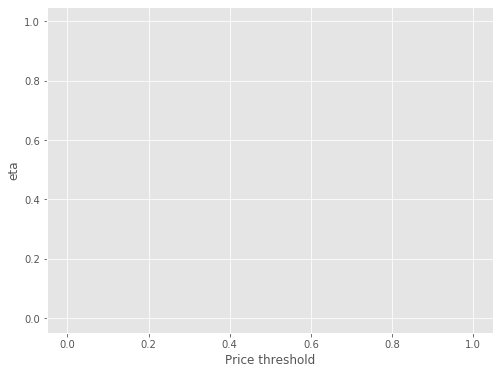

3849 1
Number of cells with price above 91.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

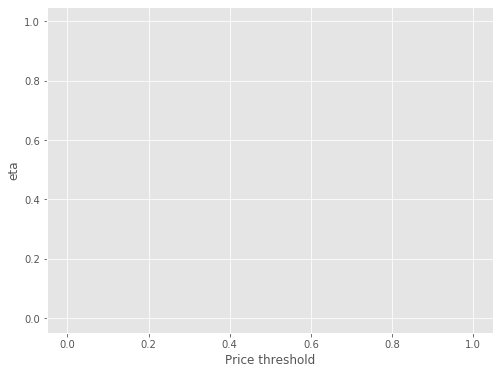

3849 1
Number of cells with price above 92.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

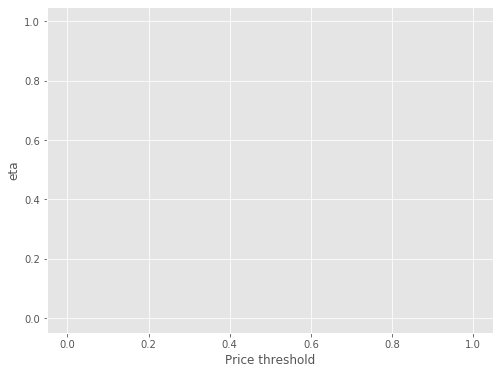

3849 1
Number of cells with price above 93.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

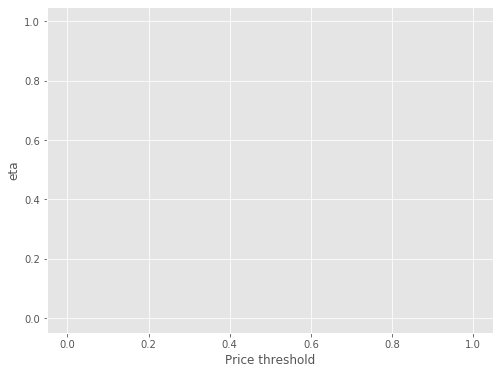

3849 1
Number of cells with price above 94.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

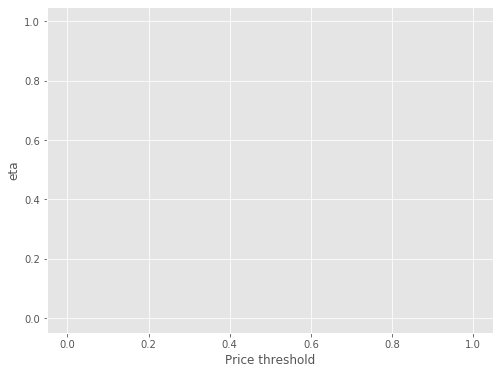

3849 1
Number of cells with price above 95.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

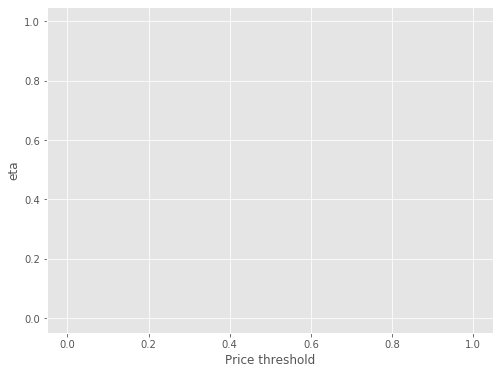

3849 1
Number of cells with price above 96.00000000000001th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

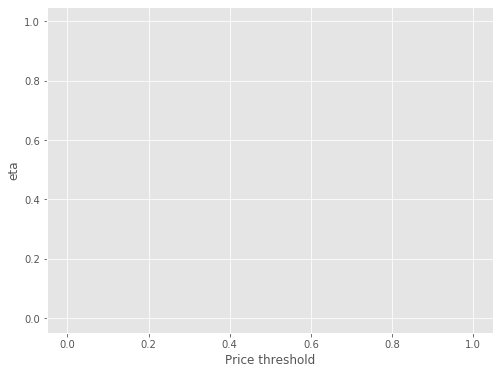

3849 1
Number of cells with price above 97.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

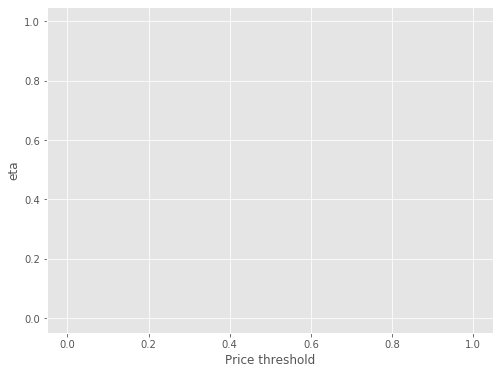

3849 1
Number of cells with price above 98.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

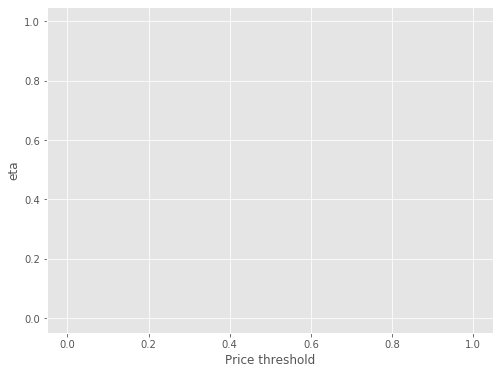

3849 1
Number of cells with price above 99.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

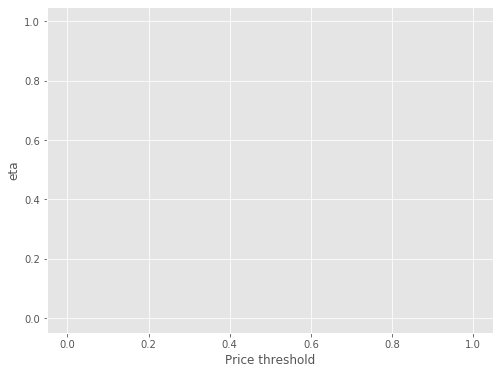

3849 1
Number of cells with price above 100.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

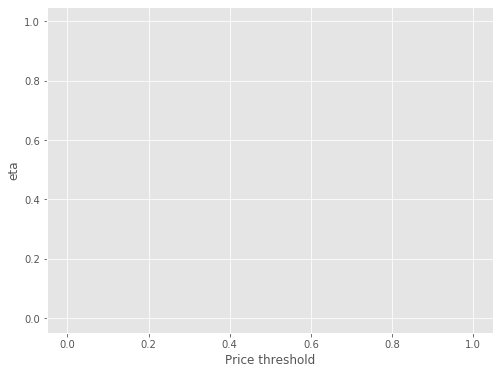


time: 1min 6s


In [33]:
lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
#keys = np.array(keys)
keys_initial = np.array(keys)


perc_vals = np.linspace(0.01, 1, 100)
etas_2d = []
for i in tqdm_notebook(perc_vals):
    keys = keys_initial
    vals_cut = vals[vals>=i*vals.max()]
    print(len(vals), len(vals_cut))

    L = np.cumsum(vals_cut)/np.sum(vals_cut)
    keys = keys[vals>=i*vals.max()]
    print('Number of cells with price above {}th percentile: '.format(i*100), len(keys))
    etas = []
    lval = np.linspace(min(vals_cut), max(vals_cut), 100)
    for k in tqdm_notebook(lval):
        loubar_keys = keys[vals_cut>=k]
        dist_mat = mat[keys.reshape(-1,1), keys]

        total_dist = dist_mat.sum()
        dist_corr = dist_mat[dist_mat>0]

        loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]

        loubar_dist = loubar_dist_mat.sum()

        loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
        eta = loubar_dist_corr.mean()/dist_corr.mean()
        etas.append(eta)
        print('eta = ', eta)
    etas_array = np.array(etas)
    etas_array = np.where(np.isnan(etas_array), 0, etas_array)
    lval = (lval - lval.min())/(lval - lval.min()).max()
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(lval, etas_array, color='r', linestyle='--', marker='o', markersize=4, linewidth=1)
    plt.xlabel("Price threshold")
    plt.ylabel("eta")
    plt.show()
    etas_2d.append(etas)
etas_2d = np.array(etas_2d)
etas_2d = np.where(np.isnan(etas_2d), 0, etas_2d)
lval = lval/lval.max()

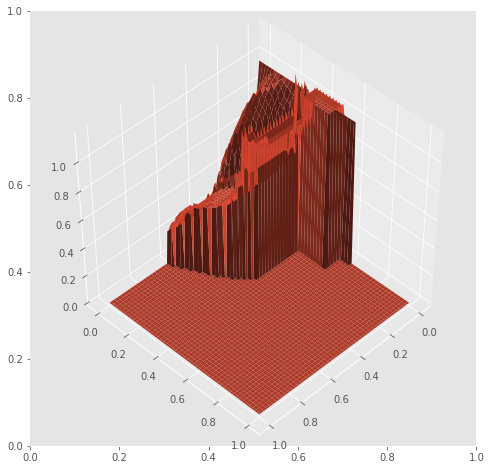

time: 1.21 s


In [34]:
X,Y = np.meshgrid(np.linspace(0,1, 100),np.linspace(0,1, 100))
etas_surface = etas_2d
fig, ax = plt.subplots(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
# Plot a 3D surface
ax.plot_surface(X, Y, etas_surface)
ax.view_init(45, 45)
plt.show()

In [35]:
pickle_in = open("etas_surface_dict.pickle","rb")
etas_surface_dict = pickle.load(pickle_in)
#etas_surface_dict = {}
etas_surface_dict['Beijing'] = etas_surface


pickle_out = open("etas_surface_dict.pickle","wb")
pickle.dump(etas_surface_dict, pickle_out)
pickle_out.close()

etas_surface_dict

{'NY': array([[1.        , 0.40697941, 0.38848337, ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.95418349, 0.92471336, ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.96911482, 0.94572765, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]]),
 'Boston': array([[1.        , 0.49308111, 0.46754658, ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.94621367, 0.92299712, ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.97340556, 0.95206791, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.       

time: 25 ms


3849 559
Number of cells with price above 5th percentile:  559
total number of cells:  3849
number of cells within urban airbnb territory:  559



Mean travel times in minutes:  21.06116037559737
Mean travel times in minutes:  28.331273866860812
Mean travel times in minutes:  30.64197472371565
Mean travel times in minutes:  44.030863995295704


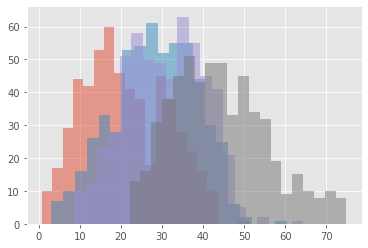

time: 2min 41s


In [36]:
from tqdm import tqdm_notebook

lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
keys = np.array(keys)

vals_cut = vals[vals>0.02*vals.max()]
print(len(vals), len(vals_cut))

L = np.cumsum(vals_cut)/np.sum(vals_cut)
keys = keys[vals>0.02*vals.max()]
print('Number of cells with price above 5th percentile: ', len(keys))

print('total number of cells: ', len(polylist))

times_names = ['times_{}'.format(c) for c in range(1, len(centers)+1)]
times_dict = {name:[] for name in times_names}

plist = poly_prices[poly_prices.index.isin(keys)].geometry.tolist()
print('number of cells within urban airbnb territory: ', len(plist))
for poly in tqdm_notebook(plist):
    origin = ox.get_nearest_node(G, poly.centroid.coords[0][::-1])
    dists_to_centers = []
    for node, target in centers.items():
        try:
            if origin!=target:
                path = nx.shortest_path(G, origin, target, weight='length')
                edges = [ tuple( path[i:i+2] ) for i in range( len(path) - 1 ) ]
                dist = np.sum([G.get_edge_data(*edge)[0]['length'] for edge in edges])
                dists_to_centers.append(dist)
        except:
            pass
    if len(dists_to_centers) != 0:
        dists_to_centers = sorted(dists_to_centers)
        #print('distance list length equal to # of centers: ', len(dists_to_centers)==len(centers))
        if len(dists_to_centers)==len(centers):
            for n, dist in enumerate(dists_to_centers):
                time = (dist/3.2)/60
                times_dict['times_{}'.format(n+1)].append(time)
                #print(times_dict['times_{}'.format(n+1)][-1])
        else:
            print('Distance list length NOT equal to # of centers')

#print(distances_dict)
for center in range(1, len(centers)+1):
    print("Mean travel times in minutes: ", np.mean(times_dict['times_{}'.format(center)]))
for center in range(1, len(centers)+1):
    plt.hist(times_dict['times_{}'.format(center)], bins=20, alpha=0.5)
plt.show()

Mean travel times in minutes:  21.06116037559737
Mean travel times in minutes:  28.331273866860812
Mean travel times in minutes:  30.64197472371565
Mean travel times in minutes:  44.030863995295704


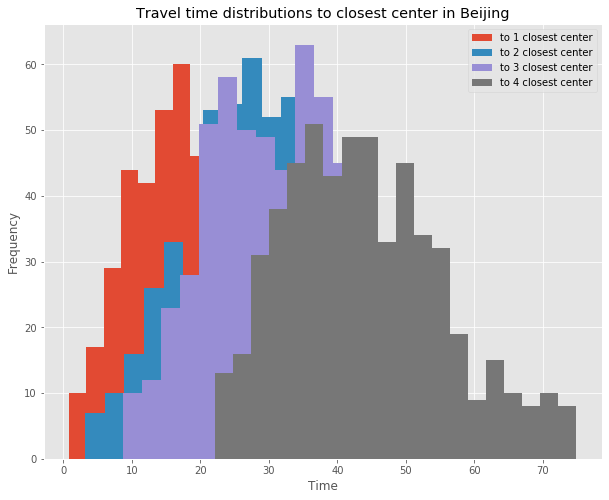

time: 509 ms


In [37]:
for center in range(1, len(centers)+1):
    times_dict['times_{}'.format(center)] = np.array(times_dict['times_{}'.format(center)])
    
for center in range(1, len(centers)+1):
    print("Mean travel times in minutes: ", np.mean(times_dict['times_{}'.format(center)]))

fig, ax = plt.subplots(figsize=(10,8))
for center in range(1, len(centers)+1):
    plt.hist(times_dict['times_{}'.format(center)], bins=20, alpha=1, label='to {} closest center'.format(center))
plt.title('Travel time distributions to closest center in Beijing')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [38]:
pickle_in = open("City_Accessibility.pickle","rb")
access_dict = pickle.load(pickle_in)
#access_dict = {}
access_dict['Beijing'] = times_dict


pickle_out = open("City_Accessibility.pickle","wb")
pickle.dump(access_dict, pickle_out)
pickle_out.close()

access_dict

{'Paris': {'times_1': array([ 4.73219737,  4.40047807,  7.81577632,  7.07926754,  6.7129386 ,
          7.48037281, 10.85755263,  8.41227193, 14.20045614, 15.15502193,
         16.00692982, 15.80582895, 14.35941228, 14.10681579, 12.26687281,
         13.89203947, 14.31310965, 15.99389474, 16.77728947, 17.82112281,
         20.19769737, 20.40849561, 21.93033333, 22.03087719, 20.6584386 ,
         20.62538596, 19.53197368, 20.61141228, 21.70609211, 23.22407018,
         21.70395614, 23.12607456, 22.79396053, 23.95434211, 21.49400439,
         21.55605702, 22.35374123, 22.36948246, 22.44162719, 21.54410965,
         21.93589912, 21.86757456, 21.86757456, 21.41060088, 21.92571491,
         22.93862281, 23.57200877, 25.13889474, 24.49192982, 26.04400877,
         26.815     , 38.90660088, 38.56507018, 37.89241228, 36.57546491,
         29.87379386, 27.54254825, 25.54755702, 26.98263158, 25.76562281,
         25.03485526, 25.37799123, 25.69687719, 26.07382018, 23.81846491,
         24.034649

time: 694 ms


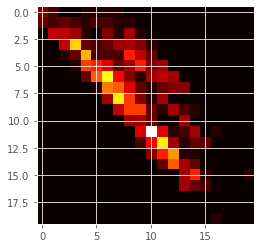

time: 148 ms


In [41]:
x = times_dict['times_{}'.format(1)]
y = times_dict['times_{}'.format(2)]
c_xy = np.histogram2d(x, y, 20)[0]
c_xx = np.histogram2d(x, x, 20)[0]
plt.imshow(c_xy, cmap='hot', interpolation='nearest')
plt.show()

In [42]:
from sklearn.metrics import mutual_info_score

def calc_MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

mi_list = []
for center in range(1, len(centers)+1):
    mi_list.append(times_dict['times_{}'.format(center)])

mis = []
for pair in combinations_with_replacement(mi_list, 2):
    MI = calc_MI(pair[0], pair[1], 20)
    print(MI)
    mis.append(MI)
mis = np.array(mis)
avg_mi = np.mean(mis)
print('average mutual information = ', avg_mi)

2.7306965763609905
0.9142530166523553
0.9031908279943922
0.5448960649027622
2.635434448294223
1.5132289922009472
0.819862493829842
2.587007977666234
0.8163045787395445
2.8288611097866387
average mutual information =  1.629373608642793
time: 29 ms


In [43]:
pickle_in = open("Time_distribution_mutual_information.pickle","rb")
MI_dict = pickle.load(pickle_in)
#MI_dict = {}
MI_dict['Beijing'] = avg_mi


pickle_out = open("Time_distribution_mutual_information.pickle","wb")
pickle.dump(MI_dict, pickle_out)
pickle_out.close()

MI_dict

{'Beijing': 1.629373608642793,
 'Florence': 2.0836399429599792,
 'Palermo': 1.8596013030930105,
 'Los_Angeles': 1.5602500680599918,
 'Moscow': 1.5631970905638934,
 'Porto': 1.6277816420571996,
 'Prague': 2.176480497902222,
 'Reykjavik': 1.3730161847793374,
 'Riga': 2.240374487910287,
 'Rome': 1.6095563575725969,
 'Seoul': 1.2910685865906735,
 'Siena': 2.7660068415344448,
 'Sydney': 1.2791891753795948,
 'Tallin': 2.3884073435187867,
 'Treviso': 2.631909071373147,
 'Valencia': 2.1872520197930965,
 'Venezia': 2.719891808939249,
 'Verona': 2.7080241467515376,
 'Vicenza': 2.6192607829416756,
 'Vienna': 1.4481542925032476,
 'Wellington': 2.1855226822614866,
 'Zurich': 2.462051055806955,
 'Aarhus': 2.2910468431831847,
 'Milan': 1.6107461389394335,
 'Busan': 1.903641833377143,
 'Barcelona': 1.6449937230537024,
 'Bologna': 2.7317991260148045,
 'Bremen': 1.9447717965210316,
 'Brno': 2.4300669174144036,
 'Budapest': 2.219525897631017,
 'Dublin': 1.830502368836079,
 'Boston': 1.1451275682586615,
 

time: 6 ms
